In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# LIBRARIES, FUNCTIONS, IMPORT AND UNDERSTAND DATA

In [ ]:
import os
import pandas as pd
import numpy as np

from pickle import dump
import json
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import NearMiss




from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [ ]:
# Data Report 
def data_report(df):
    
    # Información general
    print("Información general:\n")
    print(df.info())
    print("\n")
    
    # Resumen estadístico
    print("Resumen estadístico:\n")
    print(df.describe())
    print("\n")
    
    # Valores nulos
    print("Valores nulos:\n")
    print(df.isnull().sum())
    print("\n")
    
    # Valores únicos
    print("Valores únicos:\n")
    for col in df.columns:
        print(col, ":", df[col].nunique())
    print("\n")
    
    # Valores repetidos
    print("Valores repetidos:\n")
    print(df.duplicated().sum())
    print("\n")
    
    # Distribución de valores categóricos
    print("Distribución de valores categóricos:\n")
    for col in df.select_dtypes(include=["object"]).columns:
        print(col, ":\n", df[col].value_counts(normalize=True), "\n")

# Separar types
def obtener_listas_de_variables(dataset):
  id_vars = []
  num = []
  binary = []
  cat = []
  #estamos haciendo un for para averiguar que columnas son numericas (int, float), iterando sobre todas las columnas del data set
  #como queremos predecir el precio que queremos cobrar al cliente vamos a aislar el 'precio' en el for 
  #tambien queremos quitar los booleanos
  for i in dataset:

    if (dataset[i].dtype.kind == 'i') and (len(dataset[i].unique()) > (dataset.shape[0]*0.9)):
      id_vars.append(i)
    if (dataset[i].dtype.kind == 'i' or dataset[i].dtype.kind == 'f') and (i not in target) and (len(dataset[i].unique()) != 2) and not (len(dataset[i].unique()) > (dataset.shape[0]*0.9)):
      num.append(i)
    elif (dataset[i].dtype.kind == 'i' or dataset[i].dtype.kind == 'f' or dataset[i].dtype.kind == 'O') and (i not in target) and (len(dataset[i].unique()) == 2):
      binary.append(i)
    elif (dataset[i].dtype.kind == 'O') and (i not in target):
      cat.append(i)
    else:
      print(target)

  print(len(num))
  print(len(binary))
  print(len(cat))
  print(len(id_vars))
  print(1)
  print(len(dataset.columns))
  return id_vars, num, binary, cat, 

# Explicabilidad
def feature_importance(model, X_train):
 
    f_importances = model.feature_importances_
    top_features = pd.DataFrame({'feature': X_train.columns, 'importance': f_importances})
    top_features = top_features.sort_values('importance', ascending=False).reset_index(drop=True)
    top_features = top_features.head(10)
    
    plt.figure(figsize=[15,15])
    sns.barplot(data=top_features, y='feature', x='importance', color='skyblue')
    plt.title('Importancia de características')
    plt.show()

    return top_features


class EDA:
    def __init__(self, df, num, cat, binary, target):
        self.df = df
        self.num = num
        self.cat = cat
        self.binary = binary
        self.target = target
        self.generate_plots()

    def generate_plots(self):
        for i in self.num:
            plt.figure(figsize=(30,10))
            sns.boxplot(x=self.df[i])
            plt.title(i)
            plt.xlabel('Range ' + i)

        for i in self.cat:
            plt.figure(figsize=(30,10))
            sns.countplot(x=self.df[i])
            plt.title(i)
            plt.xlabel('Range ' + i)

        for i in self.num:
            if len(self.df[i].unique()) == 2:
                plt.figure(figsize=(40,10))
                sns.violinplot(x=self.target, y=i, data=self.df)
                plt.title(i)
                plt.xlabel('Range ' + i)
                plt.show()

        for i in self.binary:
            plt.figure(figsize=(30,10))
            sns.countplot(x=self.df[i])
            plt.title(i)
            plt.xlabel('Range ' + i)
            plt.show()
            print(self.df[i].value_counts())


class TargetVariables:
    def __init__(self, df_train, num, cat, binary, target):
        self.df_train = df_train
        self.num = num
        self.cat = cat
        self.binary = binary
        self.target = target

    def generate_plots(self):
        for i in self.num:
            plt.figure(figsize=(40, 10))
            sns.violinplot(x=self.target, y=i, data=self.df_train)
            plt.title(i)
            plt.xlabel('Range ' + i)
            plt.show()

        for i in self.cat:
            plt.figure(figsize=(40, 10))
            sns.countplot(x=i, hue=self.target, data=self.df_train)
            plt.title(i)
            plt.xlabel('Range ' + i)
            plt.show()

        for i in self.binary:
            plt.figure(figsize=(40, 10))
            sns.countplot(x=i, hue=self.target, data=self.df_train)
            plt.title(i)
            plt.xlabel('Range ' + i)
            plt.show()

def unknown(dataframe, column, name):
  
  unknown = dataframe[column] == 'Unknown'
  dataframe[name] = unknown.astype(int)
  return dataframe

# Calculo del F1 Score de un modelo sobre un dataset (X-y). Args: modelo a validar, X, y
def f1(model,X,y):
  model.fit(X,y)
  return f1_score(y,model.predict(X))  

# Calculo del F1 Score de un modelo sobre un dataset con Cross-Validation (X-y). Args: modelo a validar, X, y  
def f1_cross_validation(model,X,y):
  cross_val = cross_val_score(model, X, y, cv=4, scoring='f1')    # Definimos cuantos KFolds (cv) y la metrica validacion (scoring)
  return cross_val.mean()
  
# Inicializa resultados
label_, f1_train_ , f1_valida_ = [], [], []

# Completa un registro en dataframe con los resultados de las funciones definidas previsamente ( F1 Score y F1 Score con cross-validation)
def evaluate_classification(label, model, X, y):
  f1_train = f1(model,X,y)
  f1_valida = f1_cross_validation(model,X,y)                  
  label_.append(label)
  f1_train_.append(f1_train)
  f1_valida_.append(f1_valida)
  return pd.DataFrame({'Model': label_,
                      'F1 Score Train': f1_train_,
                      'F1 Score Cross-Valida': f1_valida_
                      }).sort_values('F1 Score Cross-Valida',ascending=False)



In [ ]:
# Importing Data

# Path to the drive or local folter
PATH_FOLDER = os.path.join(os.getcwd(), "/content/drive/MyDrive/JOB/Hackathon")
# Name os the dataset in his extension file
PATH_SUPPLY_CHAIN_TRAIN = os.path.join(PATH_FOLDER, 'supply_chain_train.csv')
PATH__SUPPLY_CHAIN_TEST = os.path.join(PATH_FOLDER, 'supply_chain_test.csv')
# Load data in df
df_train = pd.read_csv(PATH_SUPPLY_CHAIN_TRAIN)
df_test = pd.read_csv(PATH__SUPPLY_CHAIN_TEST)
df_train

,train_idx,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,0,713071383,54,F,1,Unknown,Single,Unknown,Blue,36,...,3,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464,1
1,1,714246333,58,F,4,High School,Married,Unknown,Blue,48,...,3,5396.0,1803,3593.0,0.493,2107,39,0.393,0.334,0
2,2,718206783,45,F,4,Unknown,Single,Less than $40K,Gold,36,...,3,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103,1
3,3,721096983,34,F,2,Graduate,Single,Less than $40K,Blue,36,...,4,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694,1
4,4,720028683,49,F,2,High School,Married,$40K - $60K,Blue,39,...,4,2720.0,1926,794.0,0.602,3806,61,0.794,0.708,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,8096,769053033,44,F,1,Graduate,Single,$40K - $60K,Blue,38,...,5,4142.0,2517,1625.0,0.809,2104,44,0.833,0.608,0
8097,8097,714406158,53,F,3,High School,Divorced,Unknown,Blue,36,...,6,7939.0,0,7939.0,0.551,2269,42,0.312,0.000,0
8098,8098,714140133,42,F,4,Graduate,Unknown,Less than $40K,Blue,32,...,2,2314.0,1547,767.0,0.804,4678,74,1.000,0.669,1
8099,8099,720244983,40,M,3,Unknown,Single,$40K - $60K,Blue,28,...,1,3563.0,1707,1856.0,0.506,1482,42,0.312,0.479,1


In [ ]:
# #0.42
# df_train = df_train.drop(df_train[df_train['Attrition_Flag'] == 1].index[:6800])
# df_train


** Entender que es cada variable **

- test_idx: identificador único de cada registro de datos.
- CLIENTNUM: identificador único de cada cliente del banco.
- Customer_Age: edad del cliente en años.
- Gender: género del cliente.
- Dependent_count: número de personas dependientes del cliente.
- Education_Level: nivel educativo del cliente.
- Marital_Status: estado civil del cliente.
- Income_Category: rango de ingresos del cliente.
- Card_Category: tipo de tarjeta de crédito del cliente.
- Months_on_book: cantidad de meses que el cliente ha estado en la cartera de clientes del banco.
- Months_Inactive_12_mon: cantidad de meses en los que el cliente no ha realizado transacciones en los últimos 12 meses.
- Contacts_Count_12_mon: cantidad de veces que el cliente ha contactado al banco en los últimos 12 meses.
- Credit_Limit: límite de crédito del cliente.
- Total_Revolving_Bal: saldo total de crédito que el cliente tiene en sus tarjetas de crédito.
- Avg_Open_To_Buy: promedio de crédito disponible para el cliente.
- Total_Amt_Chng_Q4_Q1: cambio porcentual en el importe total de transacciones realizadas por el cliente en el último  trimestre con respecto al trimestre anterior.
- Total_Trans_Amt: importe total de transacciones realizadas por el cliente.
- Total_Trans_Ct: cantidad total de transacciones realizadas por el cliente.
- Total_Ct_Chng_Q4_Q1: cambio porcentual en la cantidad total de transacciones realizadas por el cliente en el último trimestre con respecto al trimestre anterior.
- Avg_Utilization_Ratio: promedio de la relación entre el saldo de crédito utilizado y el límite de crédito disponible del cliente.

- Attrition_Flag: La variable indica si el cliente ha cancelado su cuenta o si todavía es un cliente existente

** Entender la tipologia de las variables**

- test_idx: identificador
- CLIENTNUM: identificador
- Customer_Age: variable numérica continua
- Gender: variable categórica nominal
- Dependent_count: variable numérica discreta
- Education_Level: variable categórica ordinal
- Marital_Status: variable categórica nominal
- Income_Category: variable categórica ordinal
- Card_Category: variable categórica nominal
- Months_on_book: variable numérica discreta
- Total_Relationship_Count: variable numérica discreta
- Months_Inactive_12_mon: variable numérica discreta
- Contacts_Count_12_mon: variable numérica discreta
- Credit_Limit: variable numérica continua finita
- Total_Revolving_Bal: variable numérica continua finita
- Avg_Open_To_Buy: variable numérica continua finita
- Total_Amt_Chng_Q4_Q1: variable numérica continua
- Total_Trans_Amt: variable numérica continua finita
- Total_Trans_Ct: variable numérica discreta
- Total_Ct_Chng_Q4_Q1: variable numérica continua
- Avg_Utilization_Ratio: variable numérica continua

- Attrition_Flag: varibale categórica binaria

# VARIABLE GENERATOR

- Duración promedio de transacción: Una variable que indica la duración promedio de las transacciones realizadas por el cliente. Esta variable podría ser útil para identificar clientes que realizan transacciones más complejas o que necesitan más tiempo para completar una transacción.

- Frecuencia de transacciones: Una variable que indica con qué frecuencia un cliente realiza transacciones. Esta variable podría ser útil para identificar clientes que tienen un patrón de transacciones regular y predecible.

In [ ]:
df_train['Trans_Freq'] = df_train['Total_Trans_Ct'] / (df_train['Months_on_book'] / 12)

df_test['Trans_Freq'] = df_test['Total_Trans_Ct'] / (df_test['Months_on_book'] / 12)

In [ ]:
df_train['Avg_Trans_Duration'] = df_train['Total_Trans_Amt'] / df_train['Total_Trans_Ct']

df_test['Avg_Trans_Duration'] = df_test['Total_Trans_Amt'] / df_test['Total_Trans_Ct']

In [ ]:
df_train

,train_idx,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag,Trans_Freq,Avg_Trans_Duration
0,0,713071383,54,F,1,Unknown,Single,Unknown,Blue,36,...,1728,1995.0,0.595,8554,99,0.678,0.464,1,33.000000,86.404040
1,1,714246333,58,F,4,High School,Married,Unknown,Blue,48,...,1803,3593.0,0.493,2107,39,0.393,0.334,0,9.750000,54.025641
2,2,718206783,45,F,4,Unknown,Single,Less than $40K,Gold,36,...,1648,14339.0,0.732,1436,36,1.250,0.103,1,12.000000,39.888889
3,3,721096983,34,F,2,Graduate,Single,Less than $40K,Blue,36,...,2517,1108.0,1.158,2616,46,1.300,0.694,1,15.333333,56.869565
4,4,720028683,49,F,2,High School,Married,$40K - $60K,Blue,39,...,1926,794.0,0.602,3806,61,0.794,0.708,1,18.769231,62.393443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,8096,769053033,44,F,1,Graduate,Single,$40K - $60K,Blue,38,...,2517,1625.0,0.809,2104,44,0.833,0.608,0,13.894737,47.818182
8097,8097,714406158,53,F,3,High School,Divorced,Unknown,Blue,36,...,0,7939.0,0.551,2269,42,0.312,0.000,0,14.000000,54.023810
8098,8098,714140133,42,F,4,Graduate,Unknown,Less than $40K,Blue,32,...,1547,767.0,0.804,4678,74,1.000,0.669,1,27.750000,63.216216
8099,8099,720244983,40,M,3,Unknown,Single,$40K - $60K,Blue,28,...,1707,1856.0,0.506,1482,42,0.312,0.479,1,18.000000,35.285714


In [ ]:
df_train.columns

Index(['train_idx', 'CLIENTNUM', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Attrition_Flag', 'Trans_Freq', 'Avg_Trans_Duration'],
      dtype='object')

In [ ]:
# Total de transacciones

trans_vars = []

# Monto promedio de transacción
df_train['Monto_Promedio_Transaccion'] = df_train['Total_Trans_Amt'] / df_train['Total_Trans_Ct']
trans_vars.append('Total_Trans_Amt')
trans_vars.append('Total_Trans_Ct')

# Frecuencia de transacciones
df_train['Frecuencia_Transacciones'] = df_train['Total_Trans_Ct'] / df_train['Months_on_book']
trans_vars.append('Total_Trans_Ct')
trans_vars.append('Months_on_book')

# Saldo promedio de transacciones
df_train['Saldo_Promedio_Transacciones'] = df_train['Total_Revolving_Bal'] / df_train['Total_Trans_Ct']
trans_vars.append('Total_Revolving_Bal')
trans_vars.append('Total_Trans_Ct')

# Cambio porcentual en el monto de transacción
df_train['Cambio_Porcentual_Monto_Transaccion'] = (df_train['Total_Amt_Chng_Q4_Q1'] - 1) * 100
trans_vars.append('Total_Amt_Chng_Q4_Q1')

# Duración promedio de transacción



# Eliminar variables originales
df_train.drop(columns=trans_vars, inplace=True)

# imprimir el dataframe con las nuevas variables
print(df_train.head())

# Total de transacciones

trans_vars = []

# Monto promedio de transacción
df_test['Monto_Promedio_Transaccion'] = df_test['Total_Trans_Amt'] / df_test['Total_Trans_Ct']
trans_vars.append('Total_Trans_Amt')
trans_vars.append('Total_Trans_Ct')

# Frecuencia de transacciones
df_test['Frecuencia_Transacciones'] = df_test['Total_Trans_Ct'] / df_test['Months_on_book']
trans_vars.append('Total_Trans_Ct')
trans_vars.append('Months_on_book')

# Saldo promedio de transacciones
df_test['Saldo_Promedio_Transacciones'] = df_test['Total_Revolving_Bal'] / df_test['Total_Trans_Ct']
trans_vars.append('Total_Revolving_Bal')
trans_vars.append('Total_Trans_Ct')

# Cambio porcentual en el monto de transacción
df_test['Cambio_Porcentual_Monto_Transaccion'] = (df_test['Total_Amt_Chng_Q4_Q1'] - 1) * 100
trans_vars.append('Total_Amt_Chng_Q4_Q1')



# Eliminar variables originales
df_test.drop(columns=trans_vars, inplace=True)

# imprimir el dataframe con las nuevas variables
print(df_test.head())

   train_idx  CLIENTNUM  Customer_Age Gender  Dependent_count Education_Level  \
0          0  713071383            54      F                1         Unknown   
1          1  714246333            58      F                4     High School   
2          2  718206783            45      F                4         Unknown   
3          3  721096983            34      F                2        Graduate   
4          4  720028683            49      F                2     High School   

  Marital_Status Income_Category Card_Category  Total_Relationship_Count  ...  \
0         Single         Unknown          Blue                         1  ...   
1        Married         Unknown          Blue                         1  ...   
2         Single  Less than $40K          Gold                         6  ...   
3         Single  Less than $40K          Blue                         4  ...   
4        Married     $40K - $60K          Blue                         5  ...   

   Contacts_Count_12_mon  

# EXPLORATORY DATA ANALYSIS

En Exploratory Data Analysis (EDA), voy a sacar estadísticas y gráficos para endender los datos, ver la distribución de las variables, identificar outliers y errores en los valores. 

In [ ]:
# Saco estadisticas del todo el dataframe
data_report(df_train)


Información general:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   train_idx                            8101 non-null   int64  
 1   CLIENTNUM                            8101 non-null   int64  
 2   Customer_Age                         8101 non-null   int64  
 3   Gender                               8101 non-null   object 
 4   Dependent_count                      8101 non-null   int64  
 5   Education_Level                      8101 non-null   object 
 6   Marital_Status                       8101 non-null   object 
 7   Income_Category                      8101 non-null   object 
 8   Card_Category                        8101 non-null   object 
 9   Total_Relationship_Count             8101 non-null   int64  
 10  Months_Inactive_12_mon               8101 non-null   int64  
 11  Contacts

In [ ]:
# Separo el dataframe en tipos para poder plotear y manipular mejor
target = 'Attrition_Flag'
id_vars, num, binary, cat = obtener_listas_de_variables(df_train)
print(id_vars)
print(num)
print(binary)
print(cat)

Attrition_Flag
Attrition_Flag
Attrition_Flag
Attrition_Flag
Attrition_Flag
13
1
4
2
1
23
['train_idx', 'CLIENTNUM']
['Customer_Age', 'Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Avg_Open_To_Buy', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Trans_Freq', 'Frecuencia_Transacciones', 'Saldo_Promedio_Transacciones', 'Cambio_Porcentual_Monto_Transaccion']
['Gender']
['Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


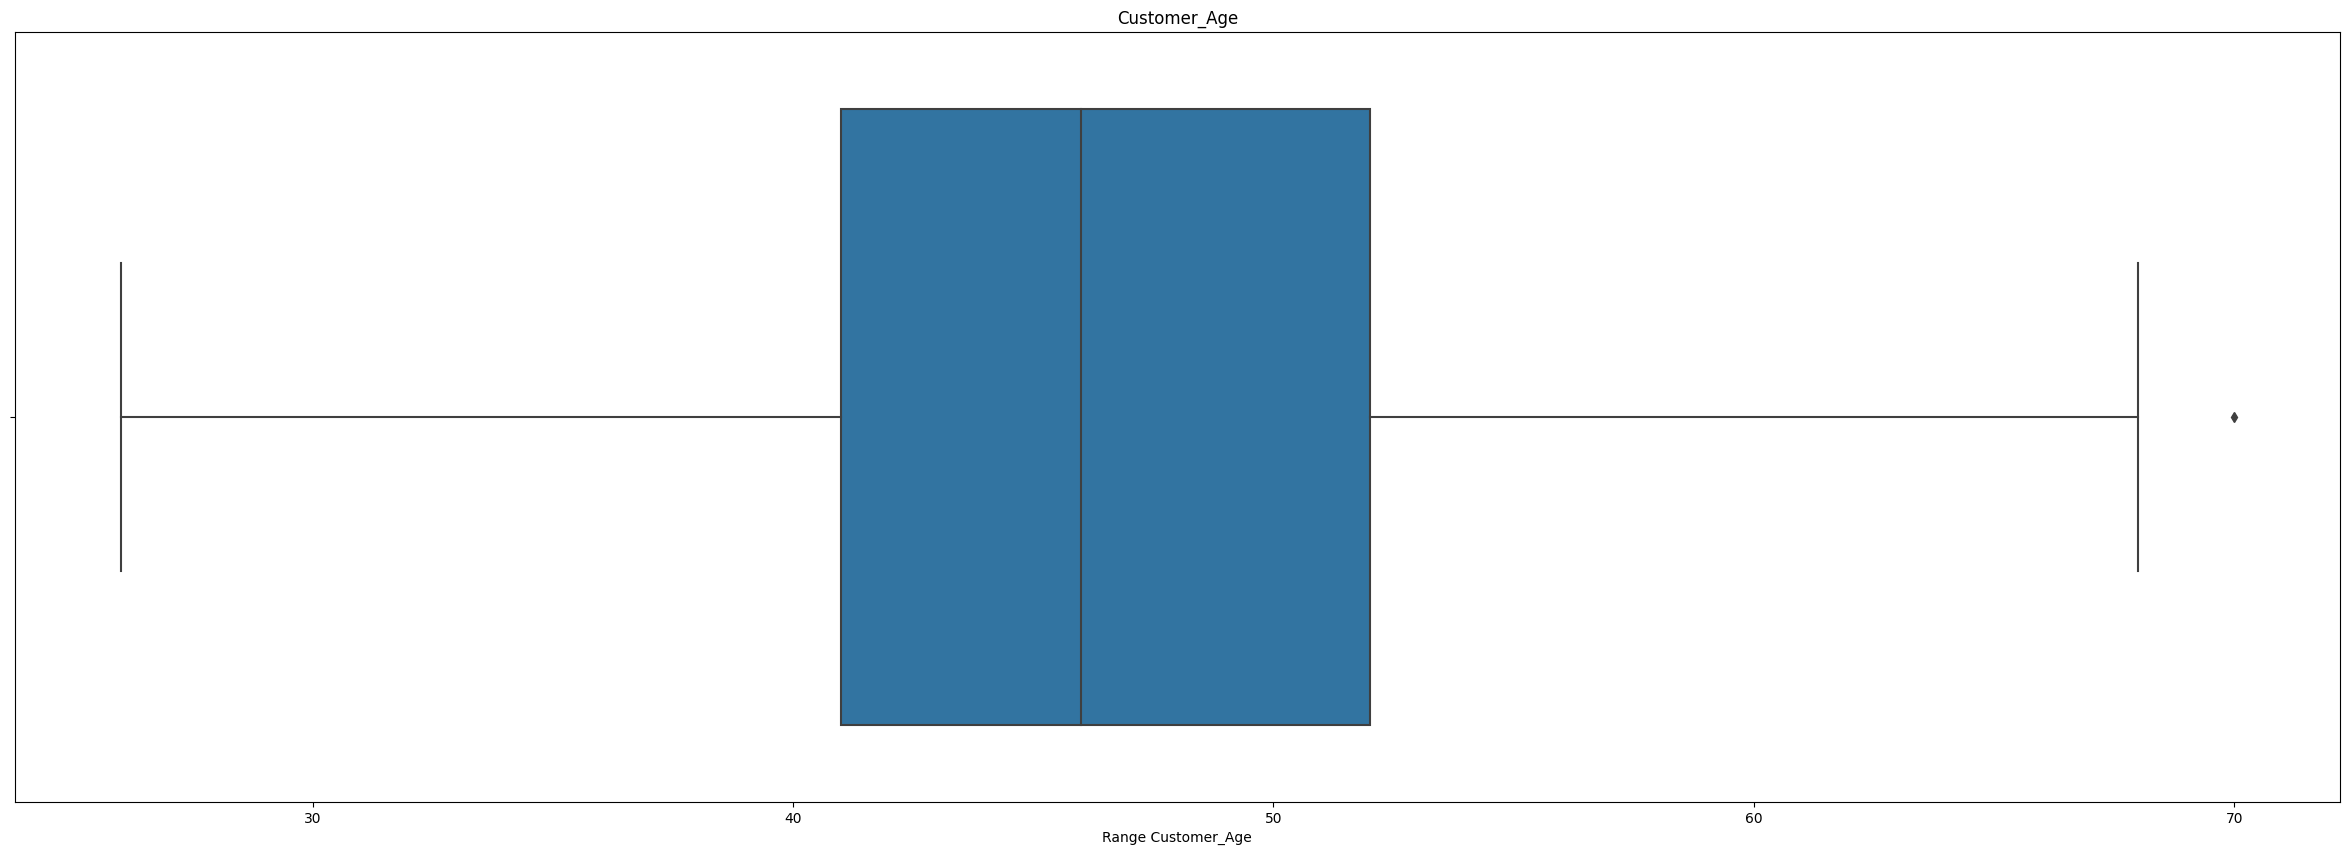

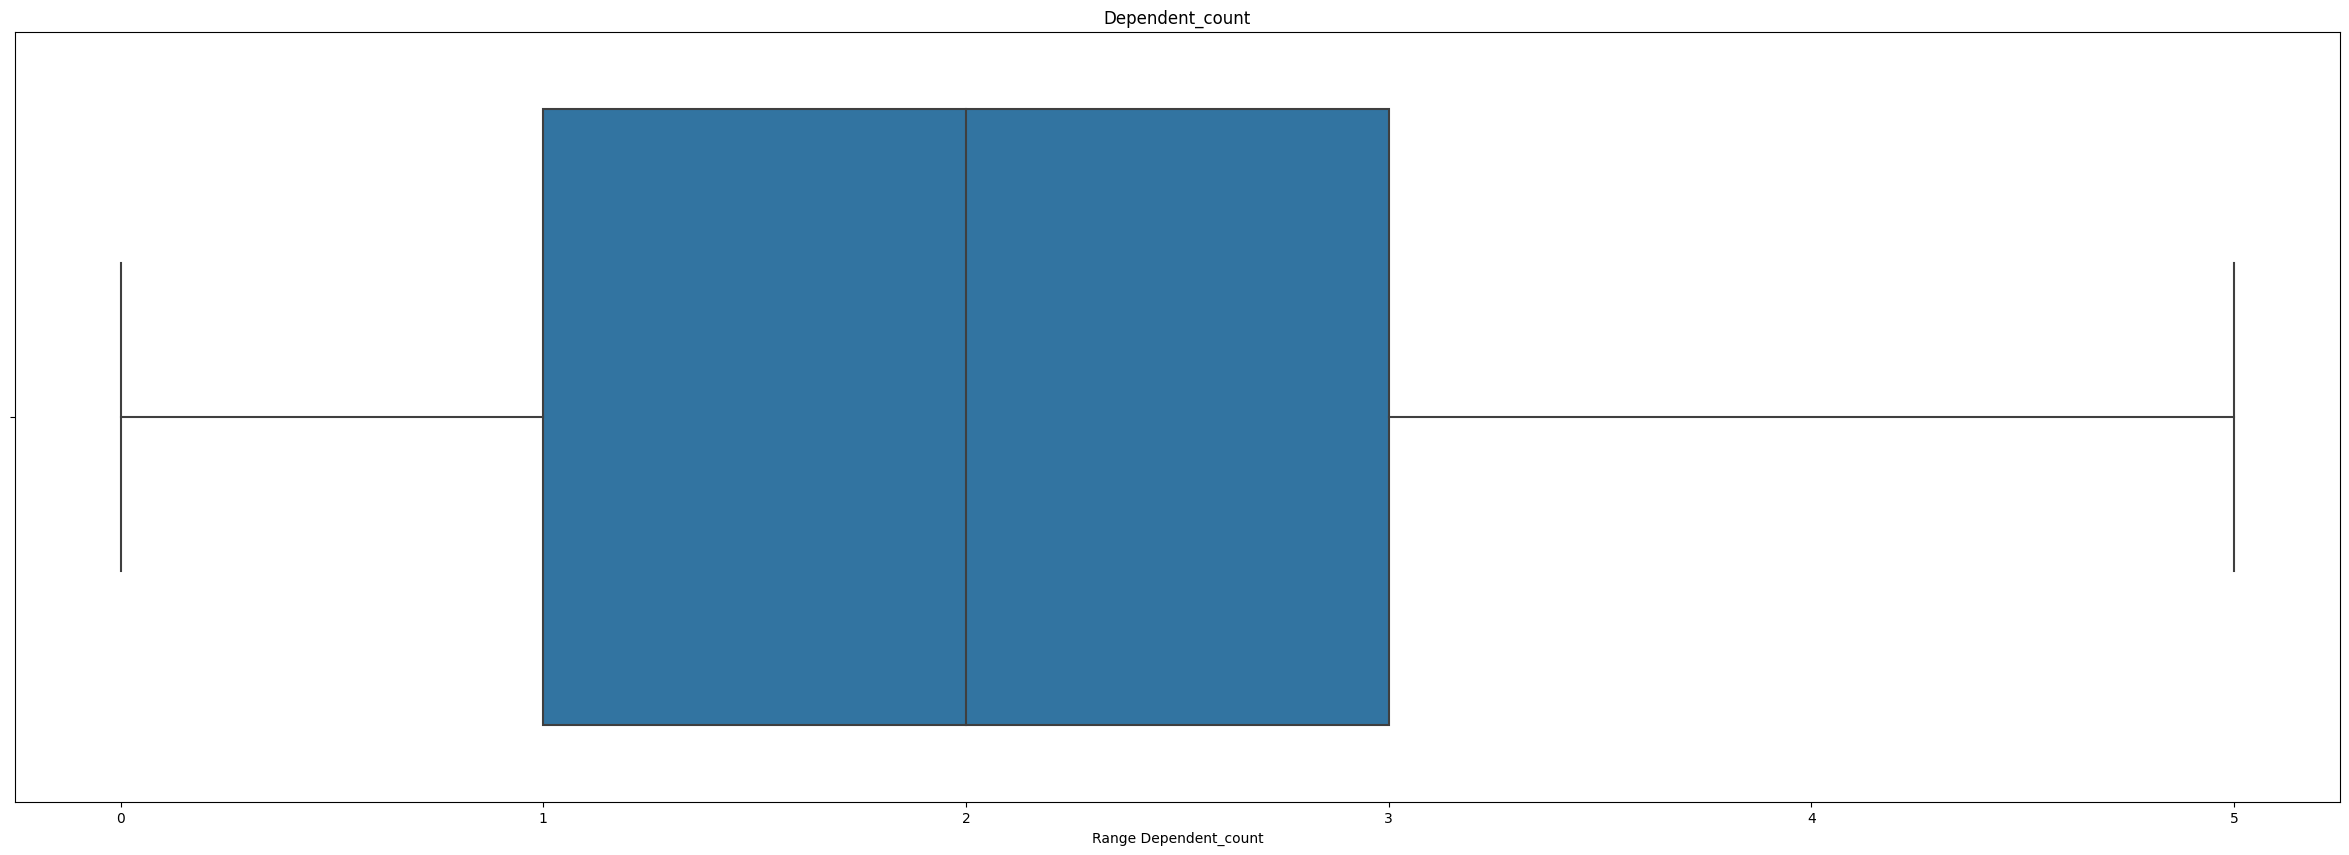

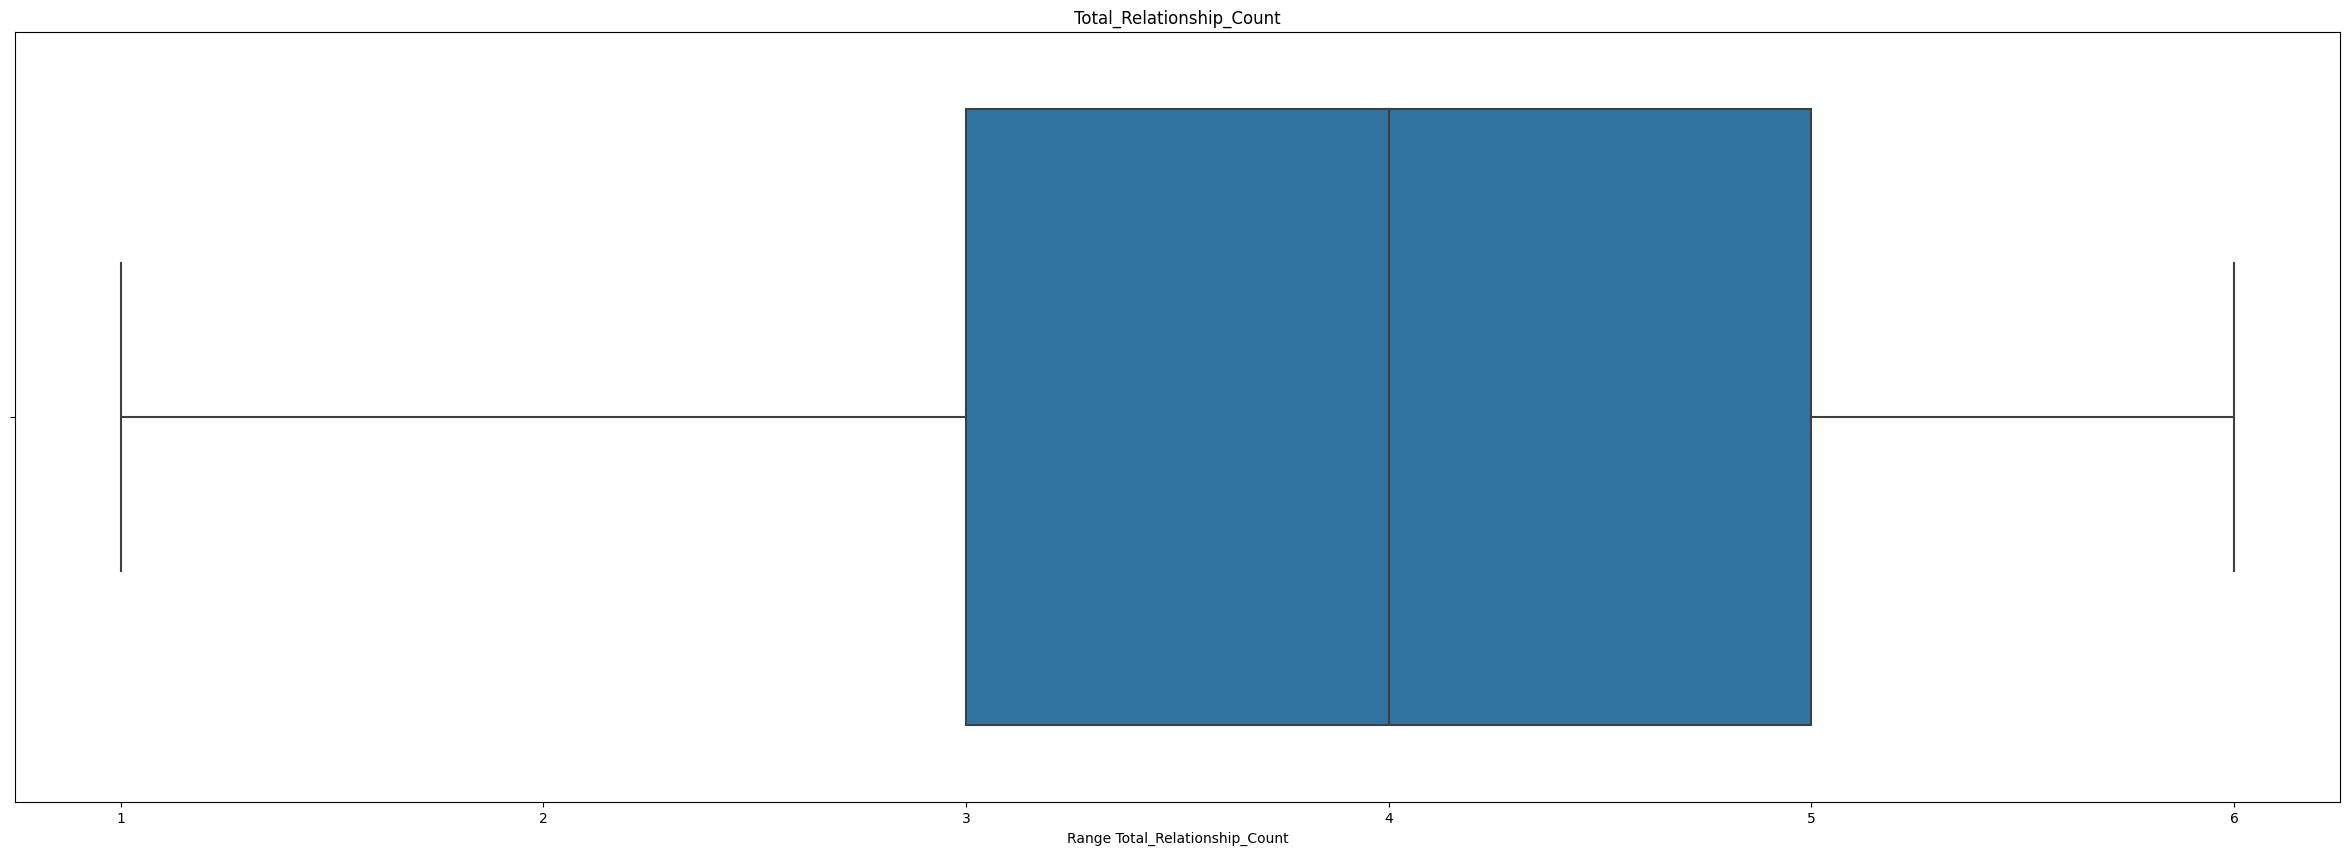

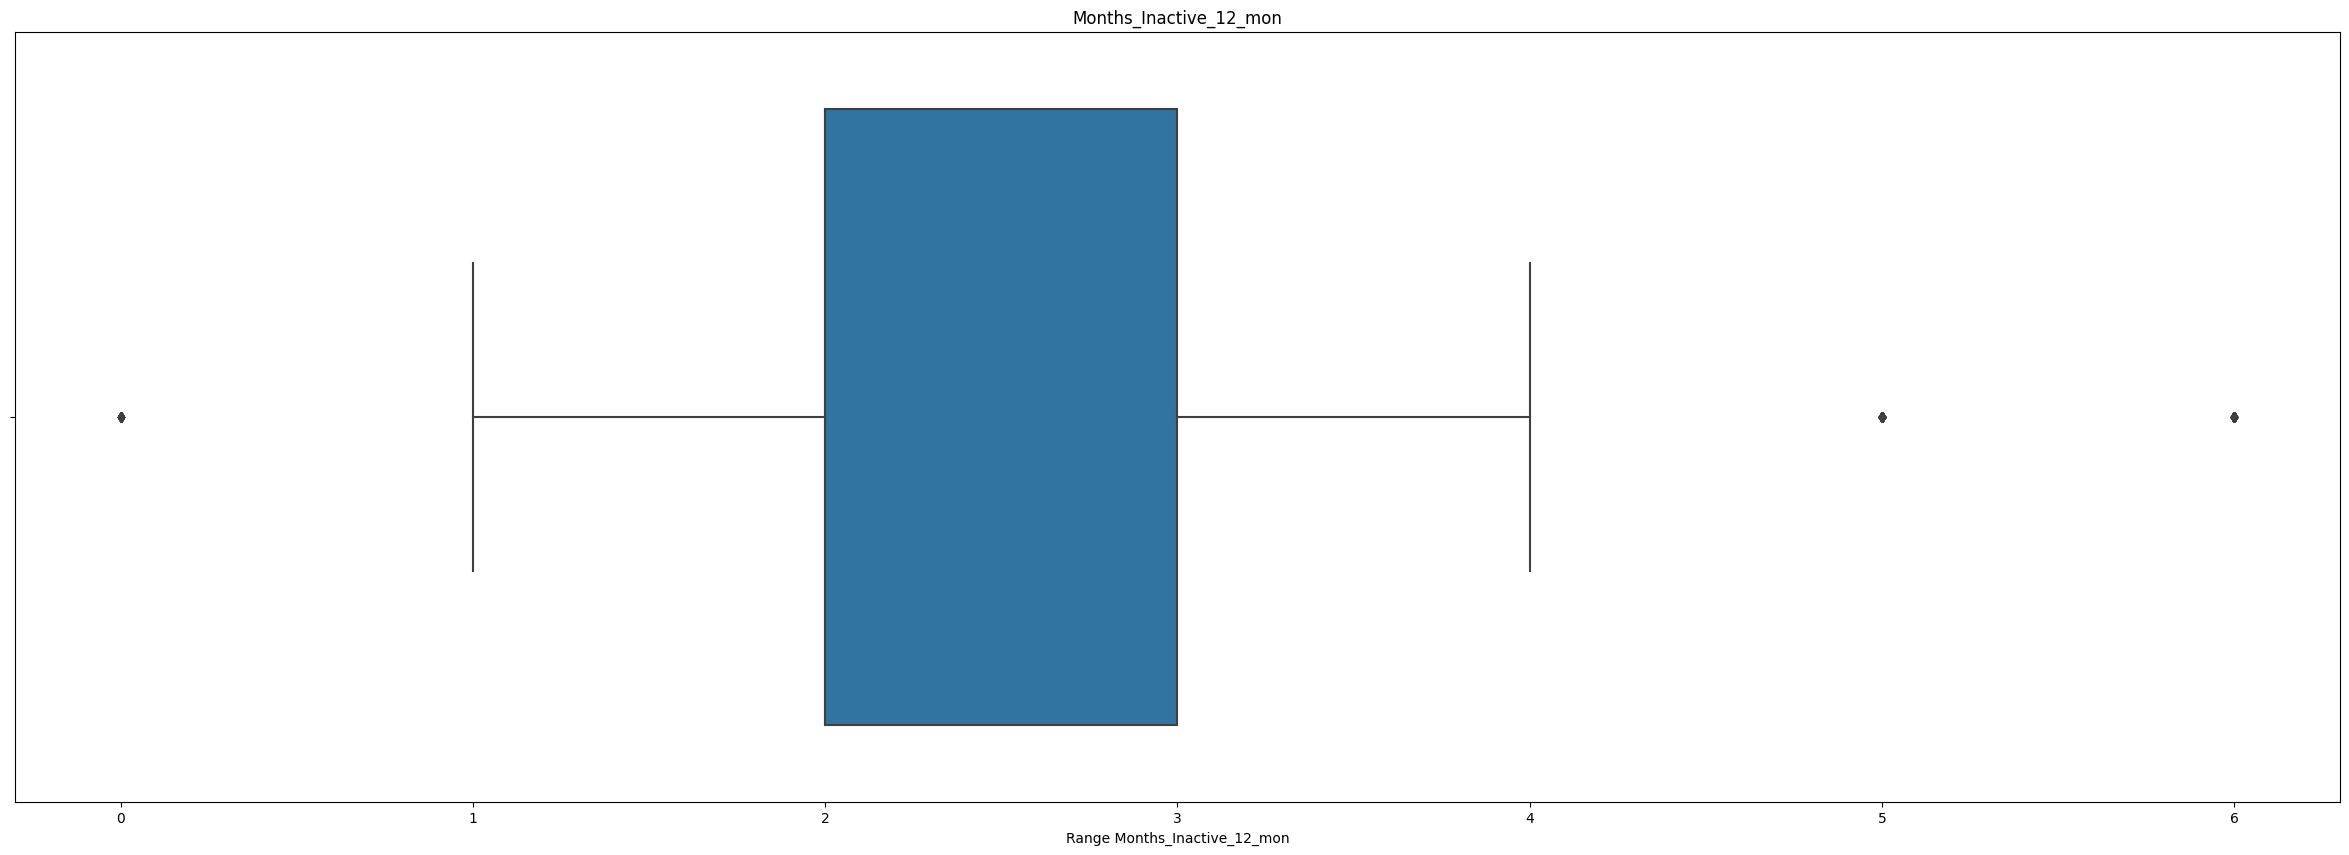

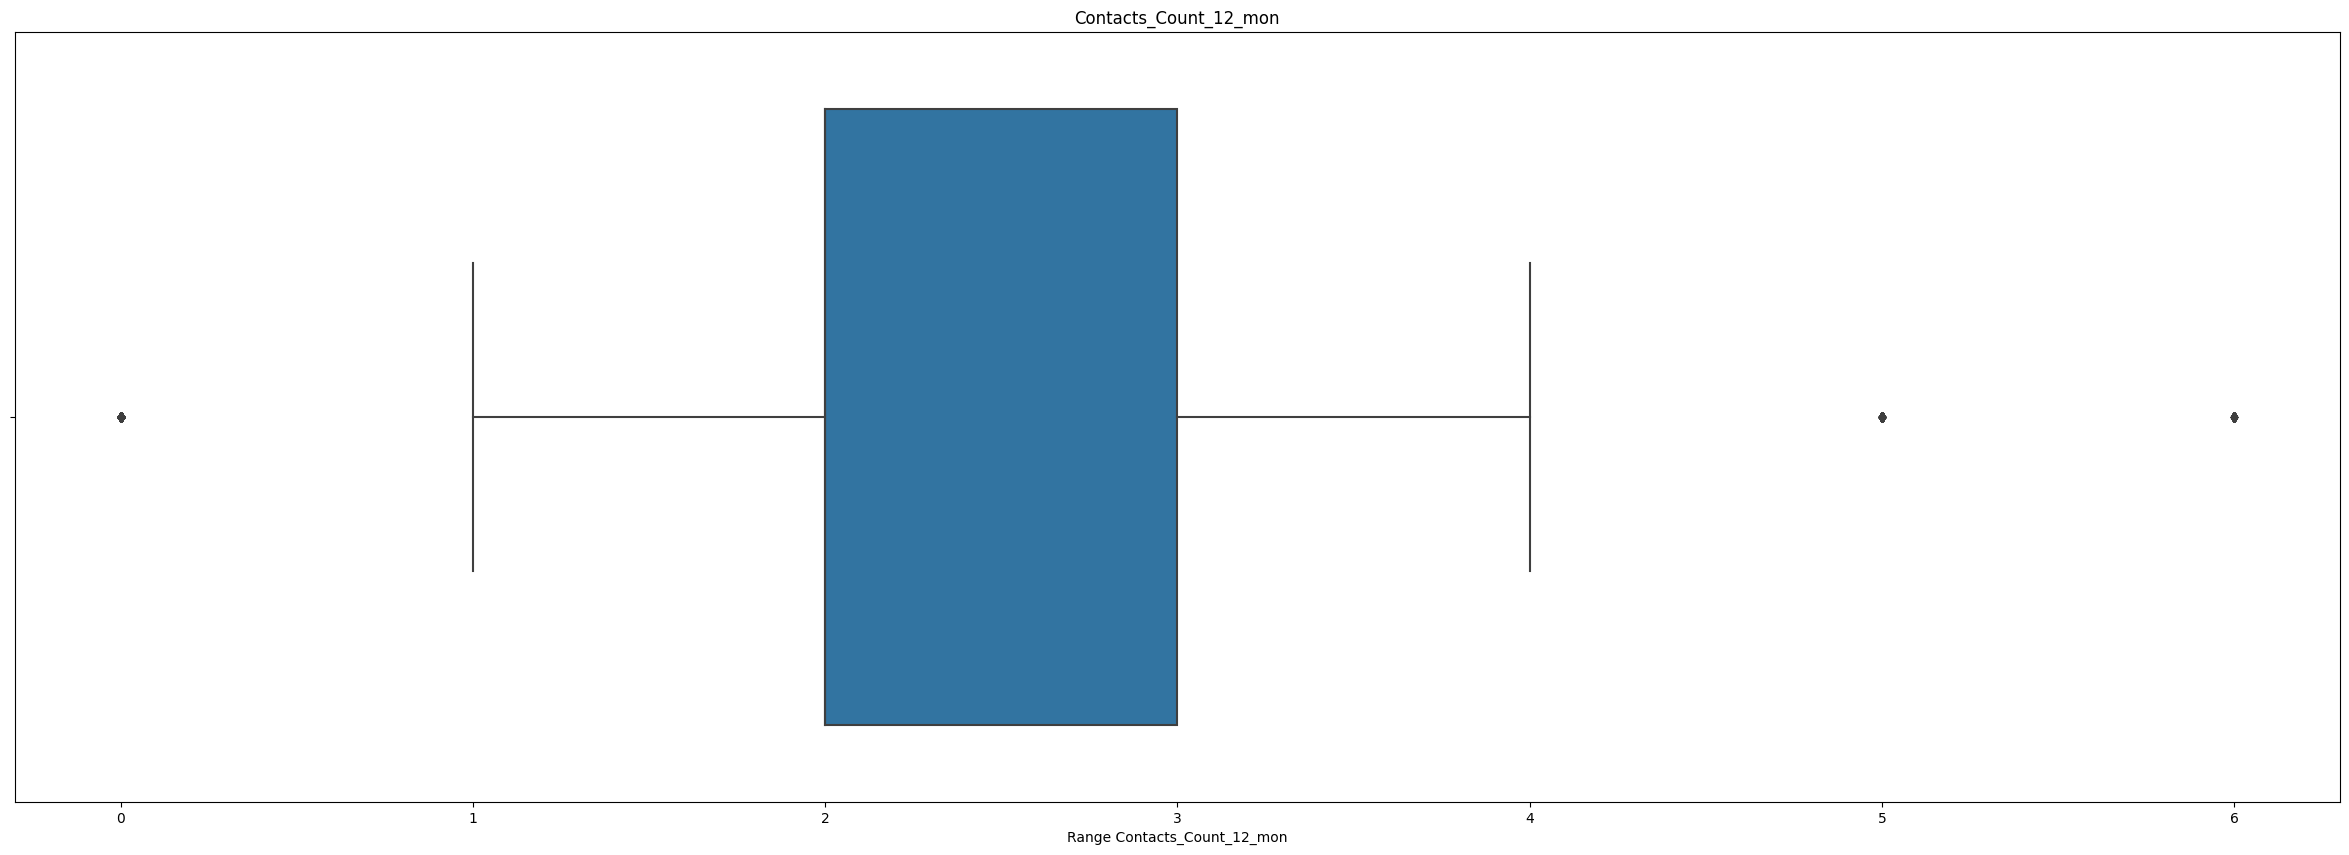

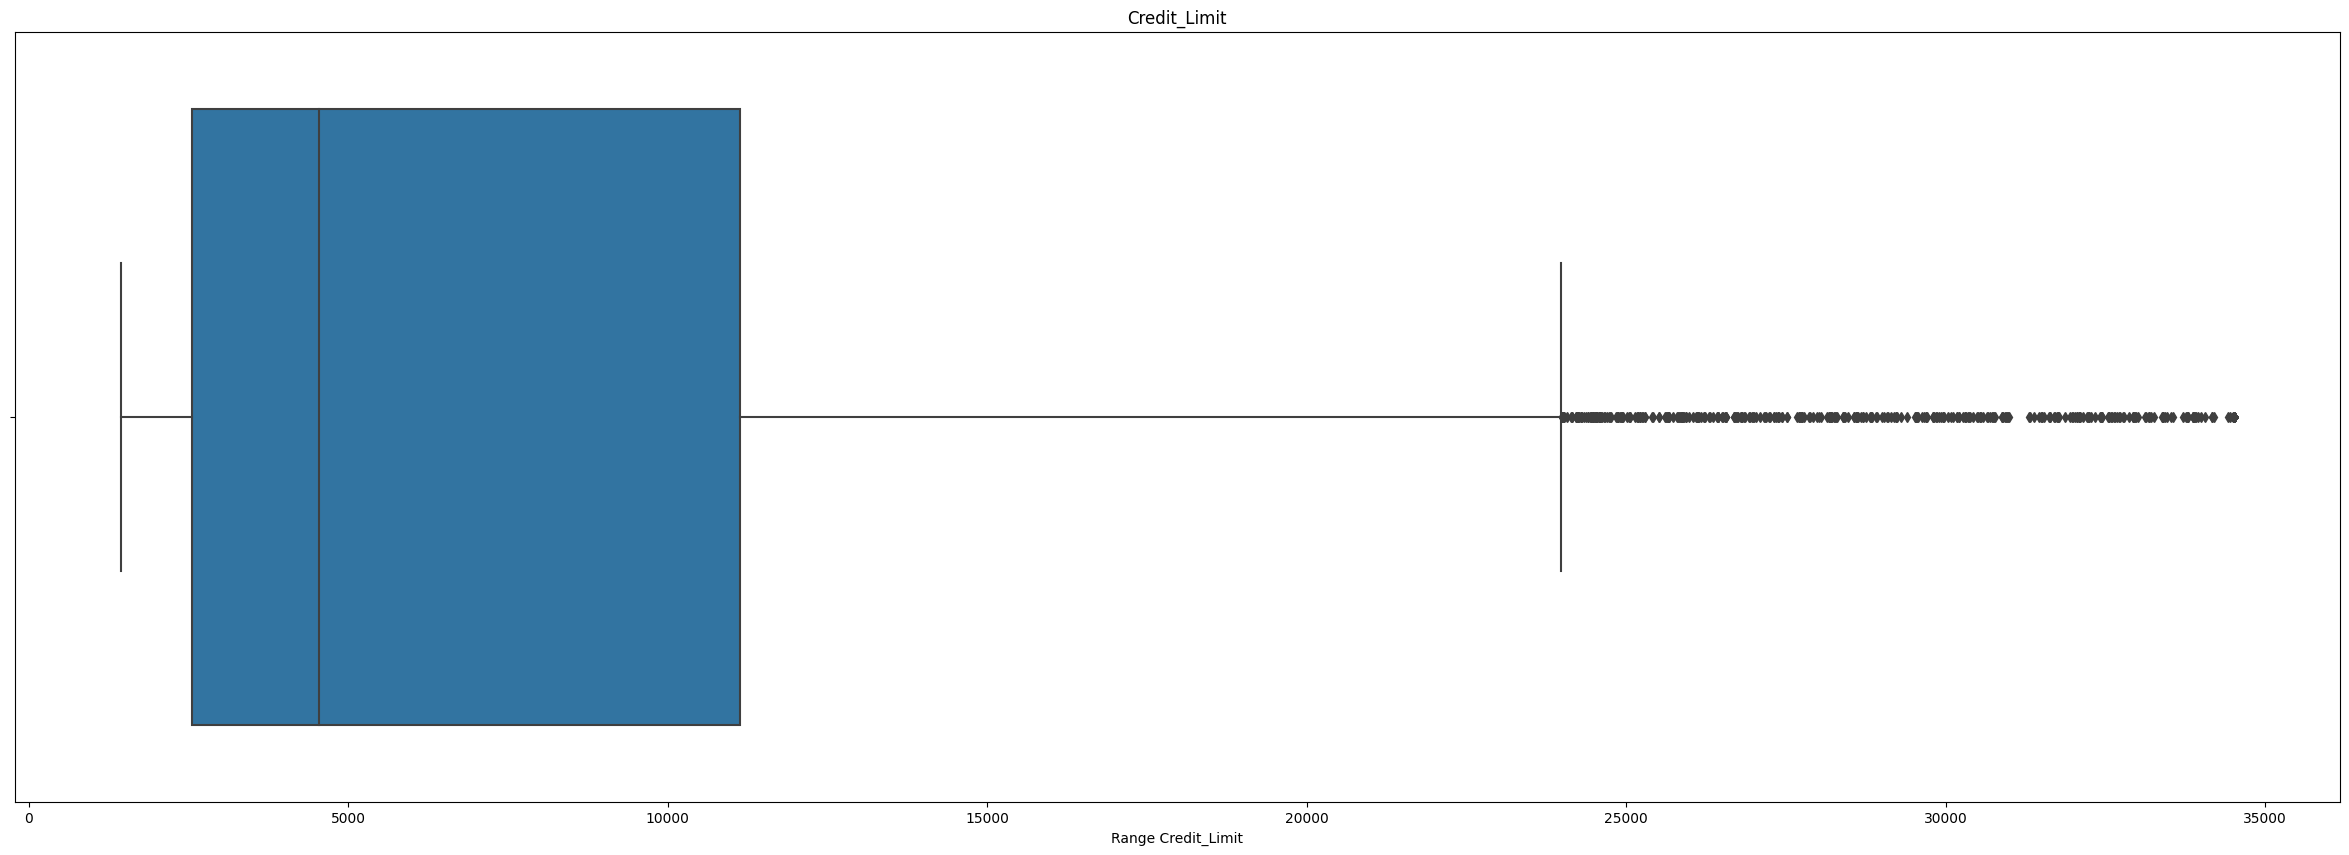

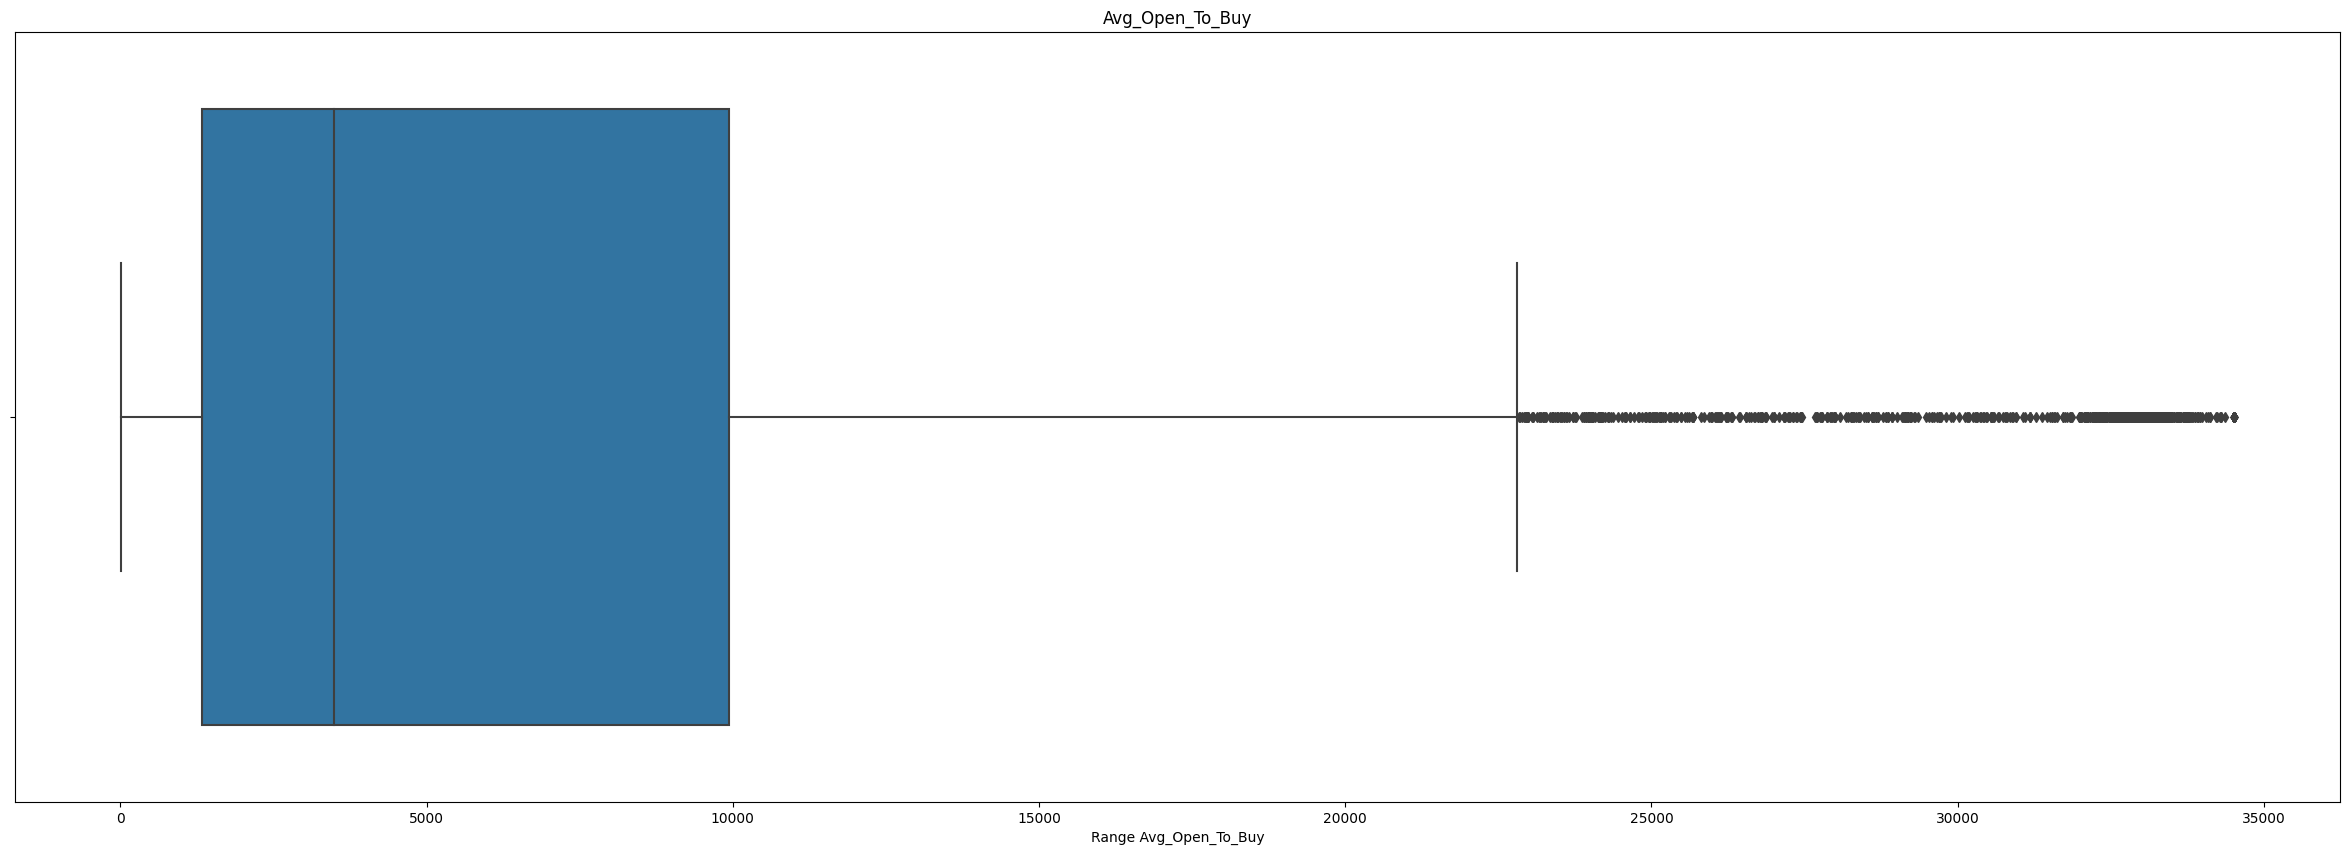

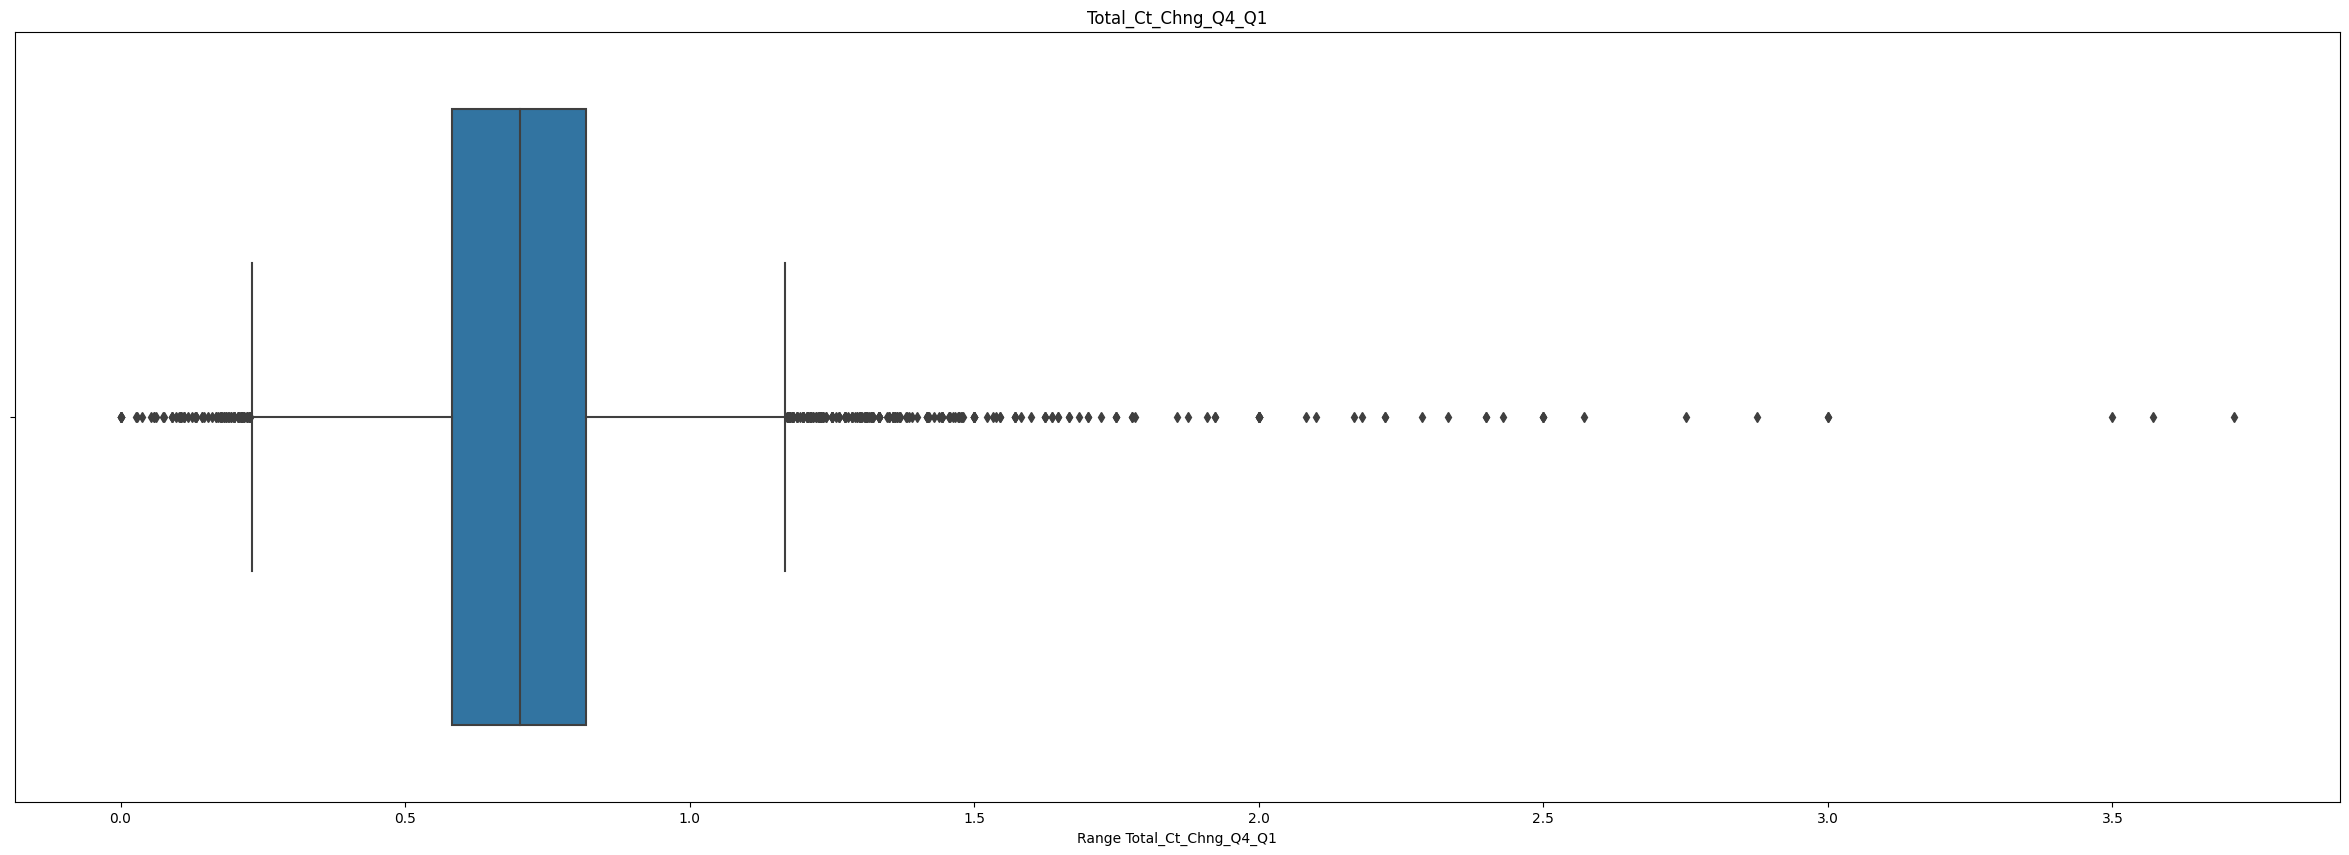

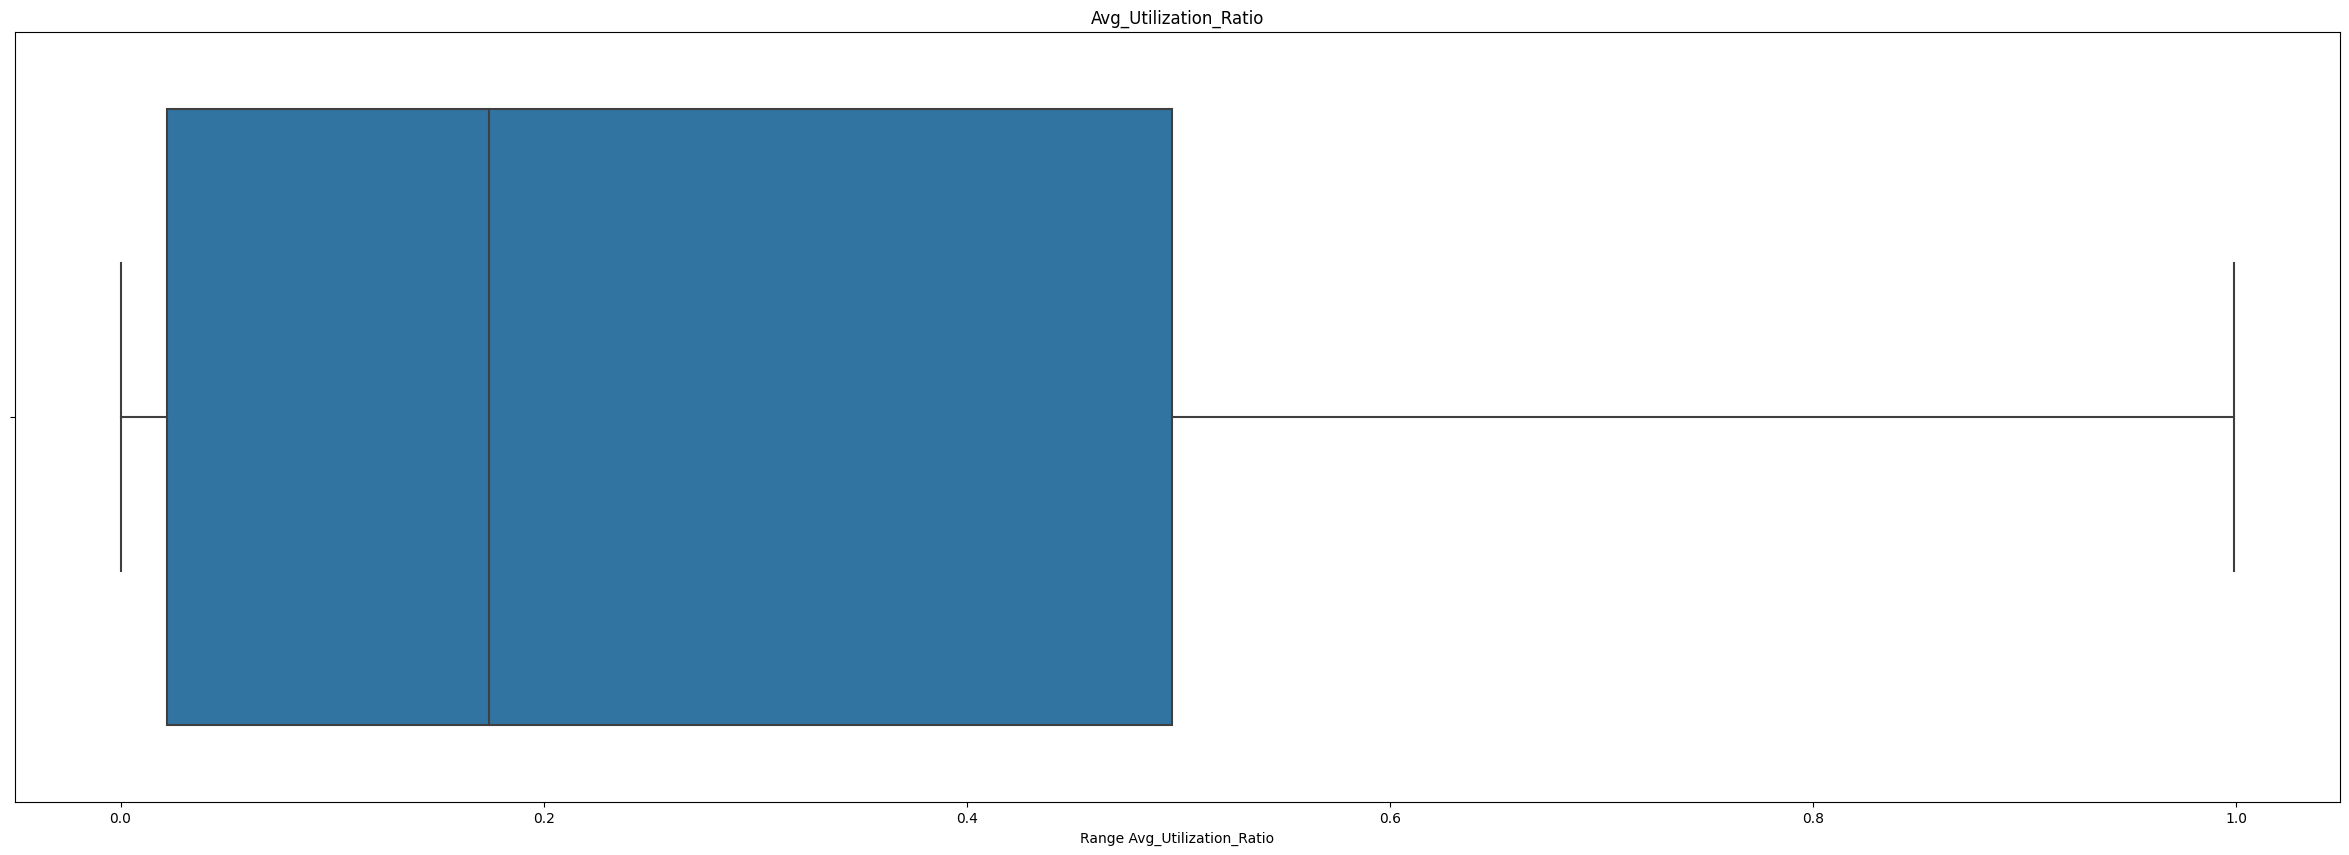

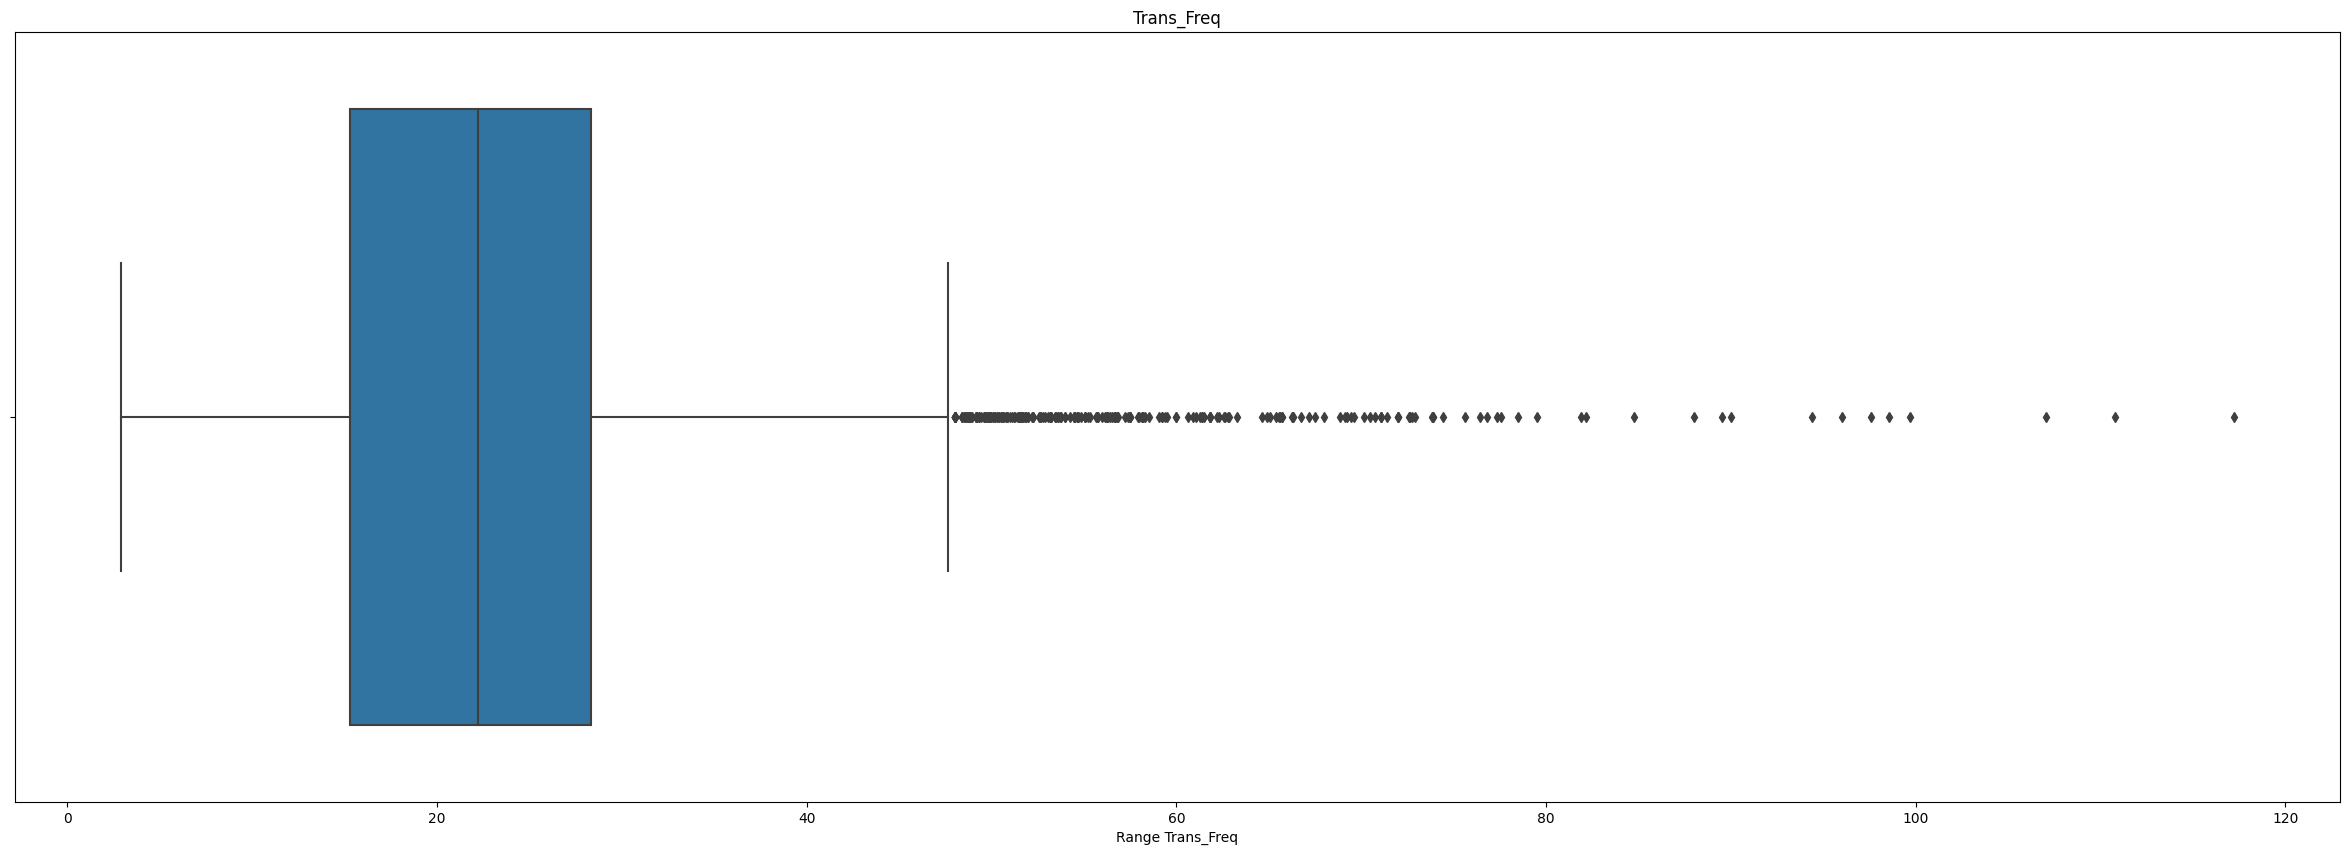

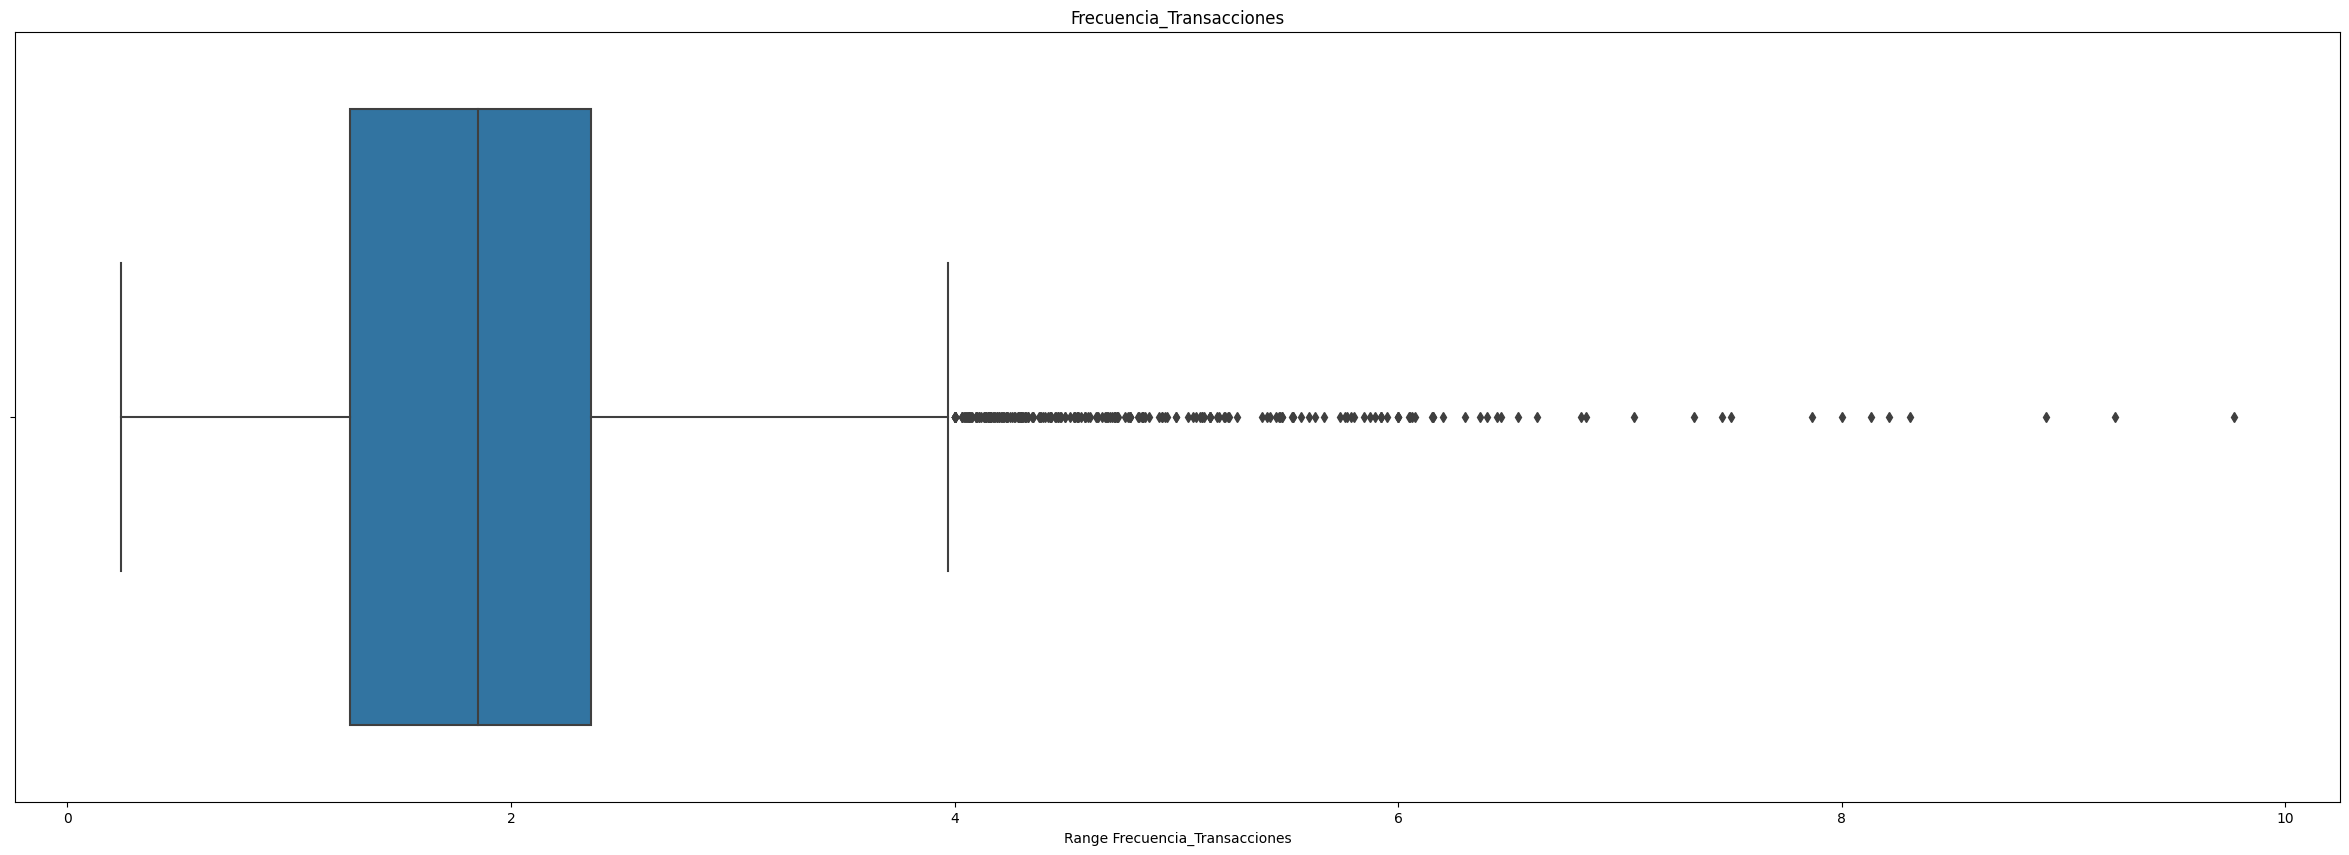

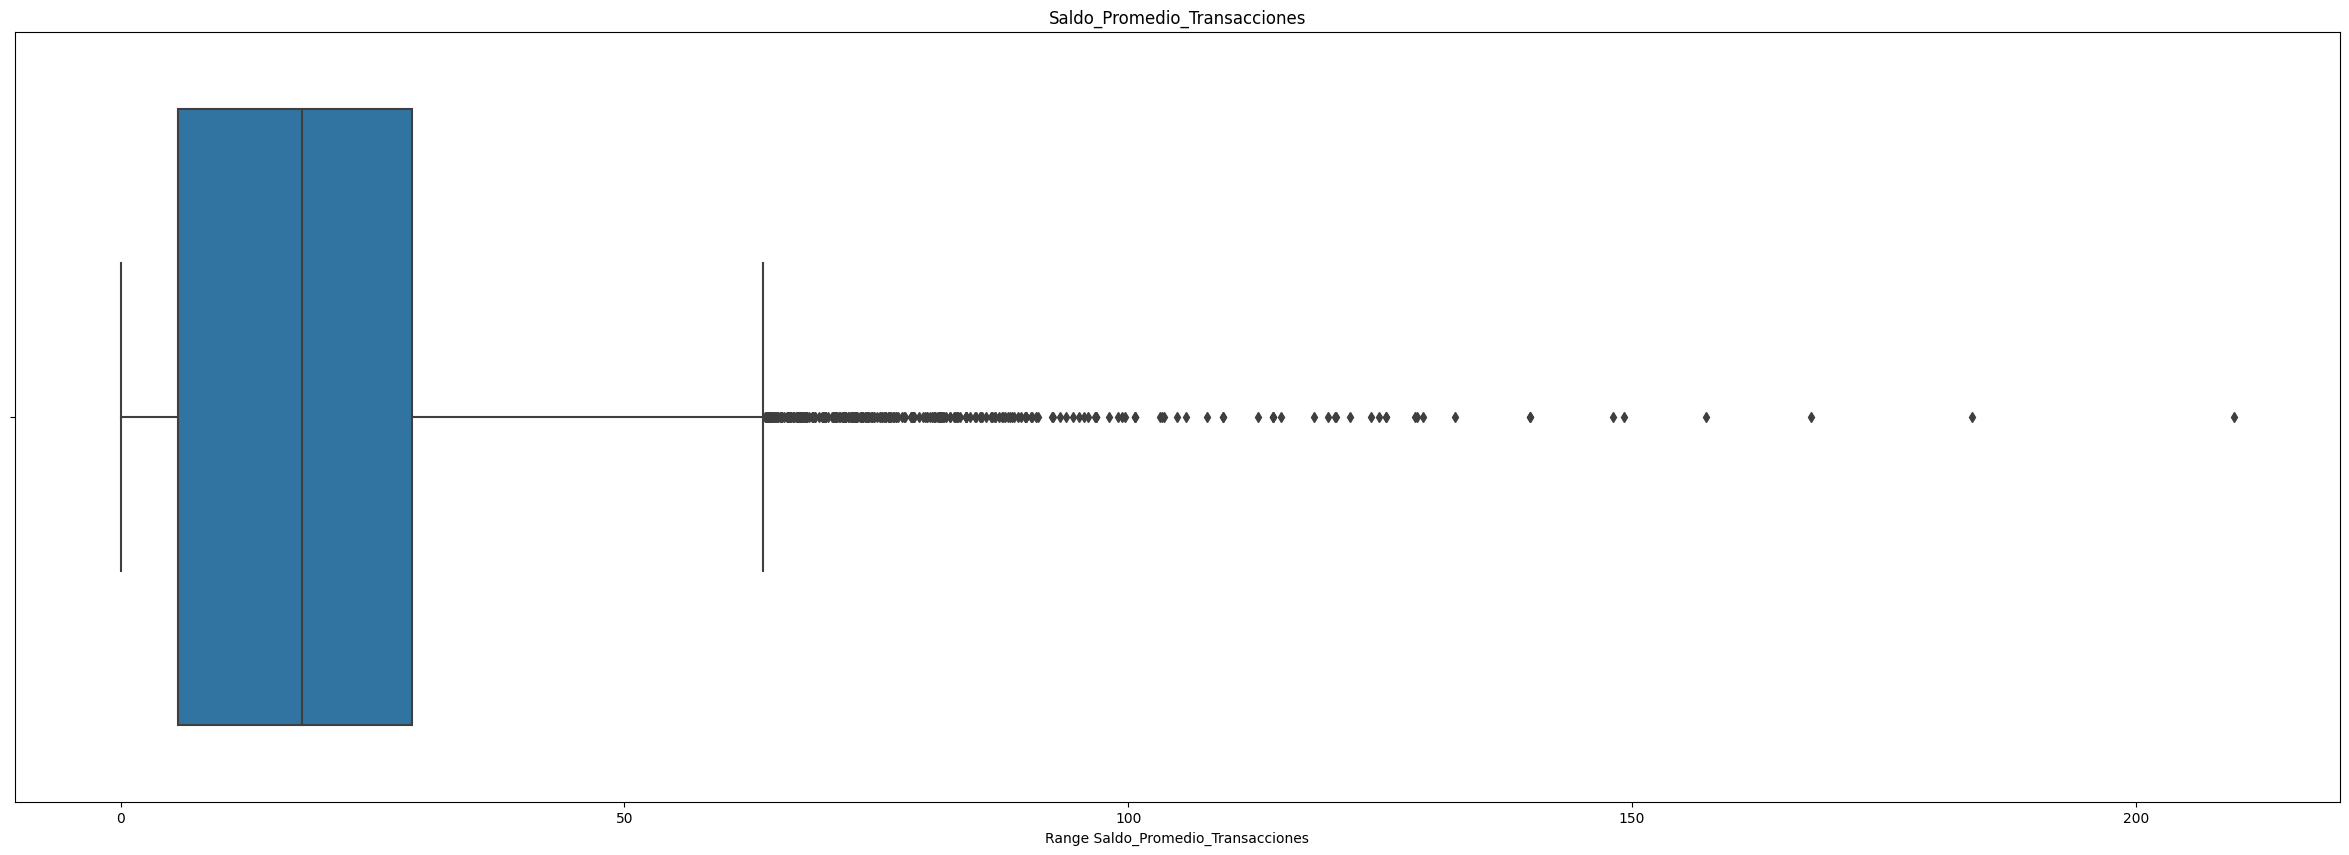

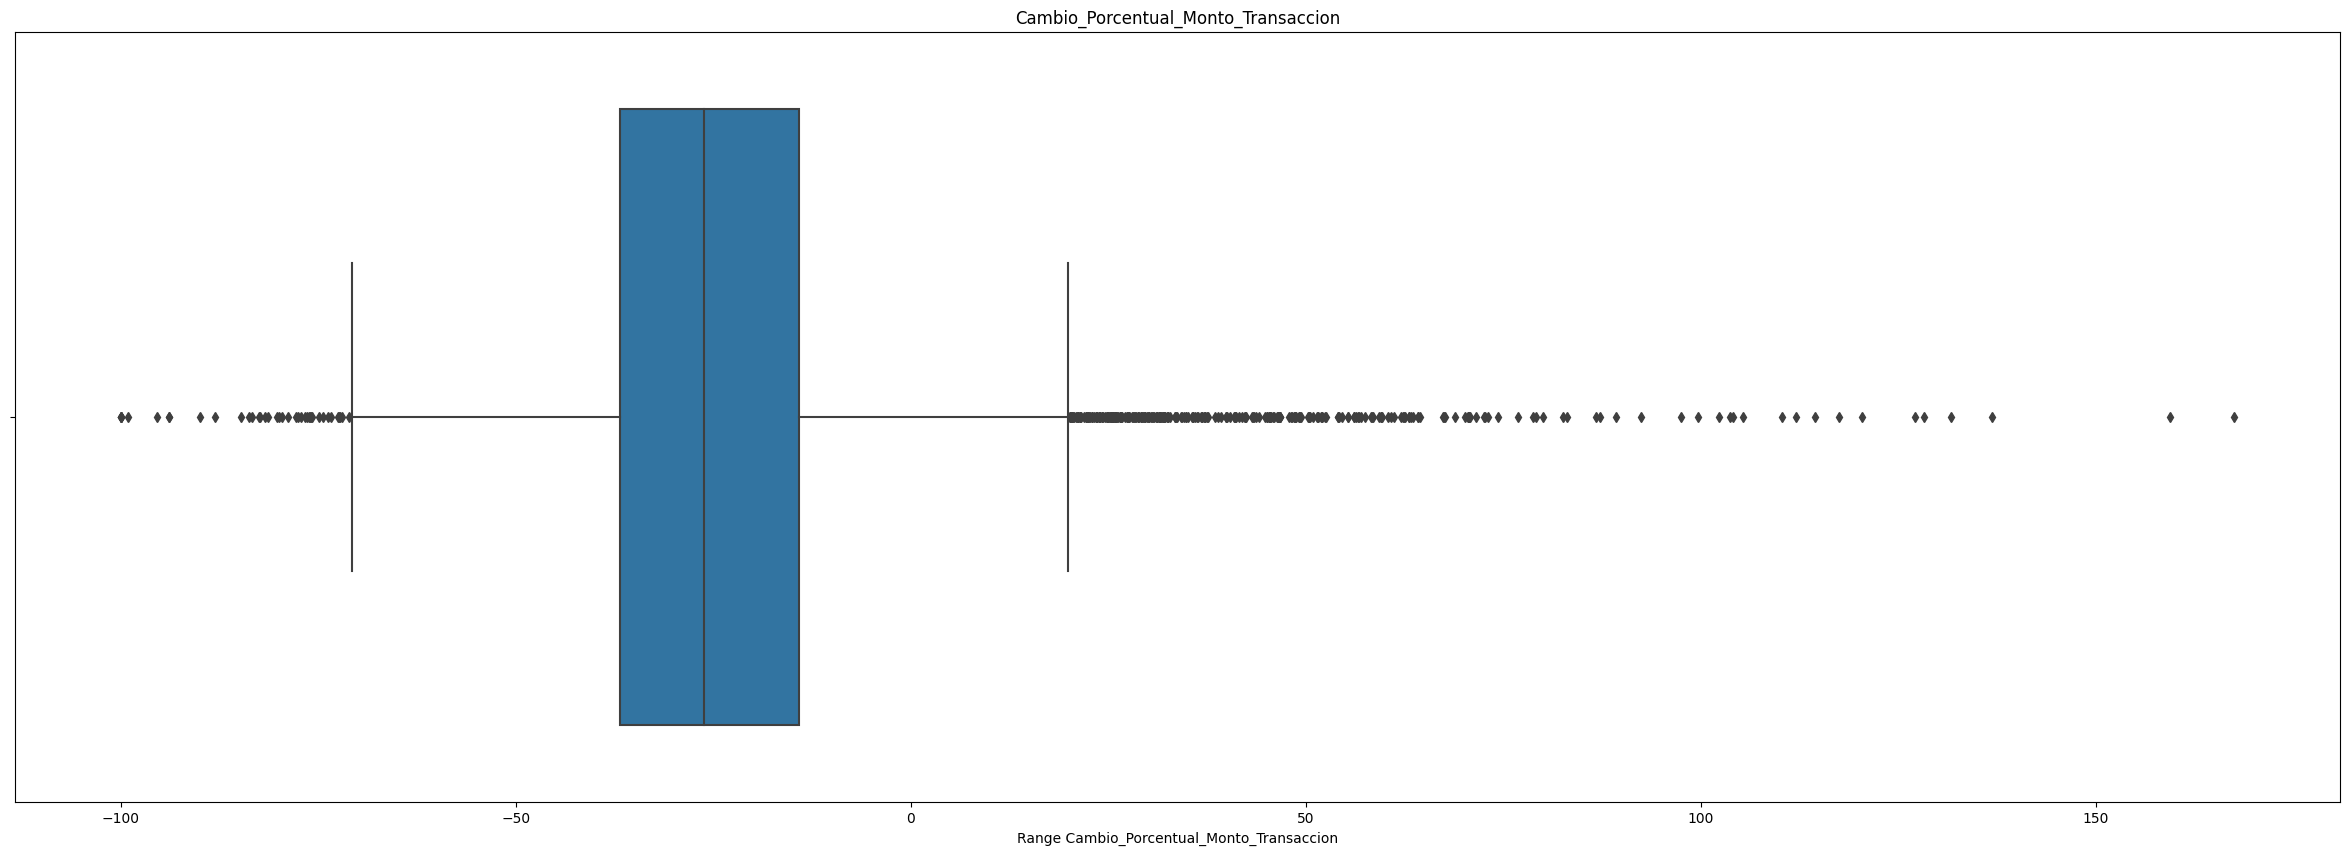

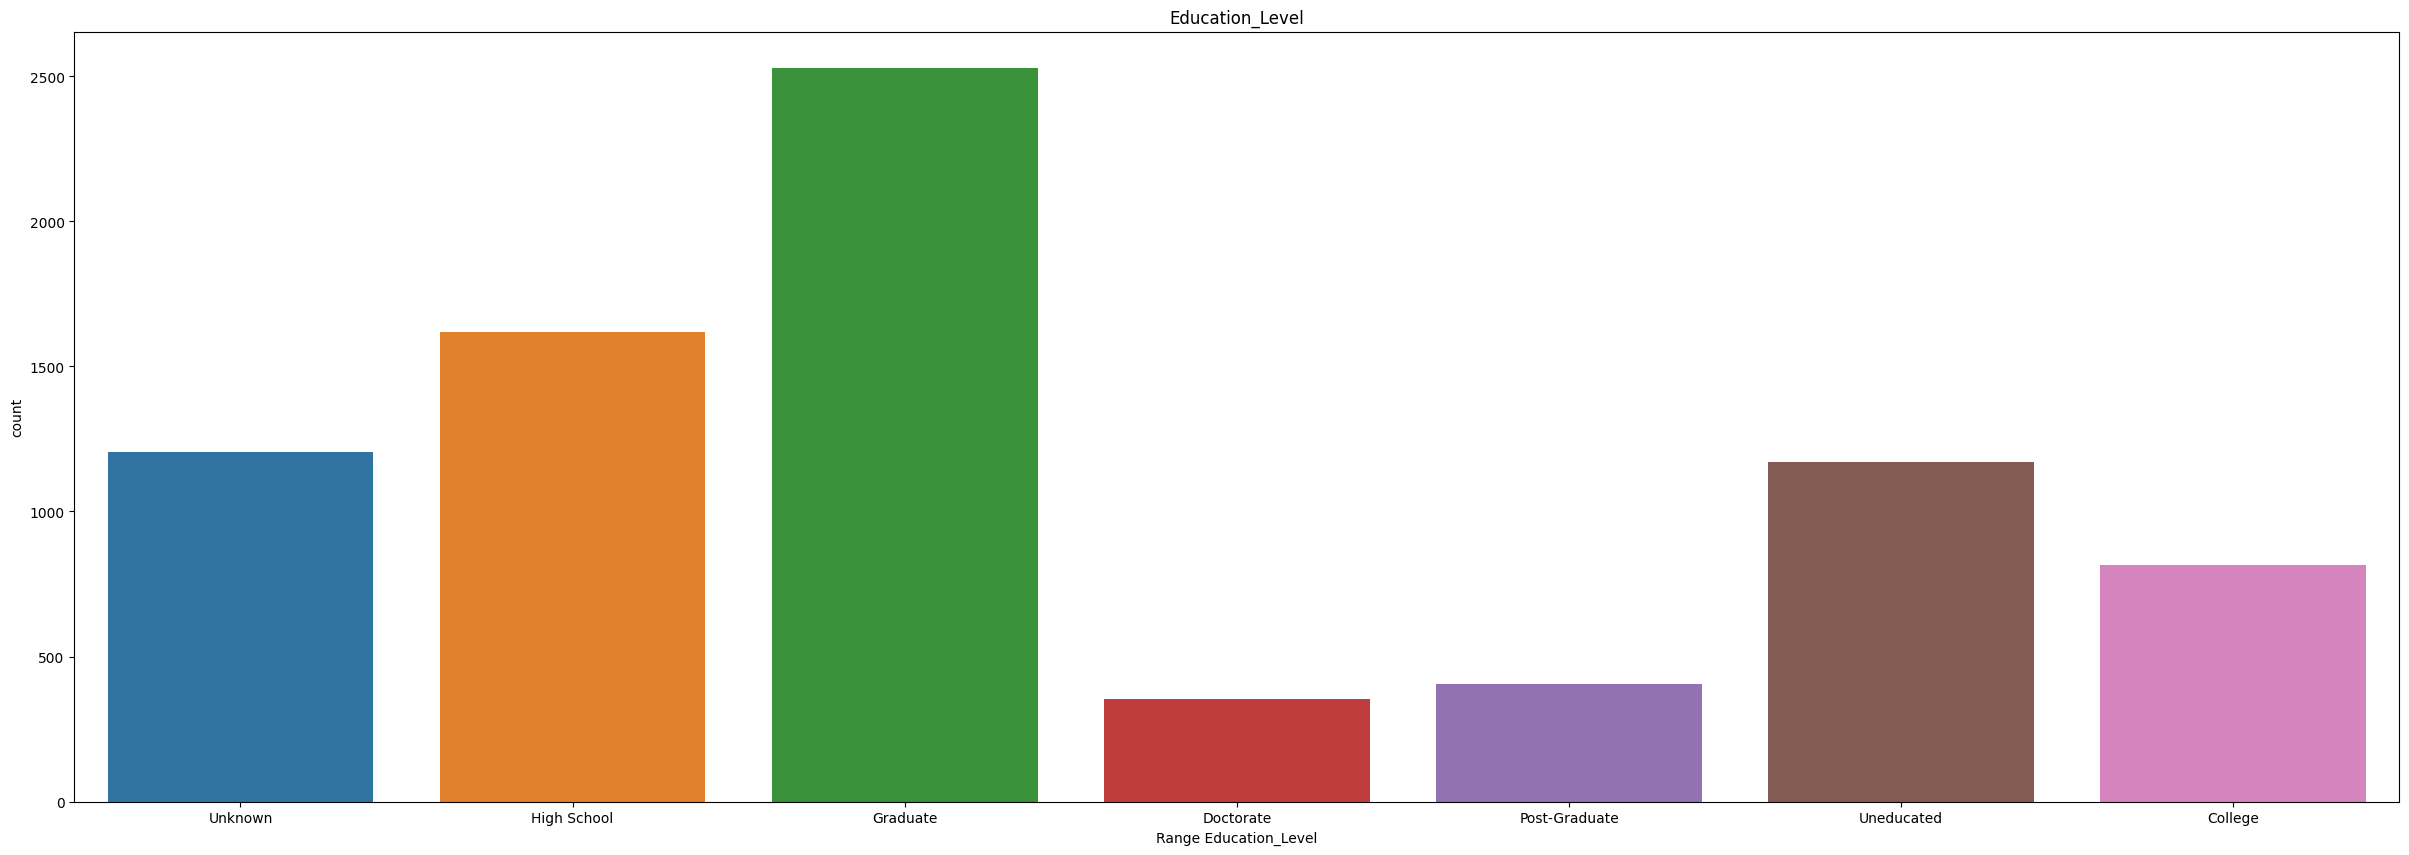

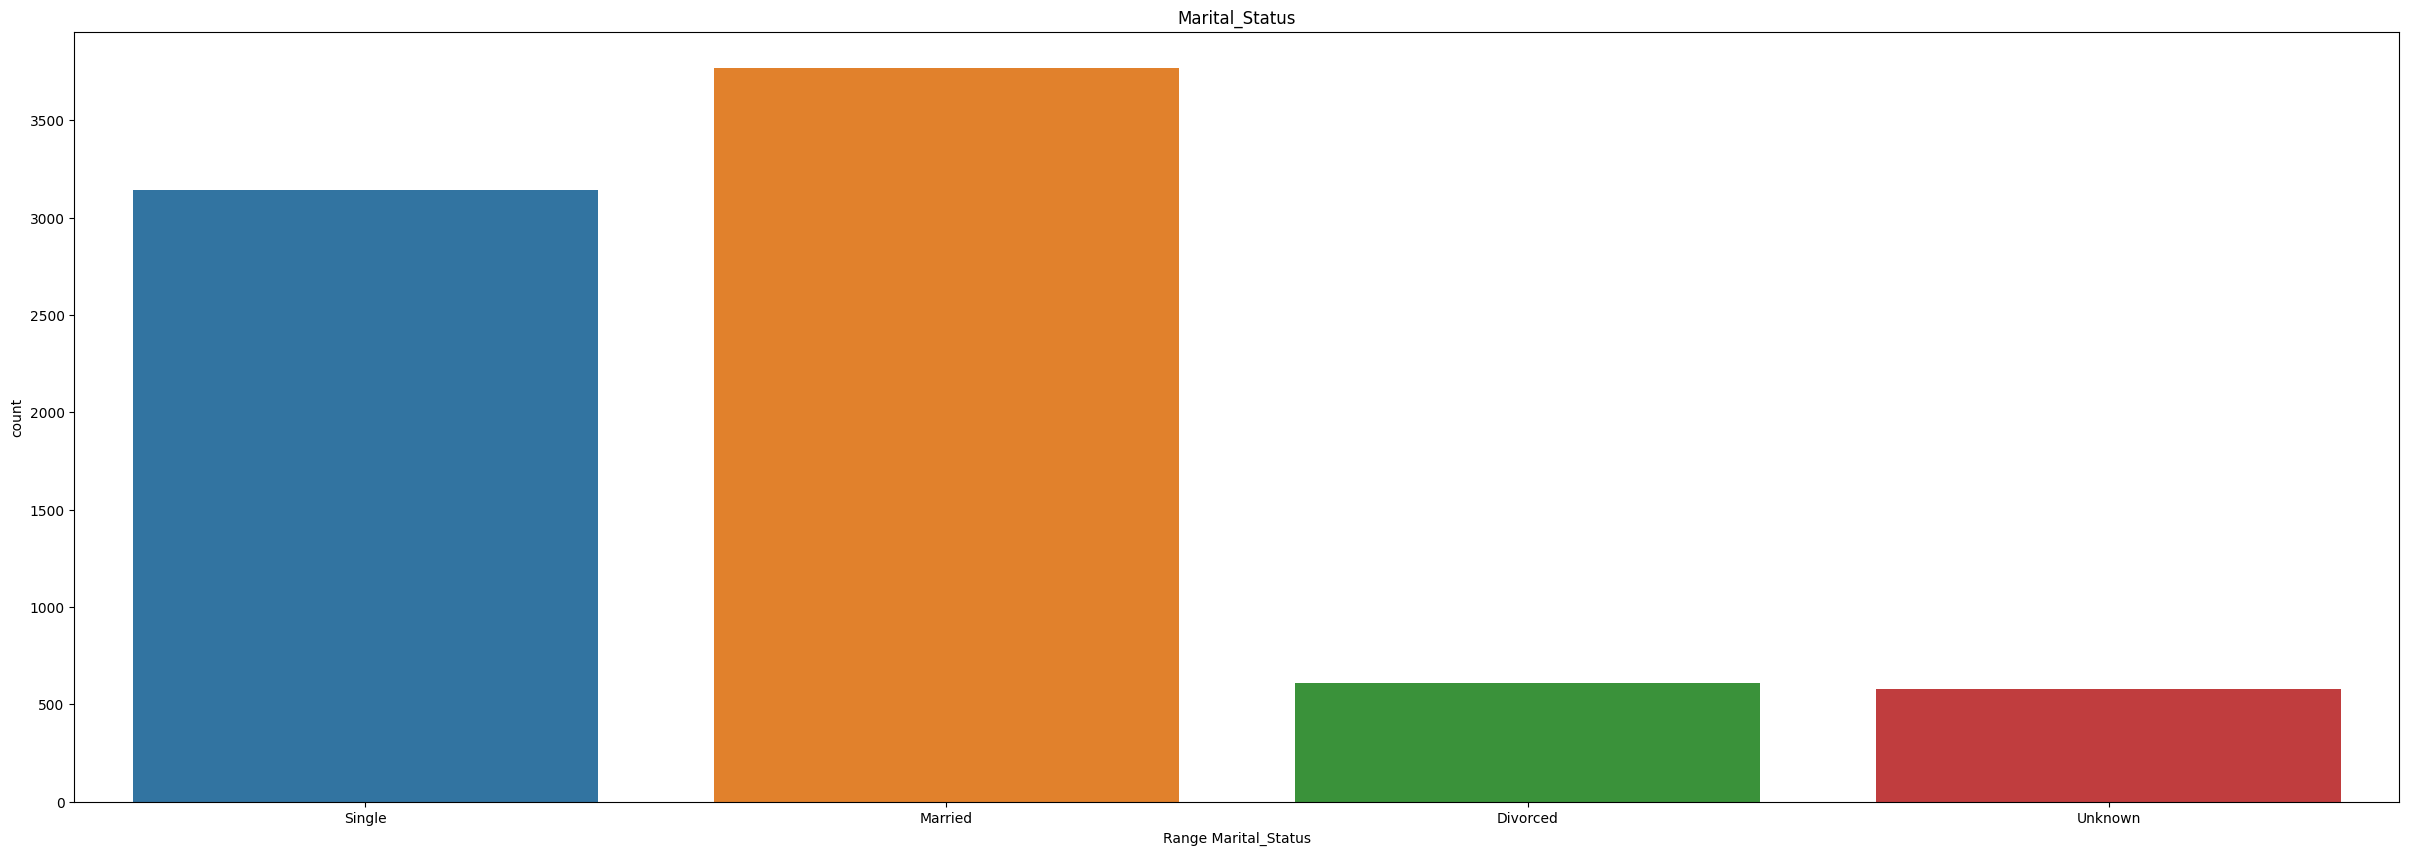

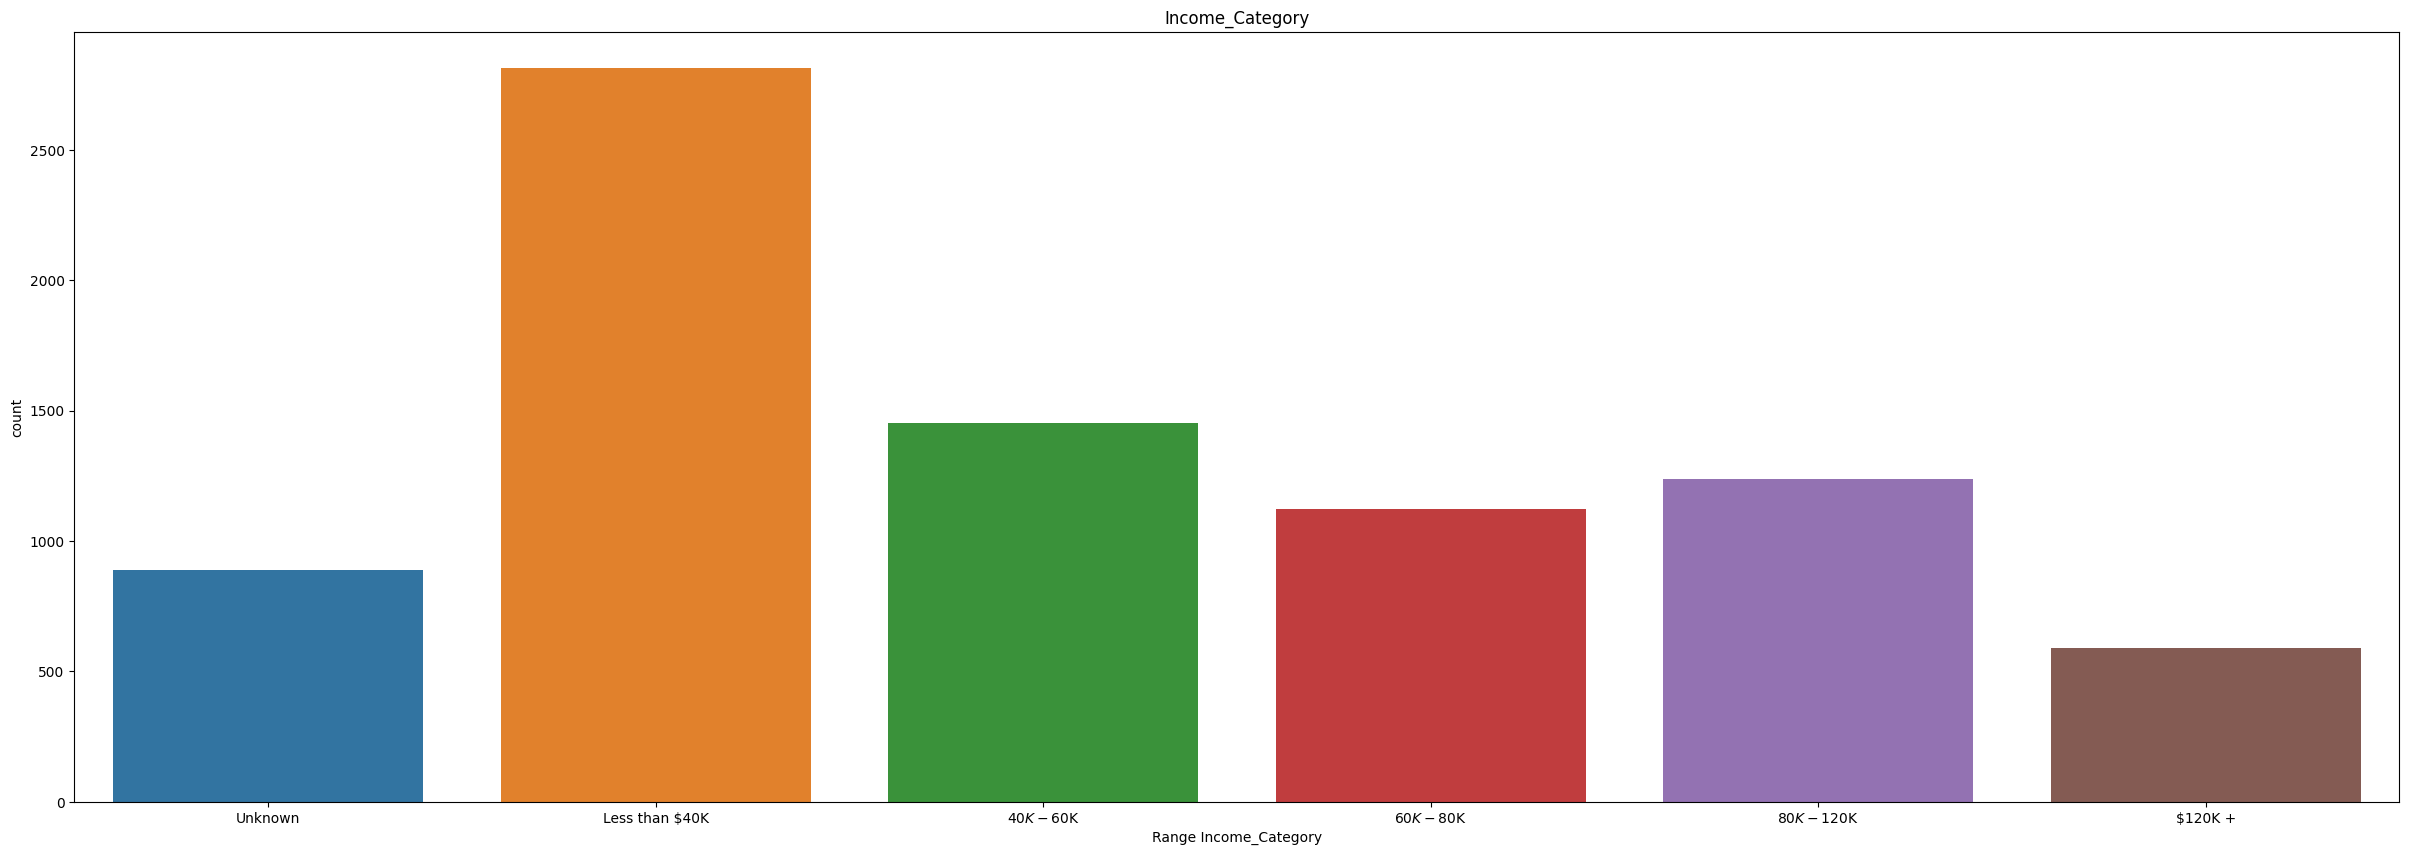

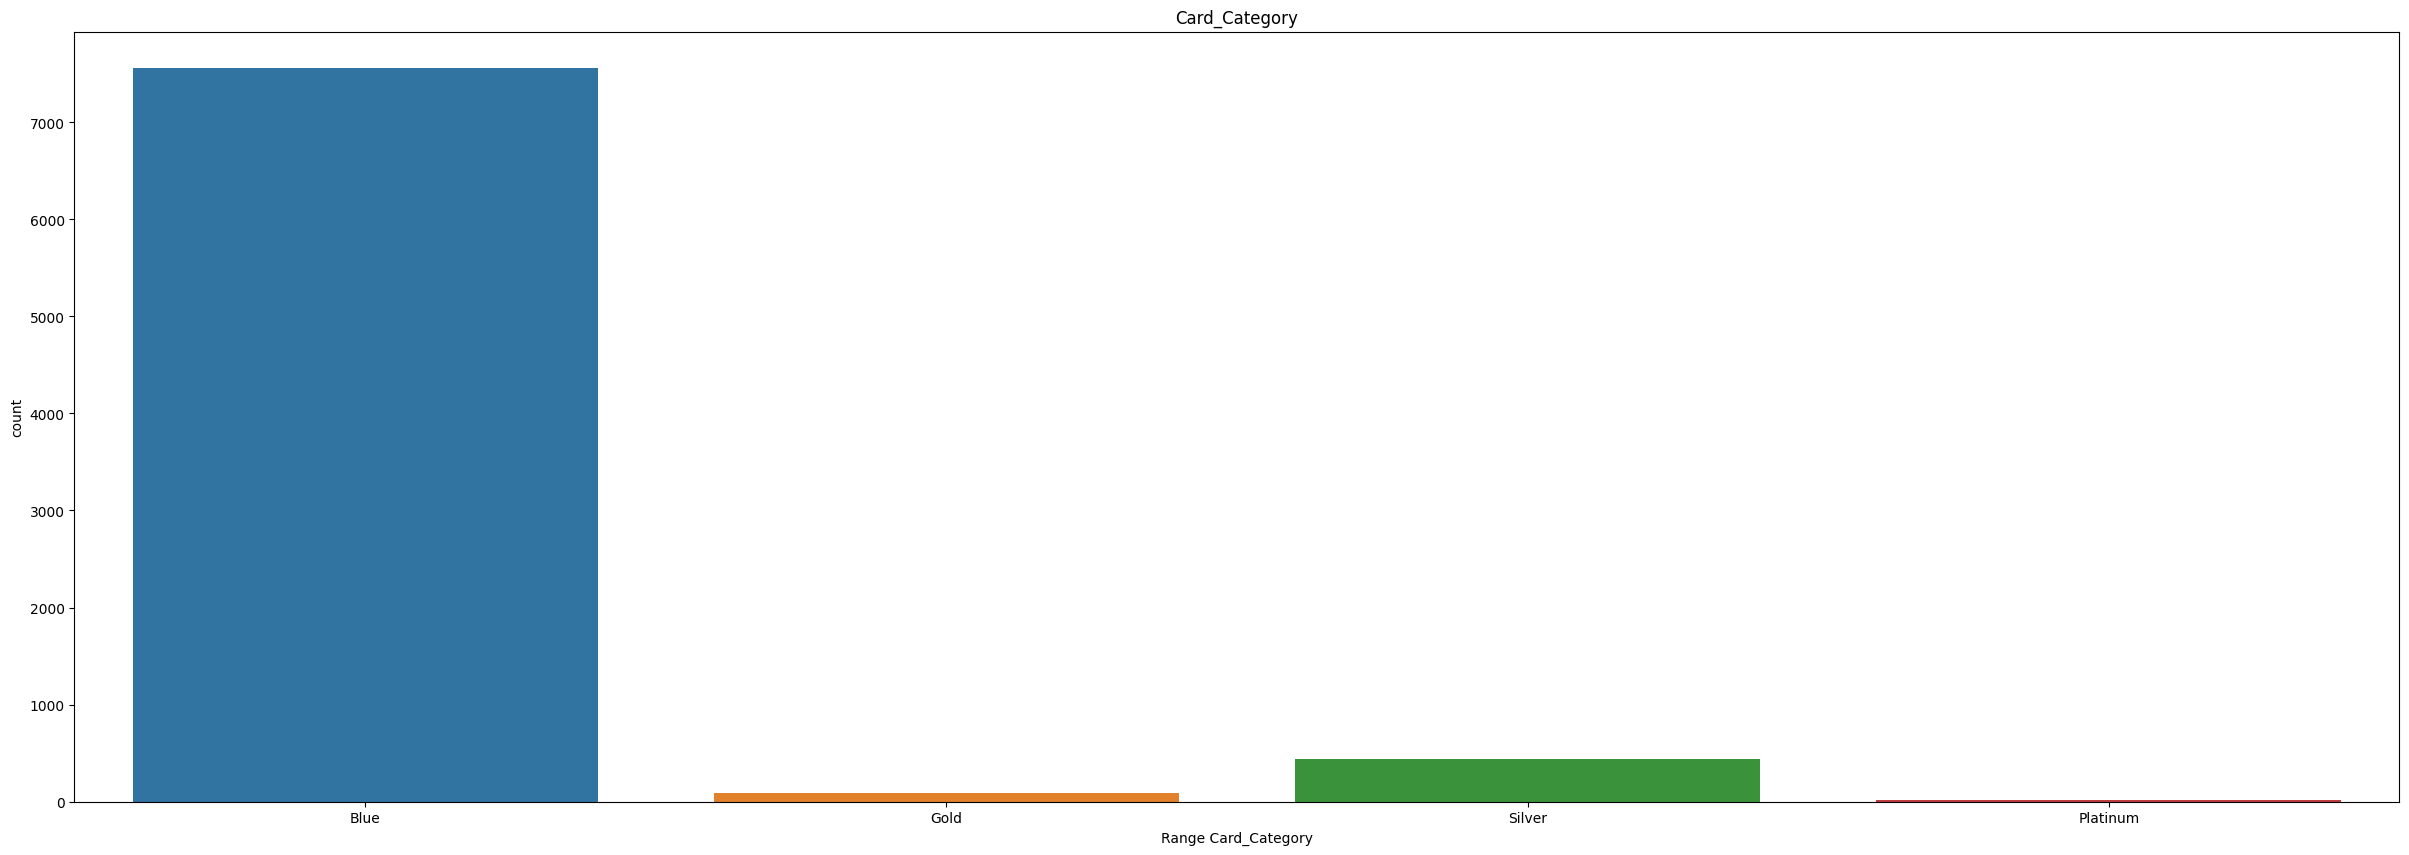

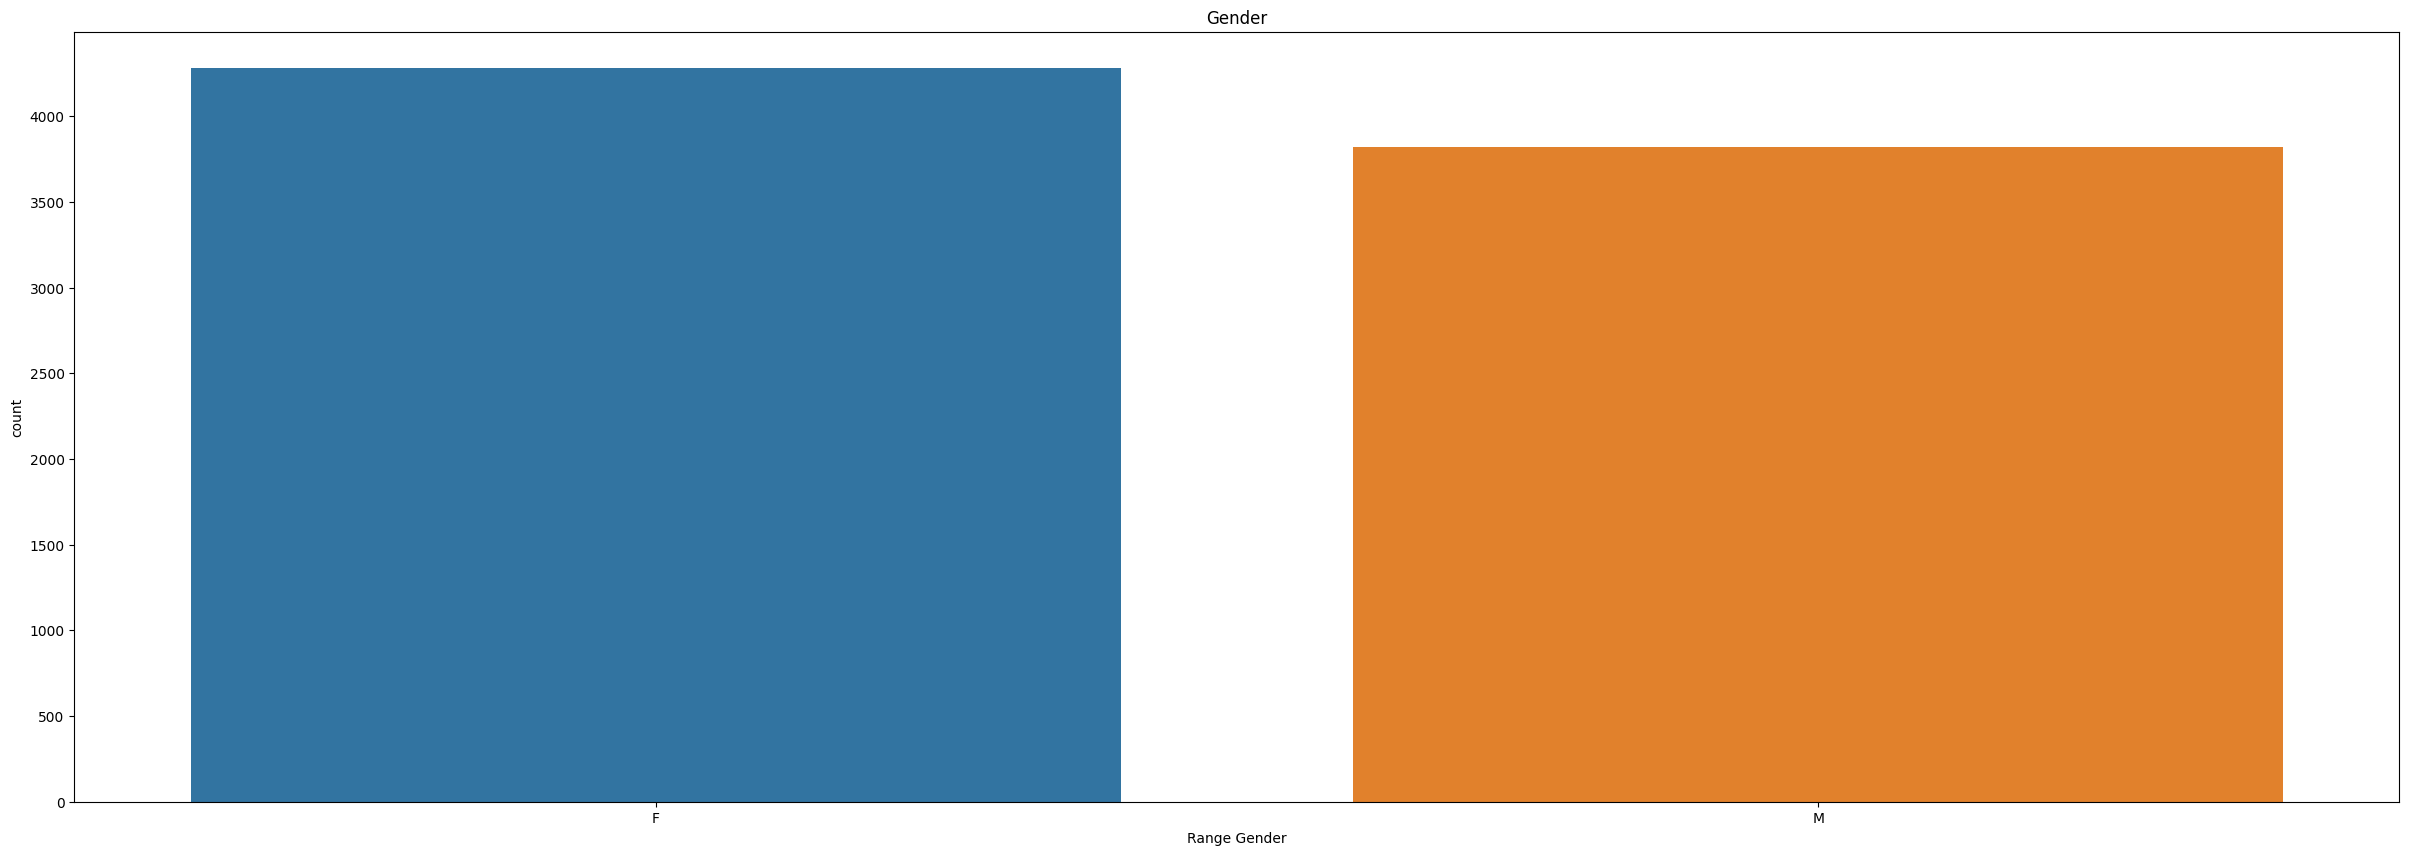

F    4279
M    3822
Name: Gender, dtype: int64


In [ ]:
# Gráficos para identificar outliers, letras extrañas etc.
EDA(df_train, num, cat, binary, target)

- Income_category, Marital_Status, Education_Level: Tienen un **unknow**.
- Card_Category, Income_Category, Education_level: Son categorias en una escala. Se pueden pasar a númericas con un sentido estadístico.
- Dilema: ¿Quito outliers para hacer un modelo más preciso?¿Los dejo para hacer un modelo realista (Los valores lejanos son reales)?

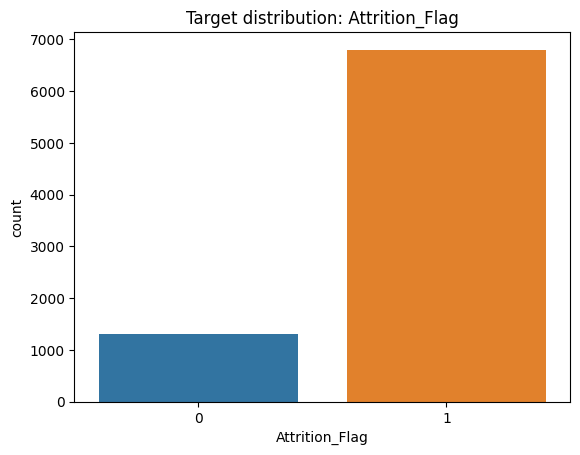

In [ ]:
# 1 = Cliente dentro del banco
# 0 = Cliente fuera del banco

sns.countplot(data=df_train, x=target)
plt.title('Target distribution: '+ target)
plt.show()

- Hay que rebalancerar la data, 
- En este caso el f1 es una de las mejores métricas
- SVC, Trees penalizan el desajuste de data

ANÁLISIS MULTIVARIABLE

En Anaísis Multivariable, voy a enfrentar el target, la variable a predecir, contra todas las variables, para analizar que variables pueden influir en la predicción del target.

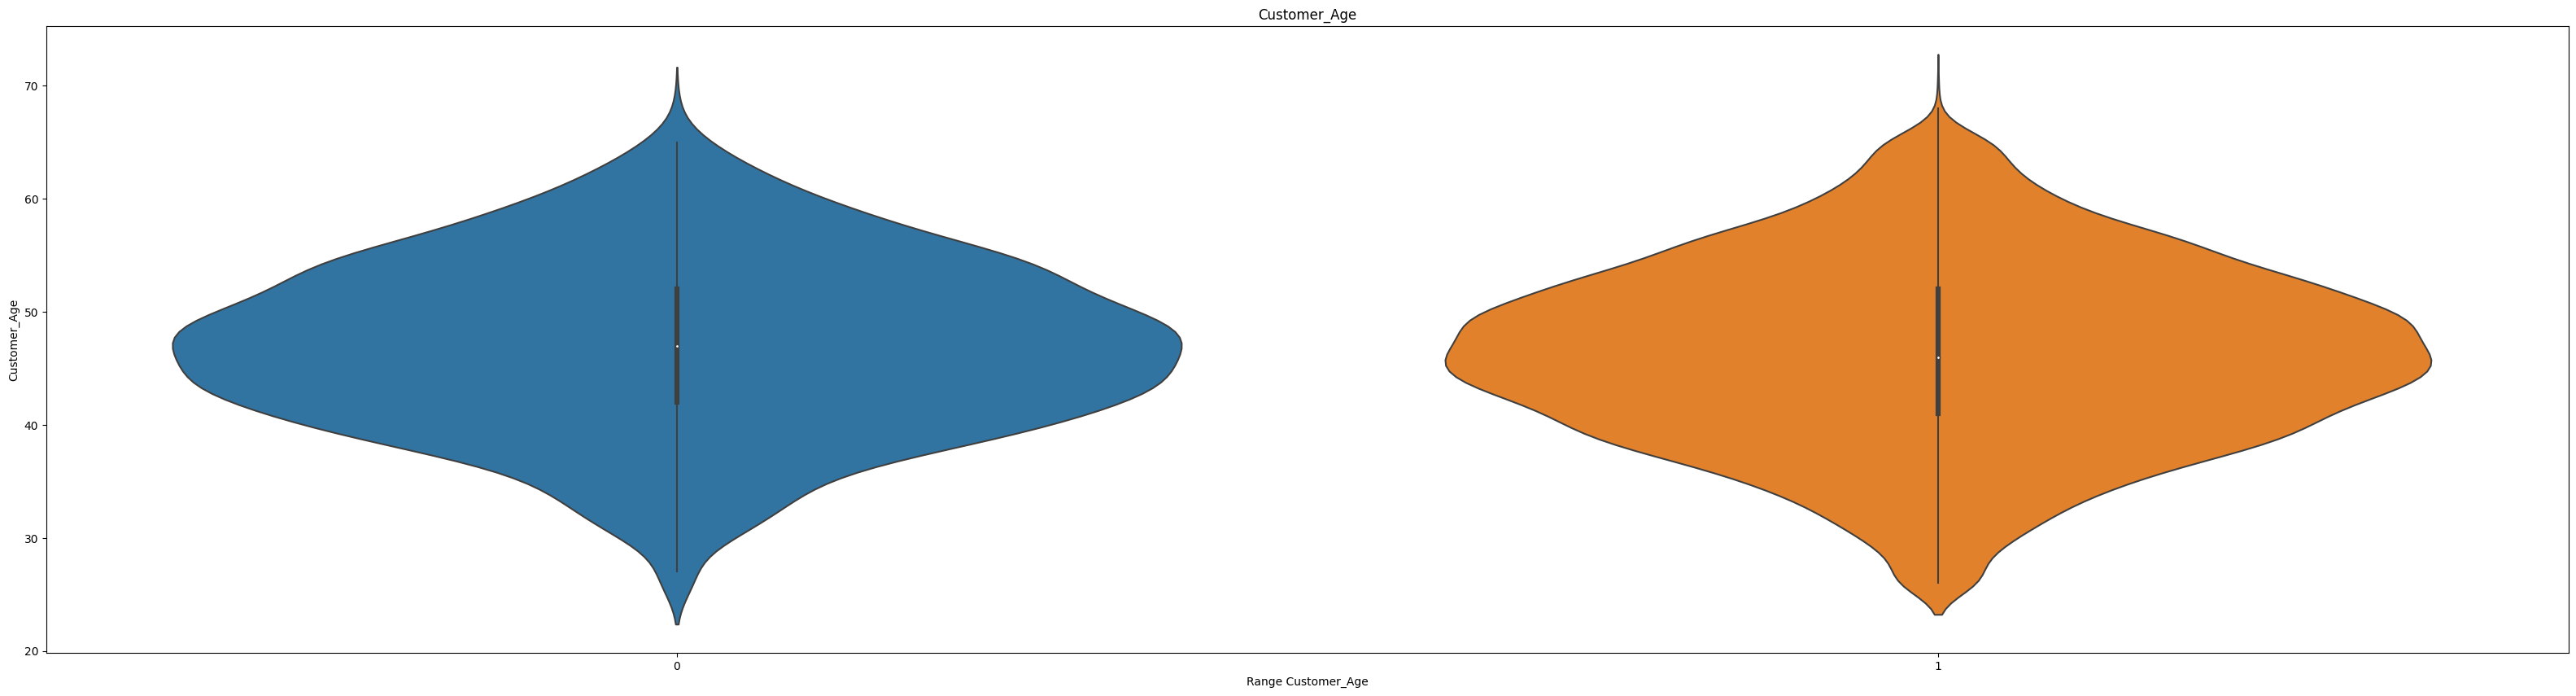

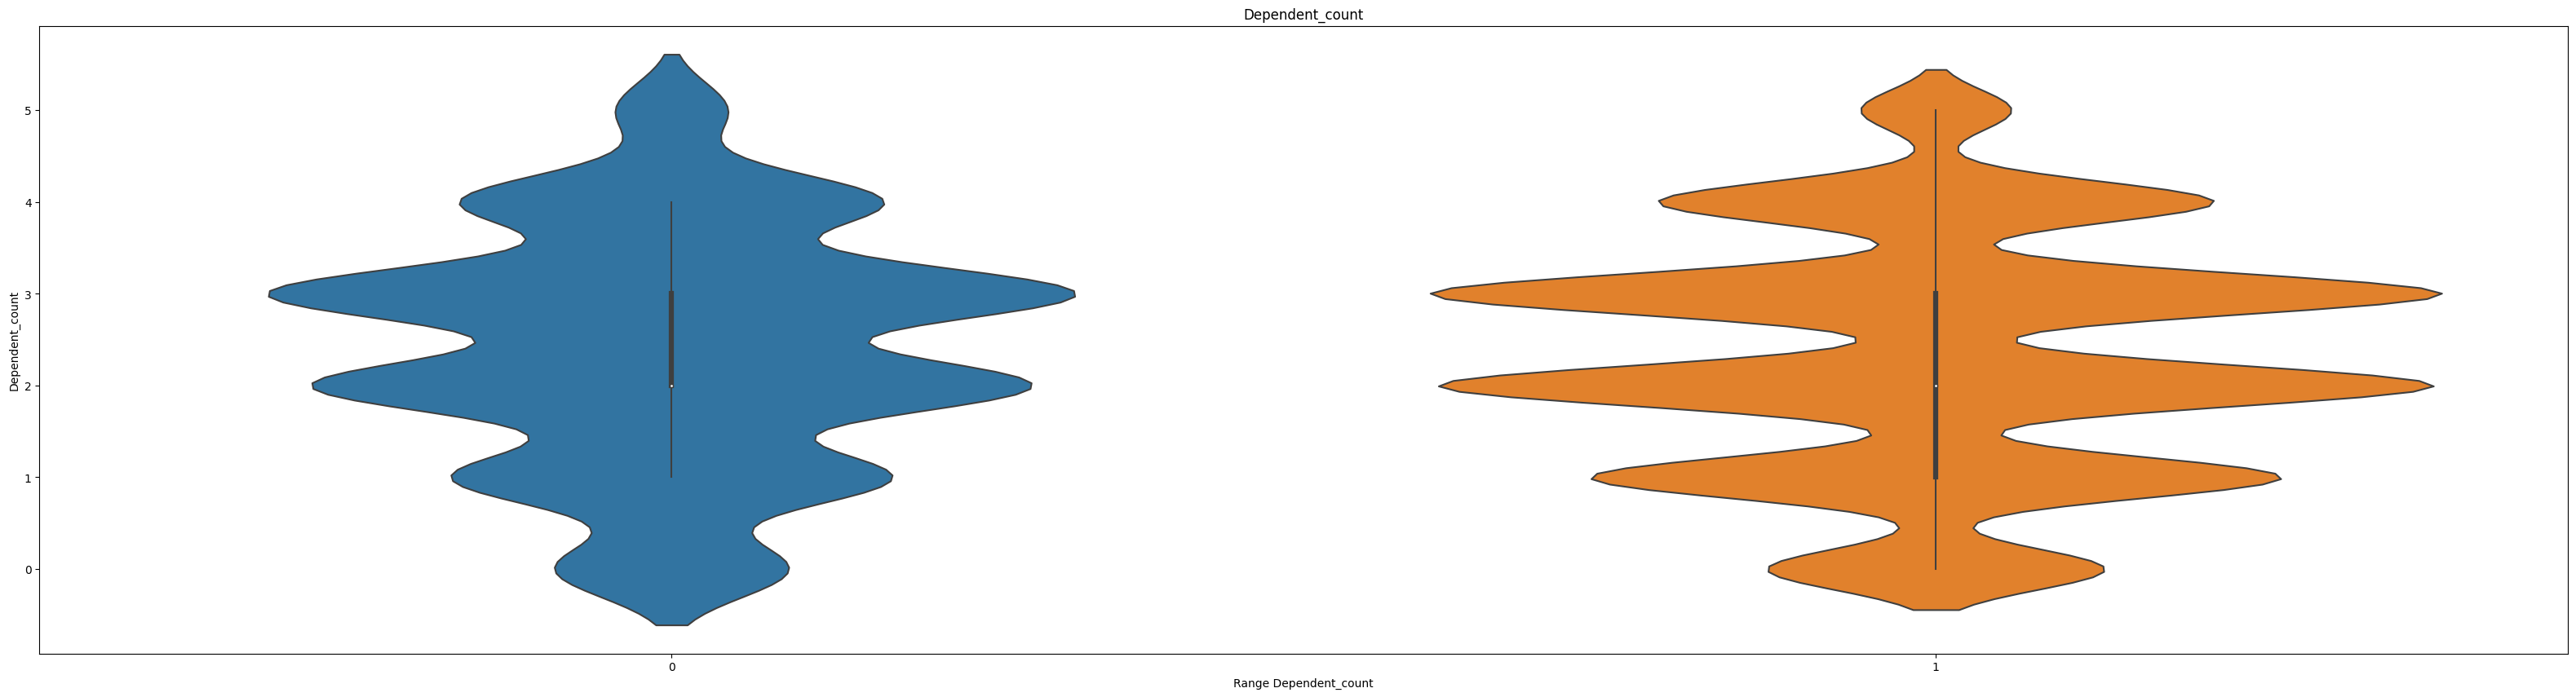

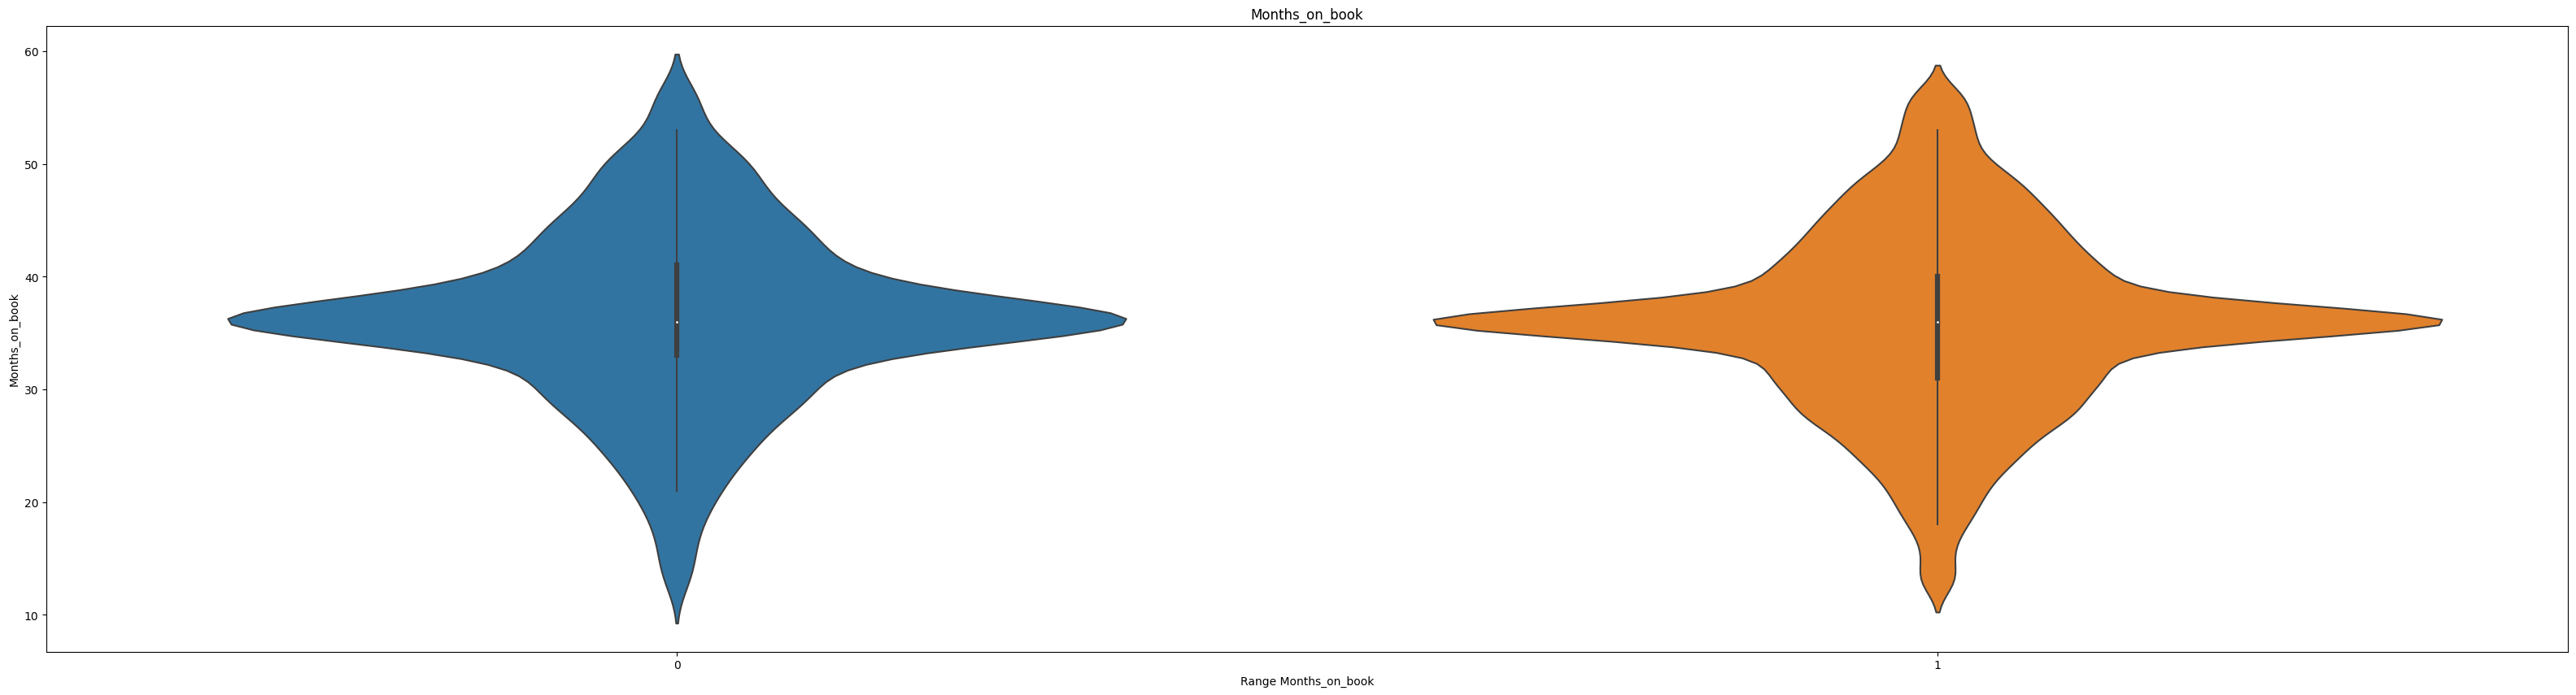

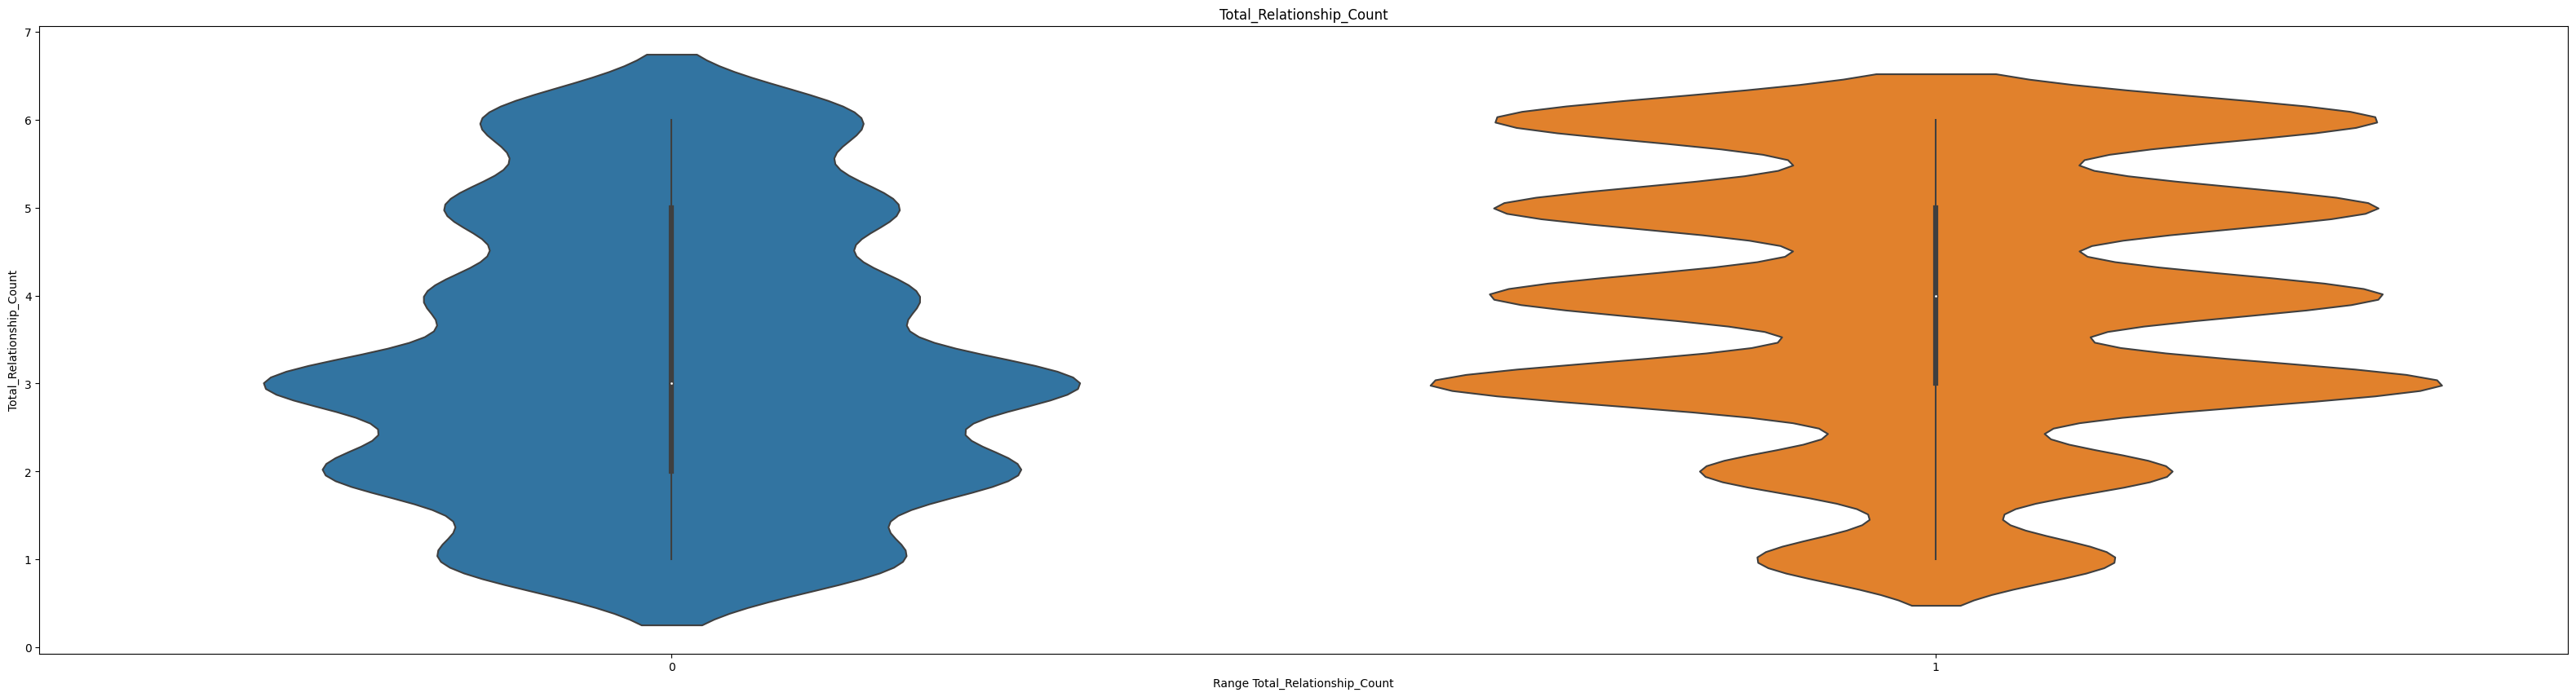

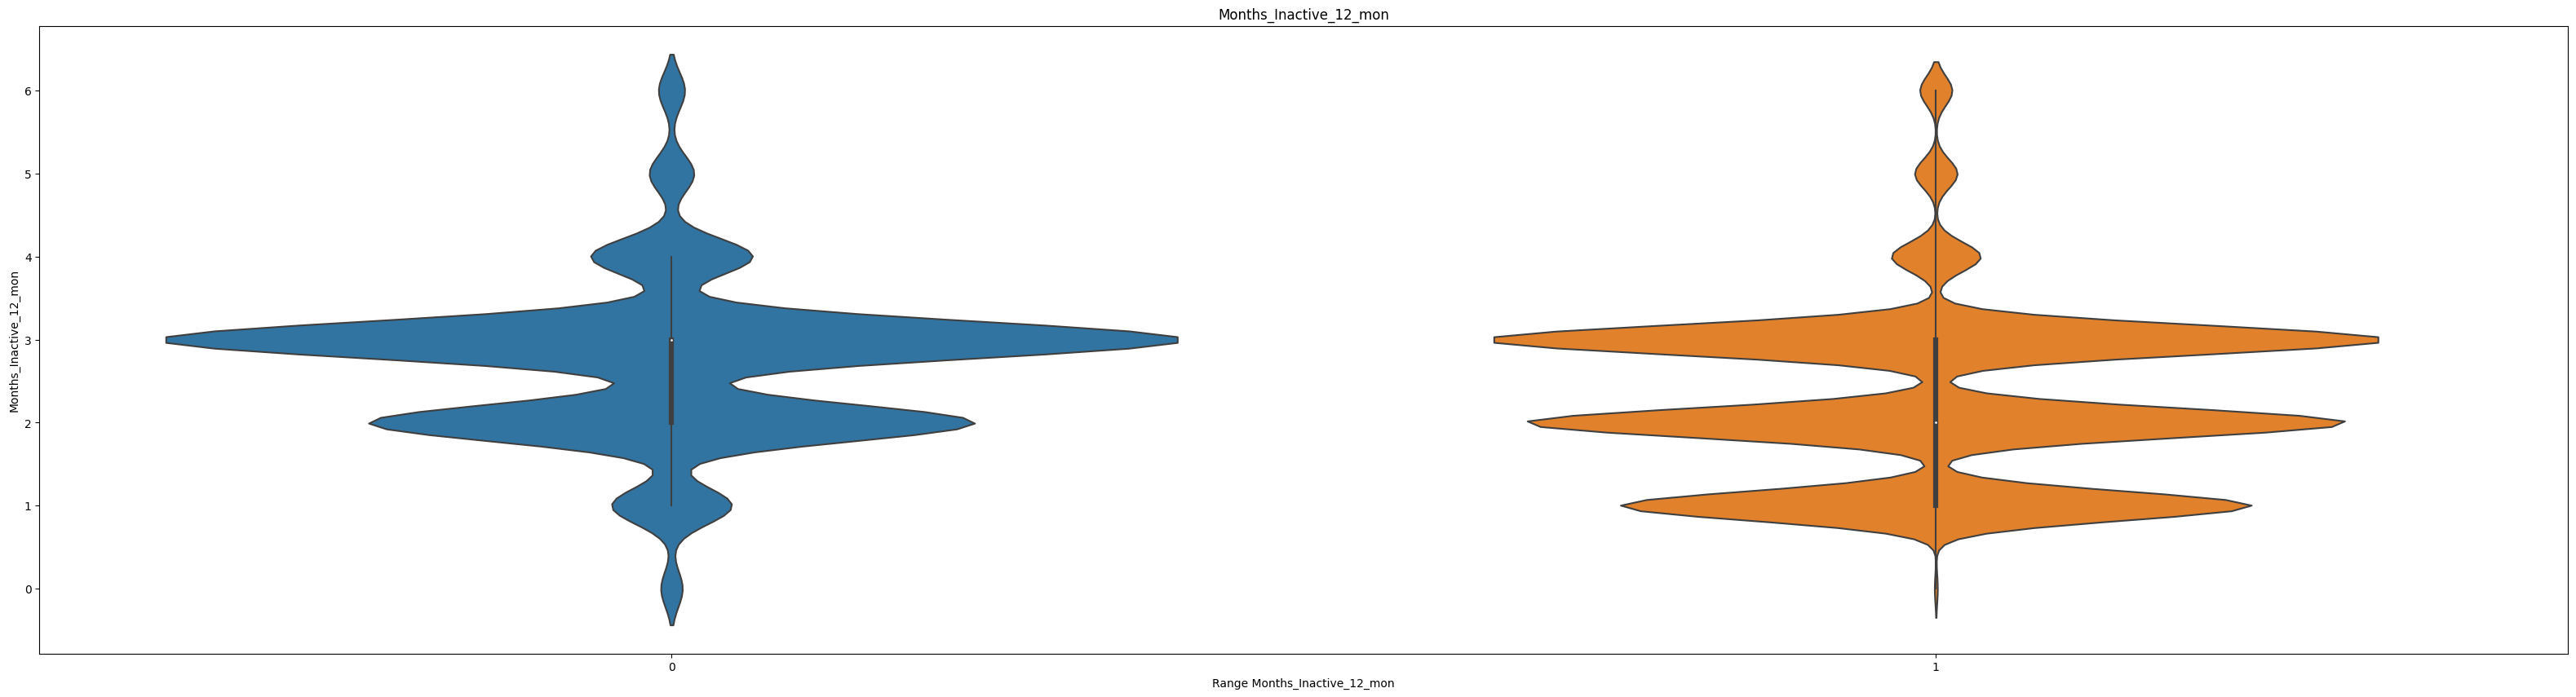

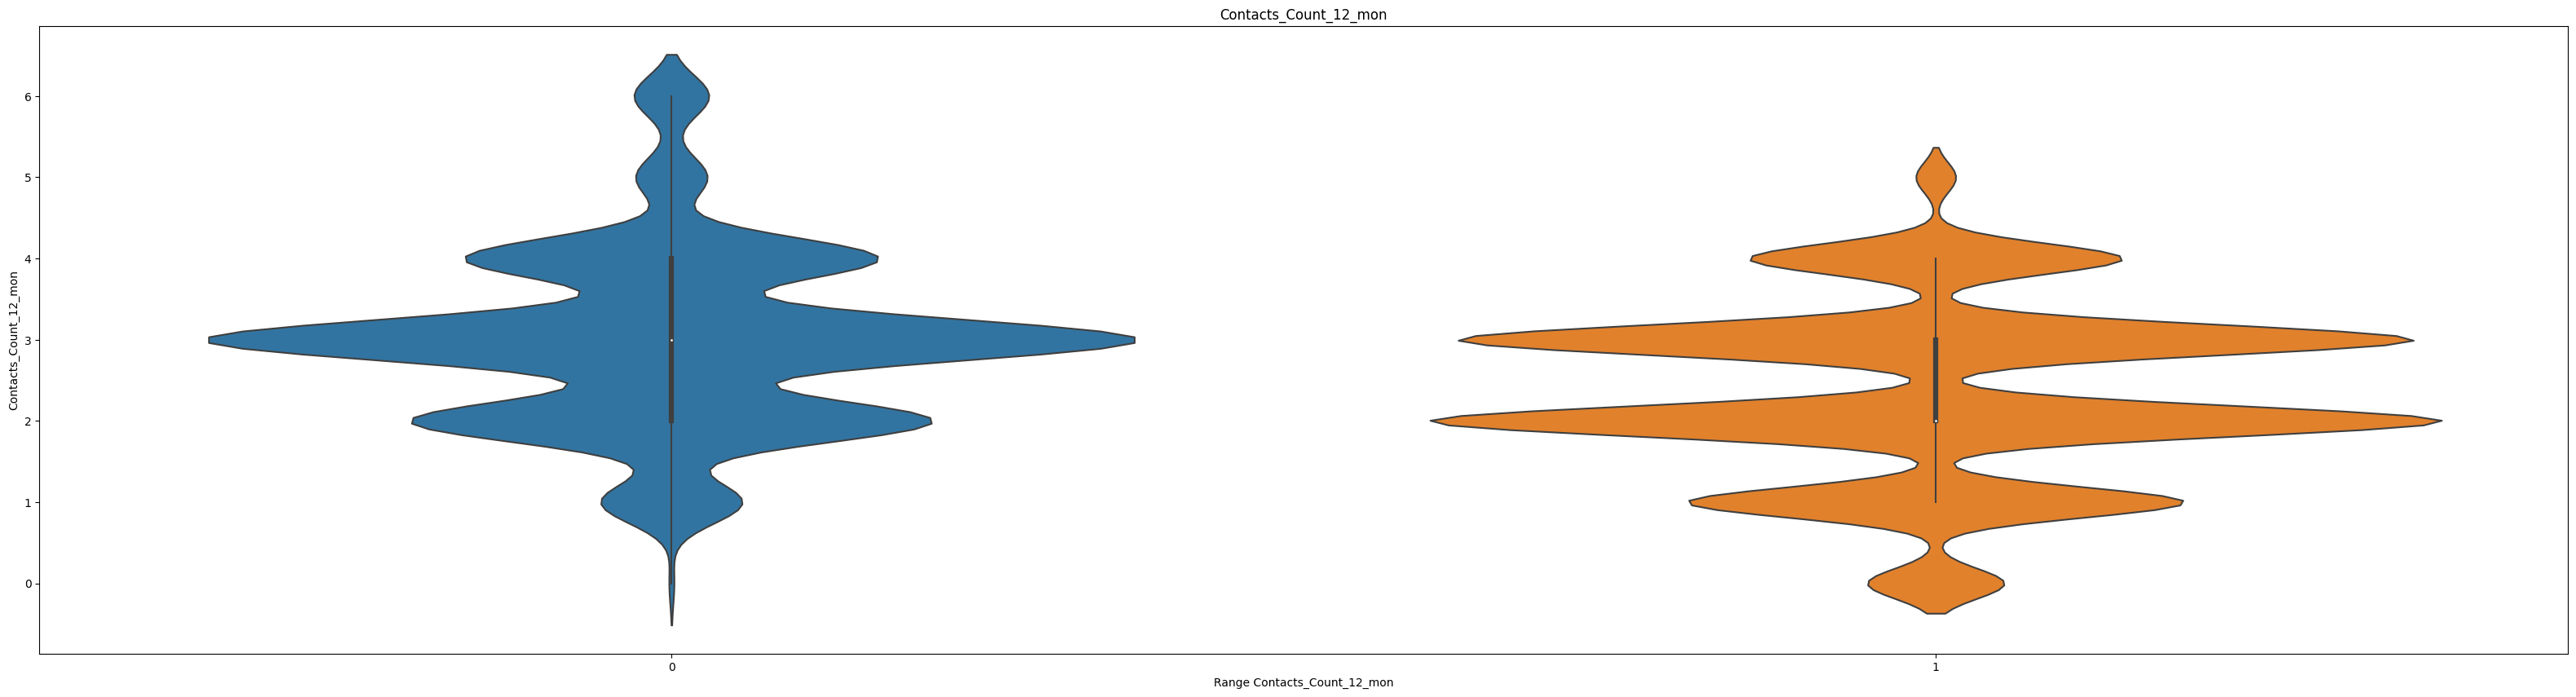

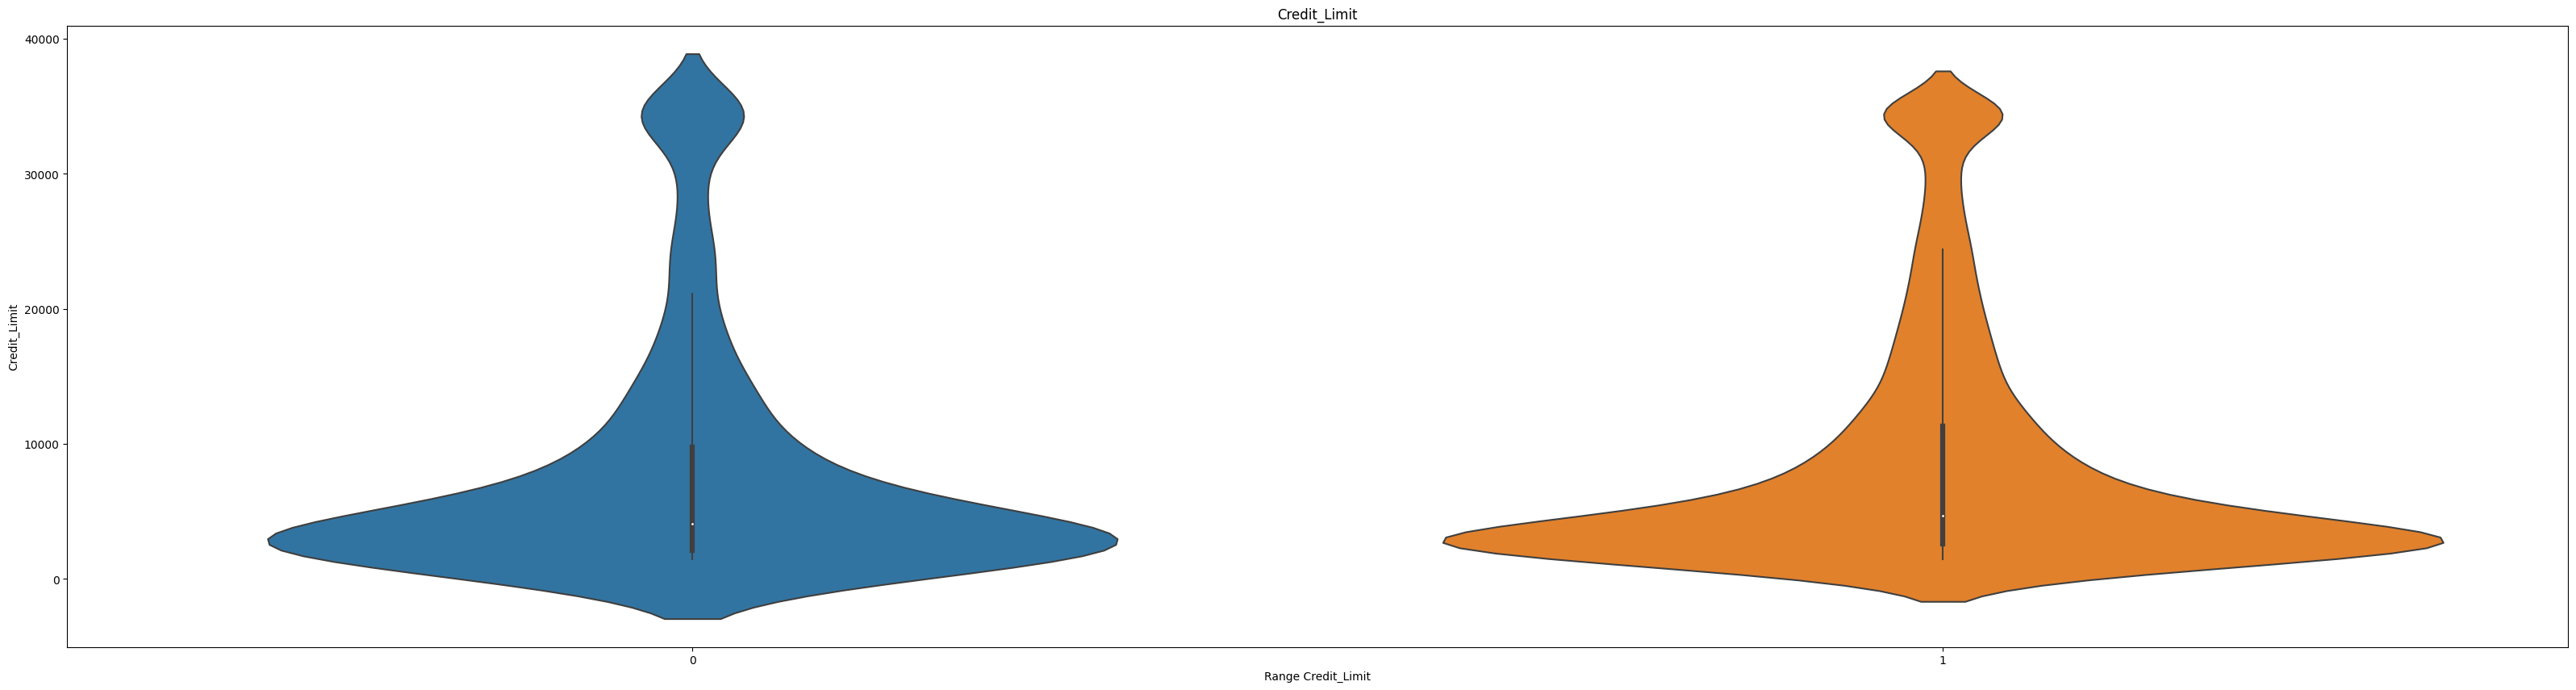

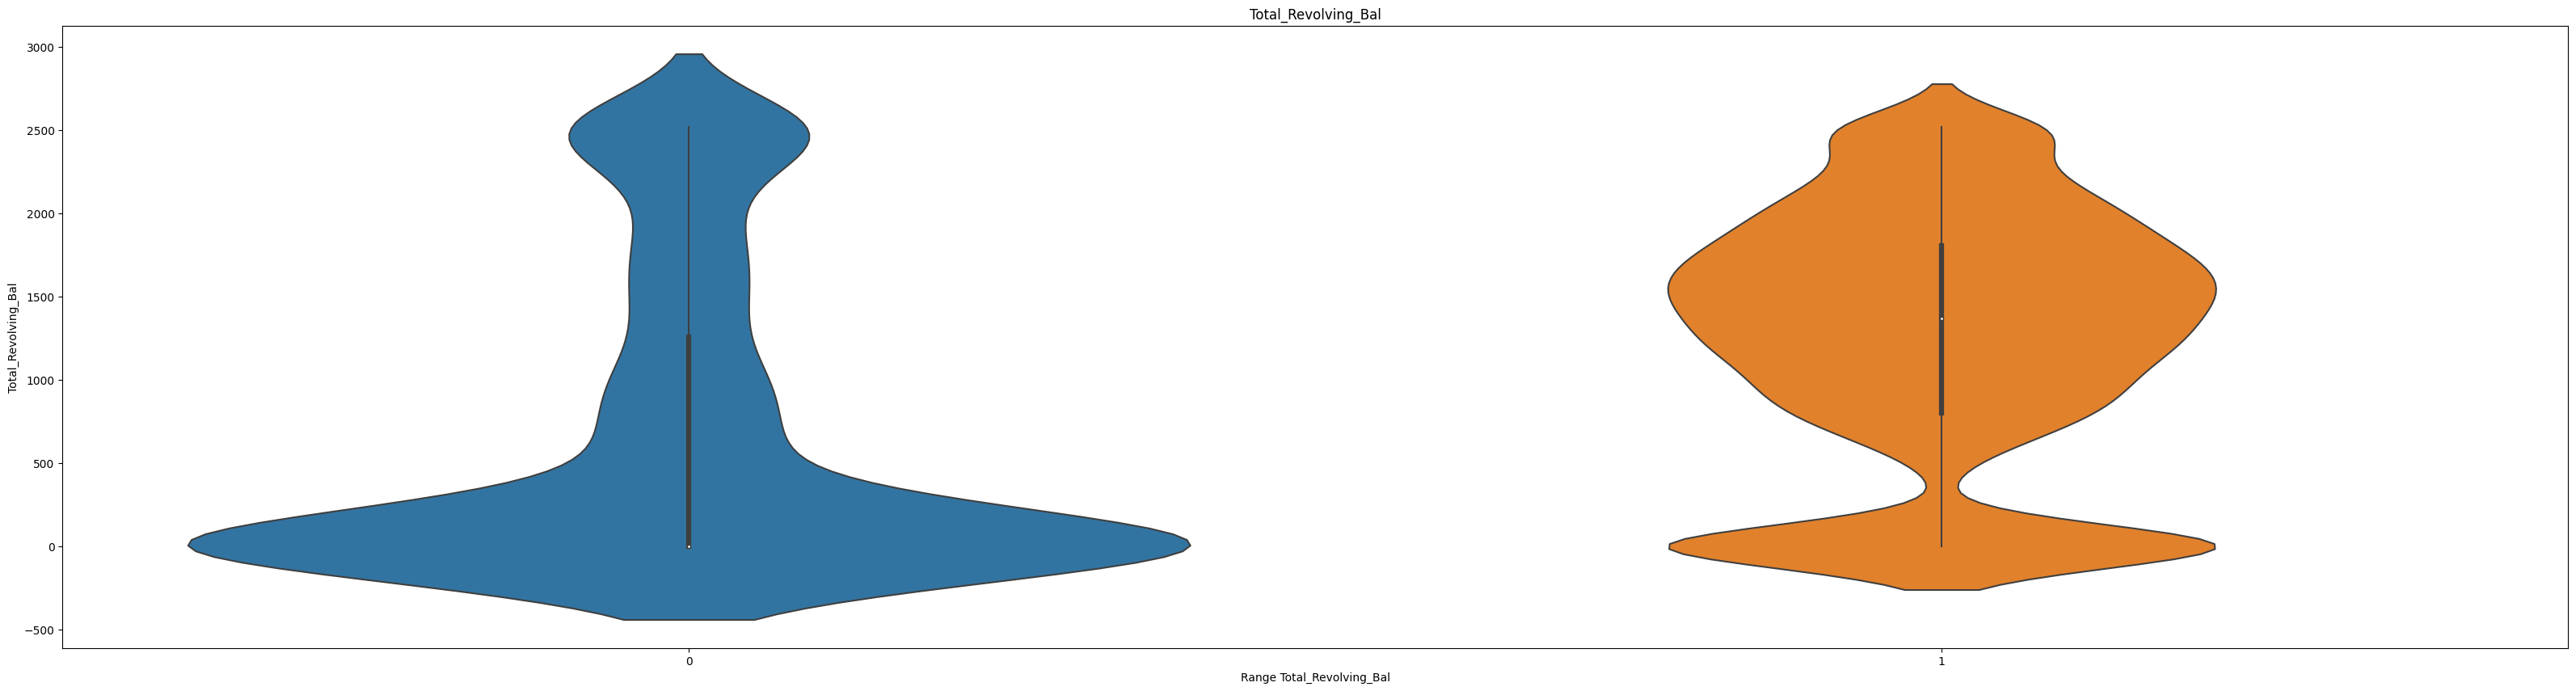

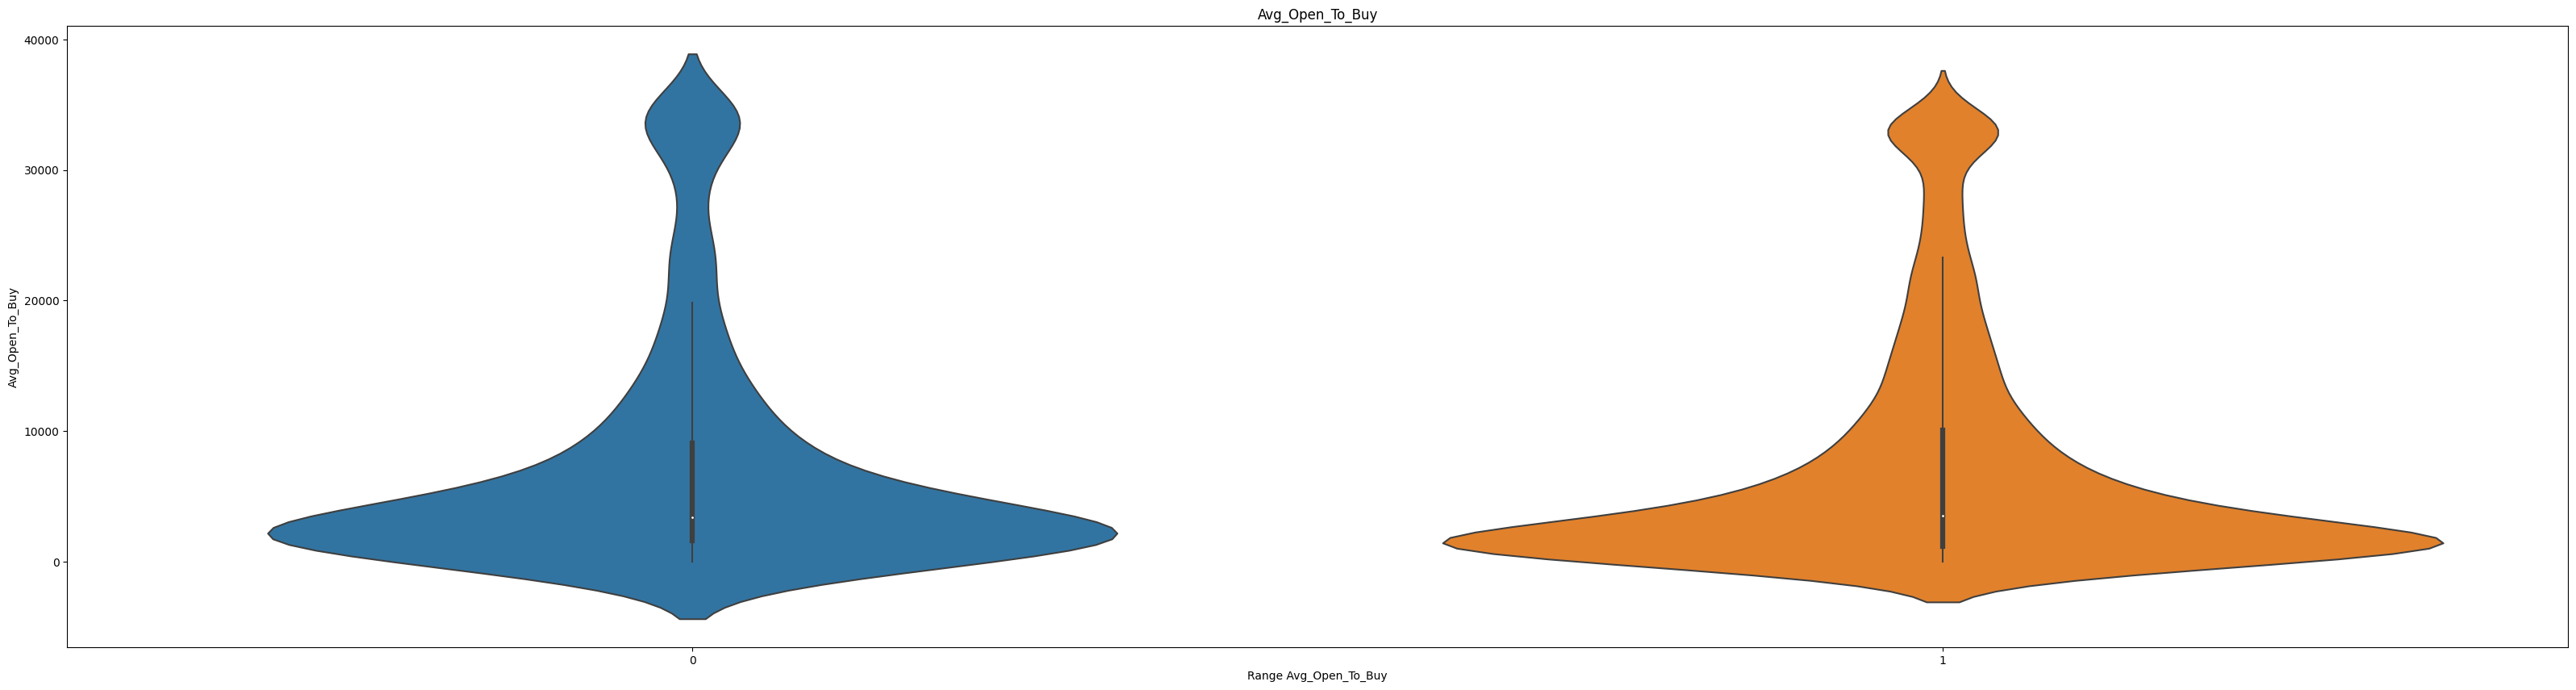

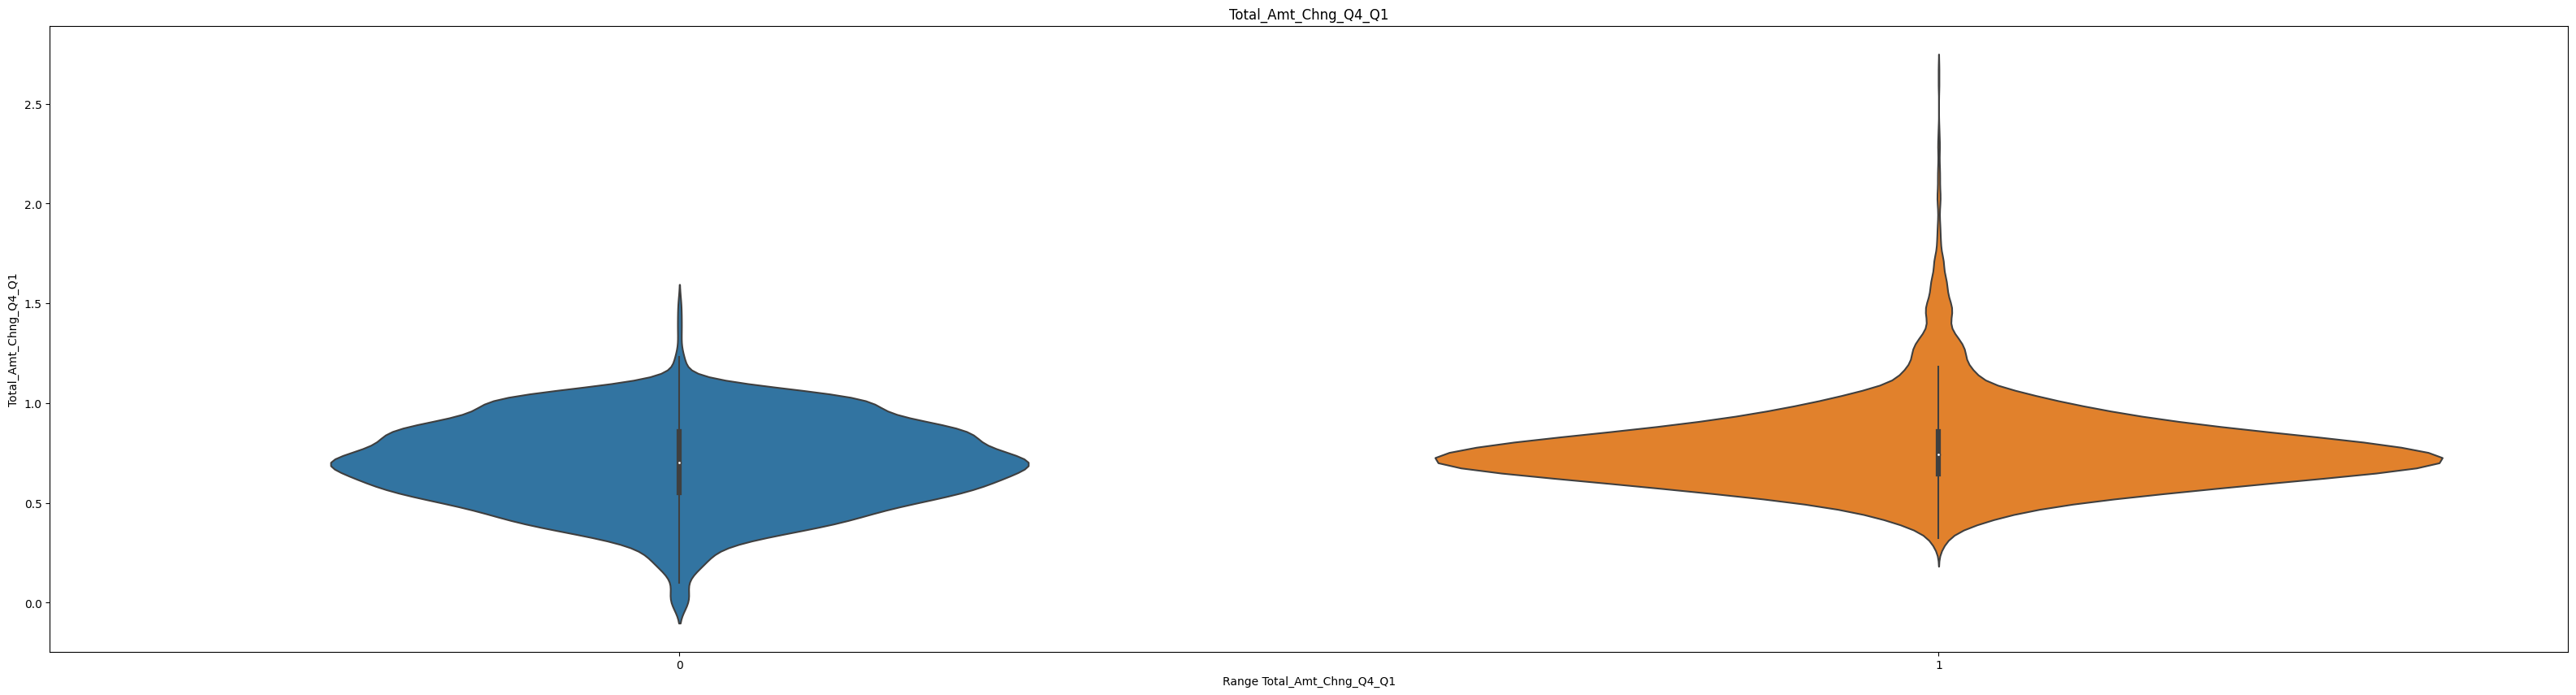

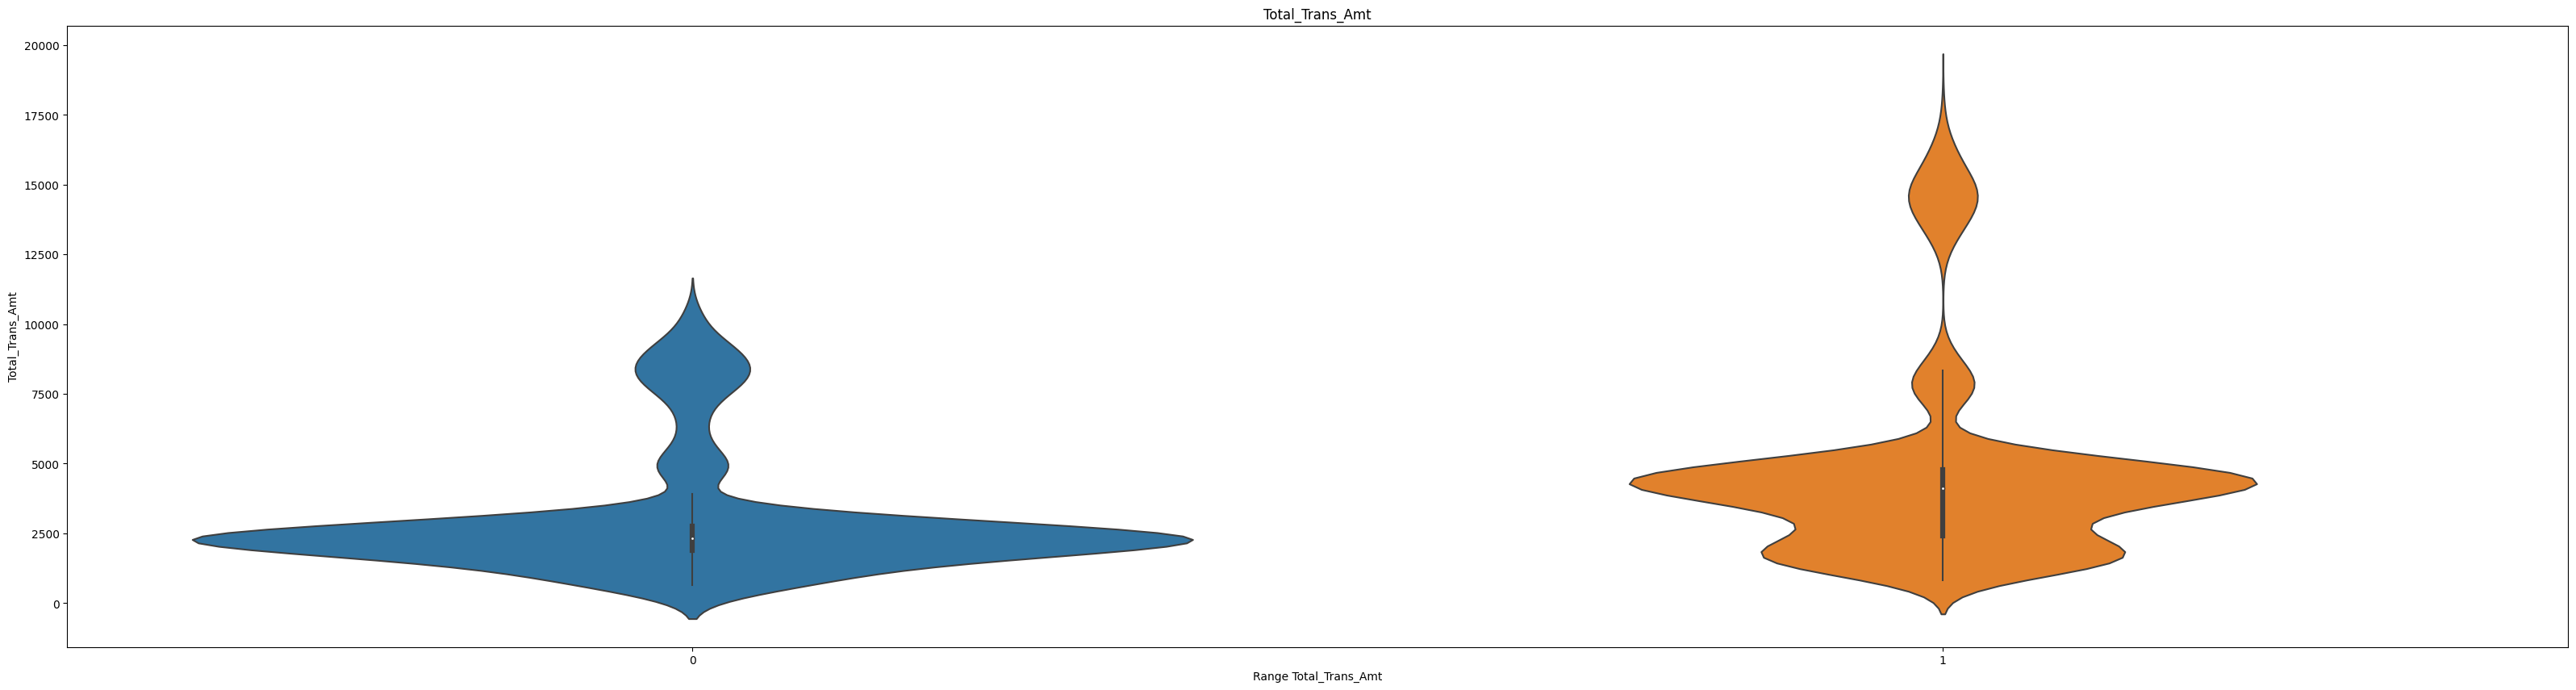

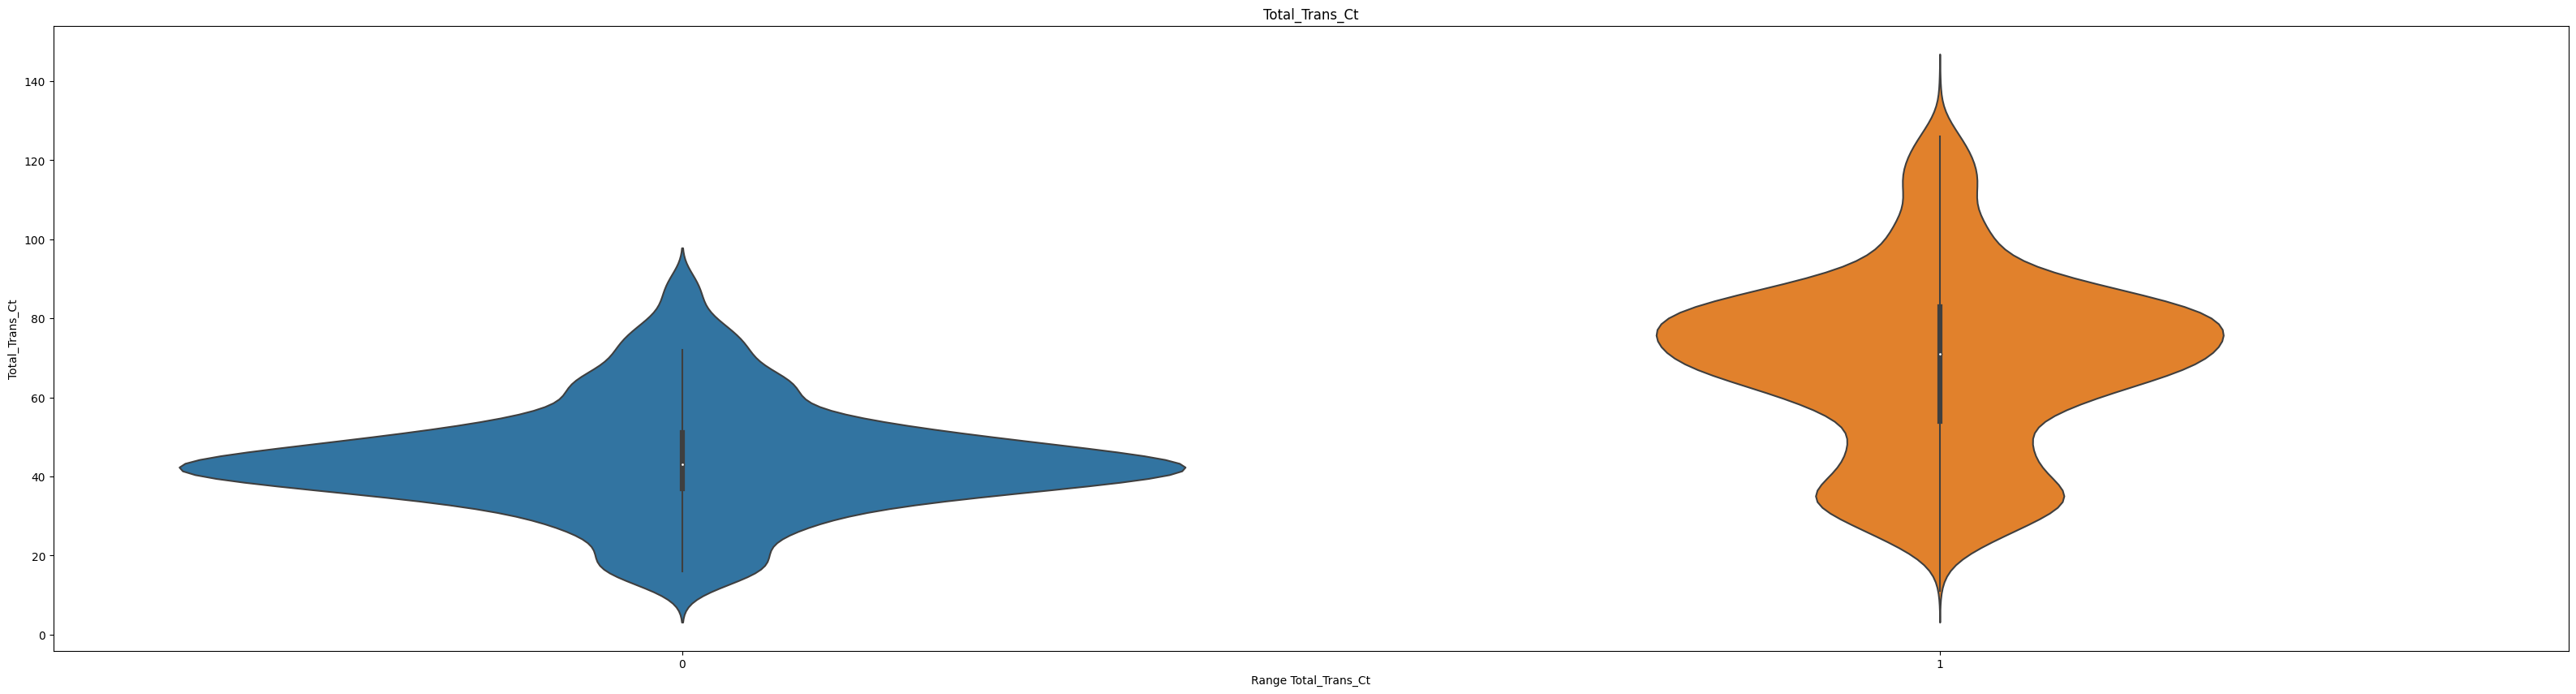

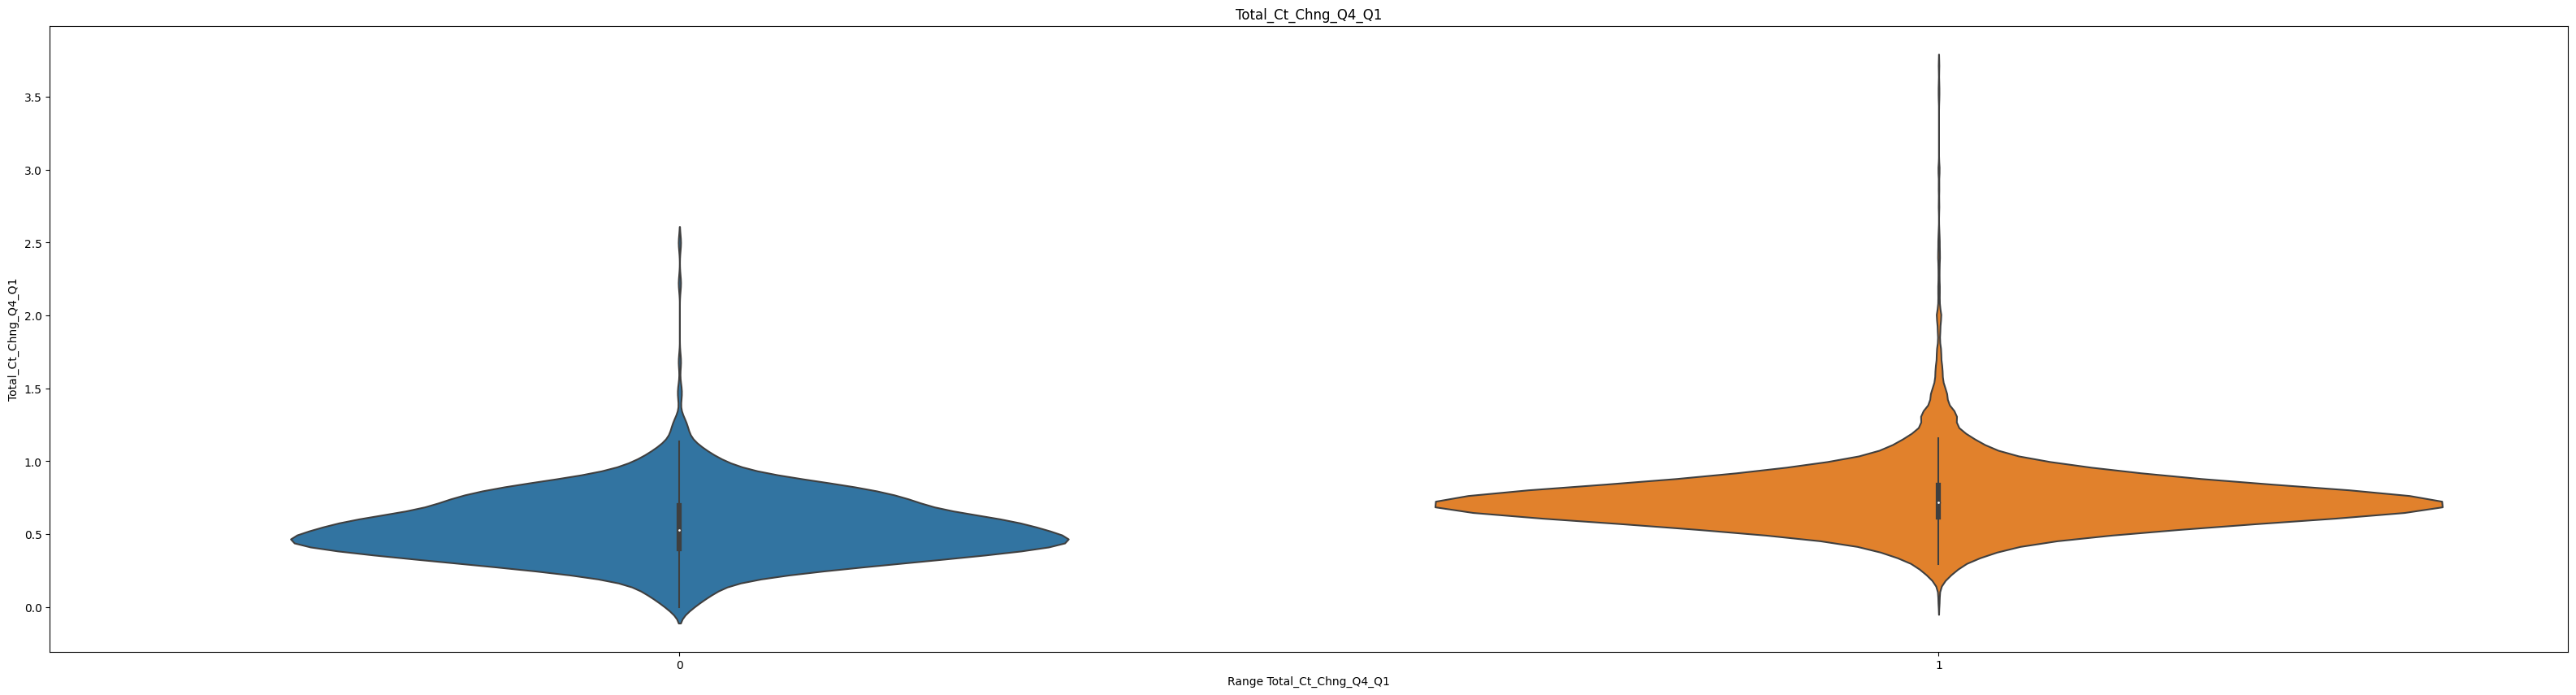

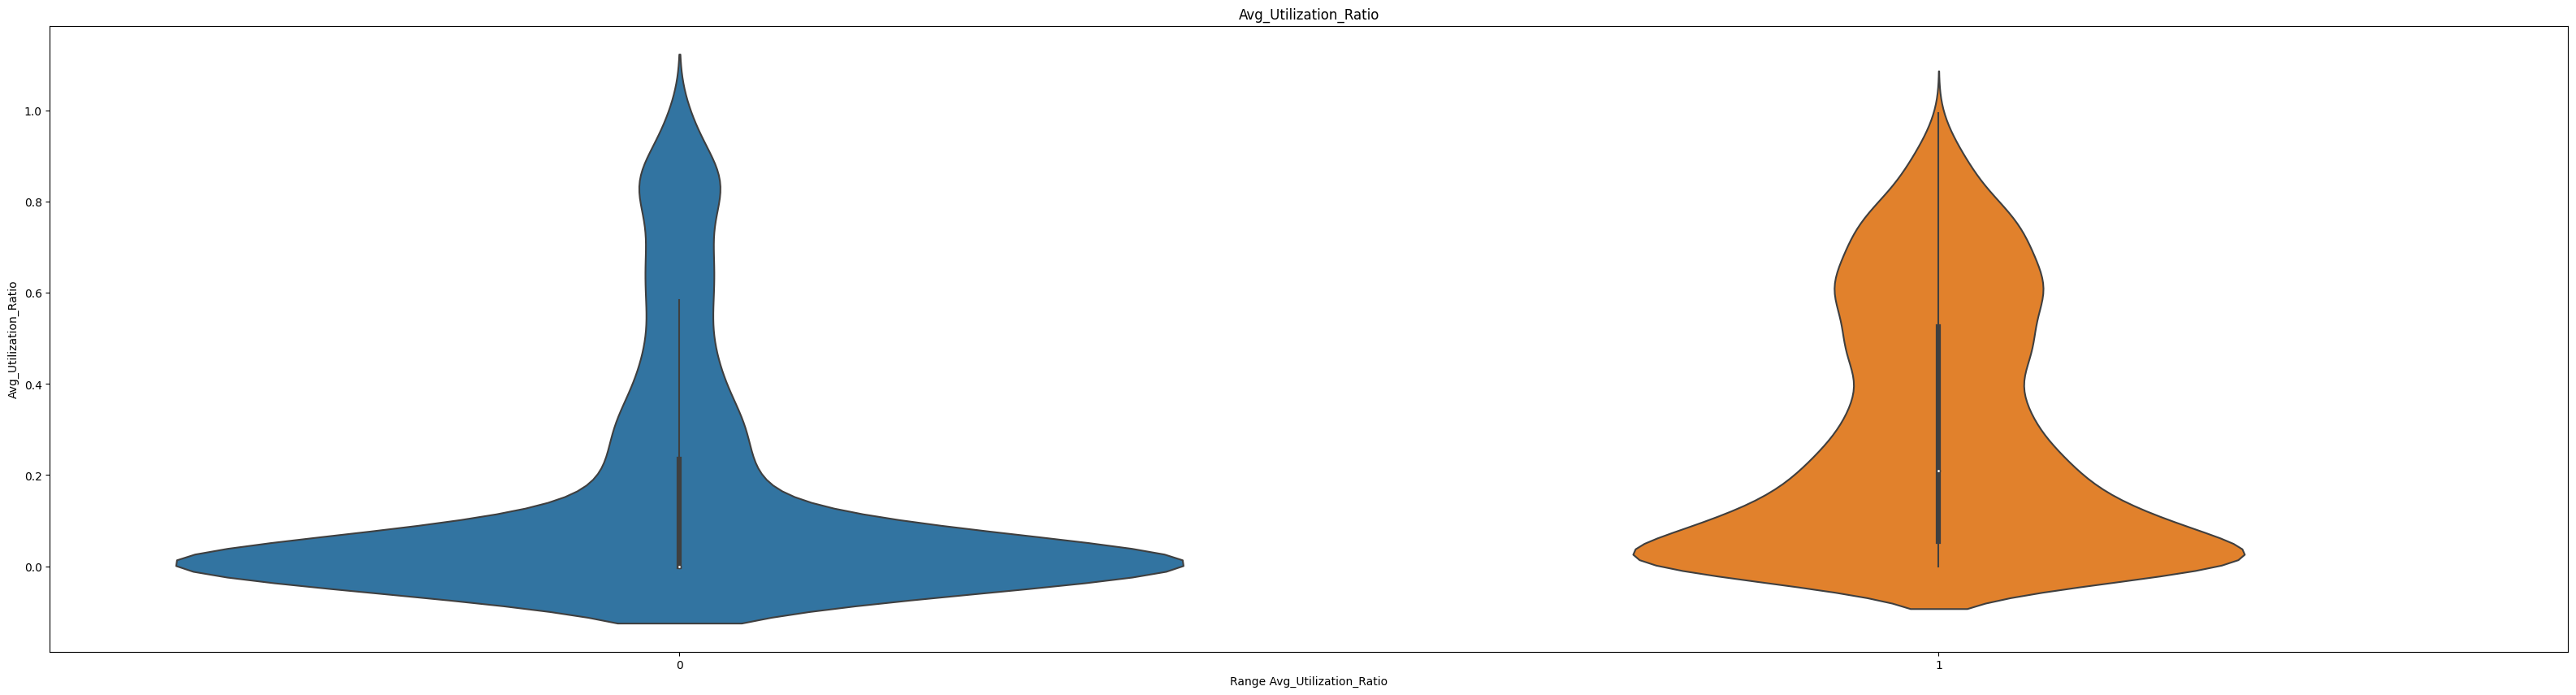

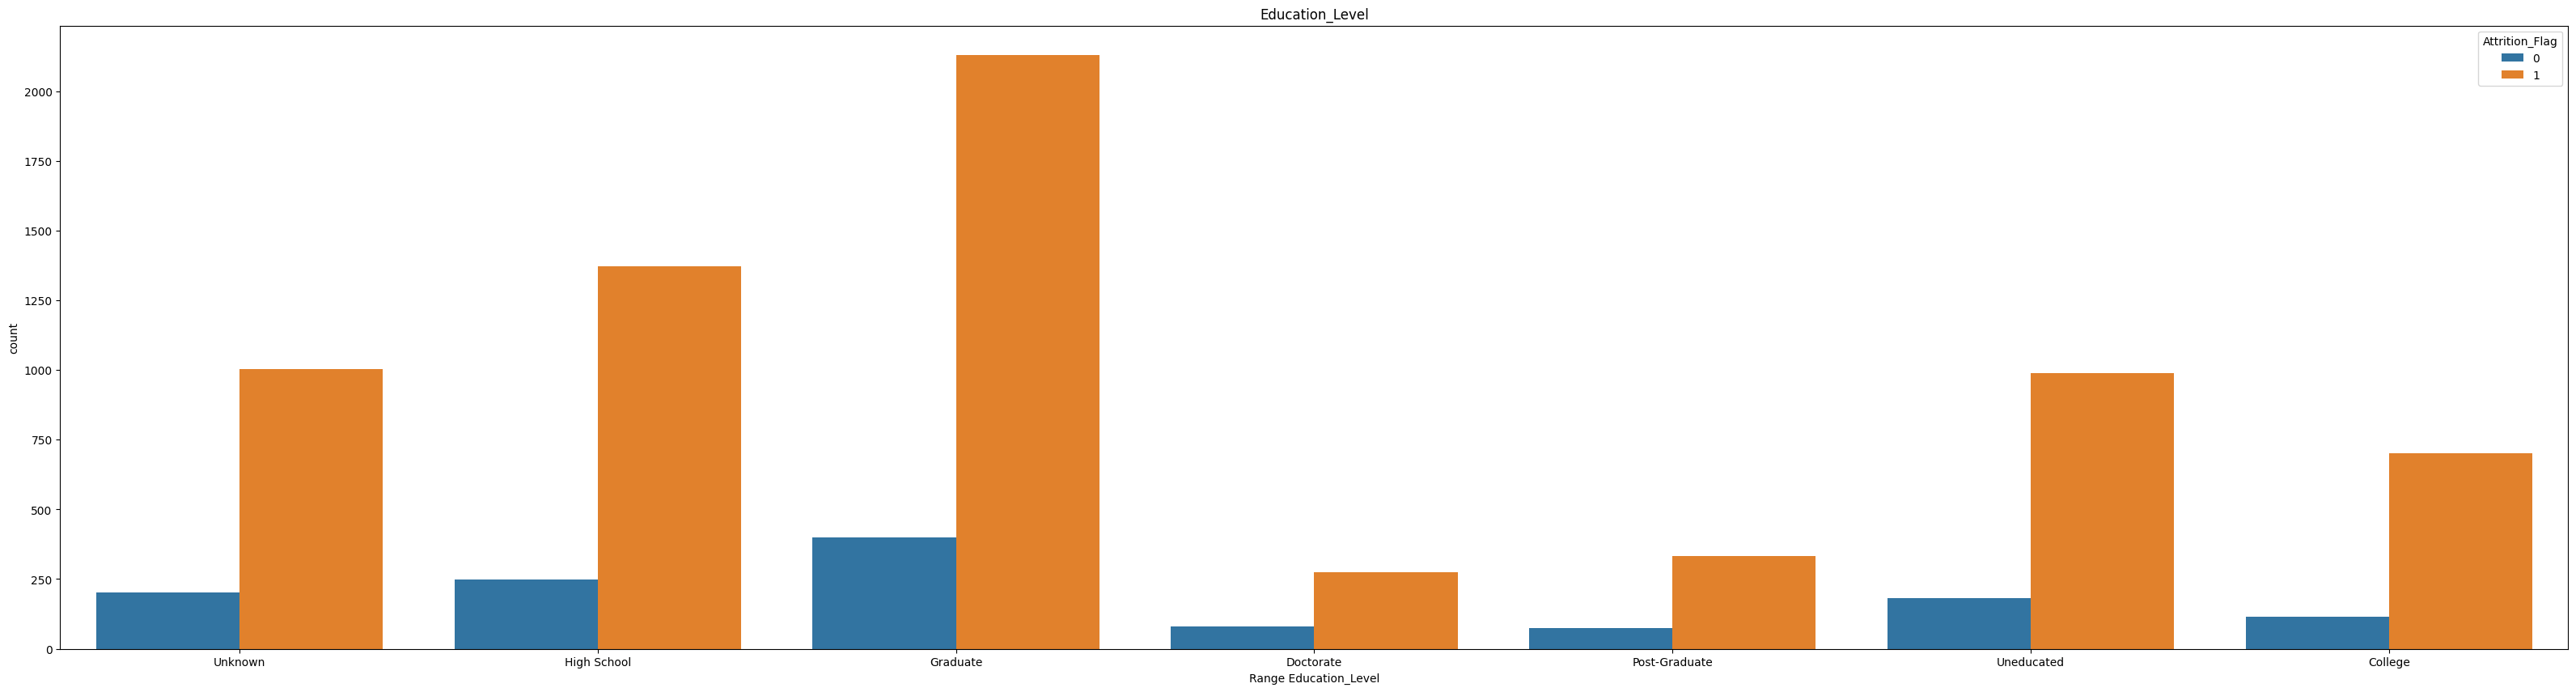

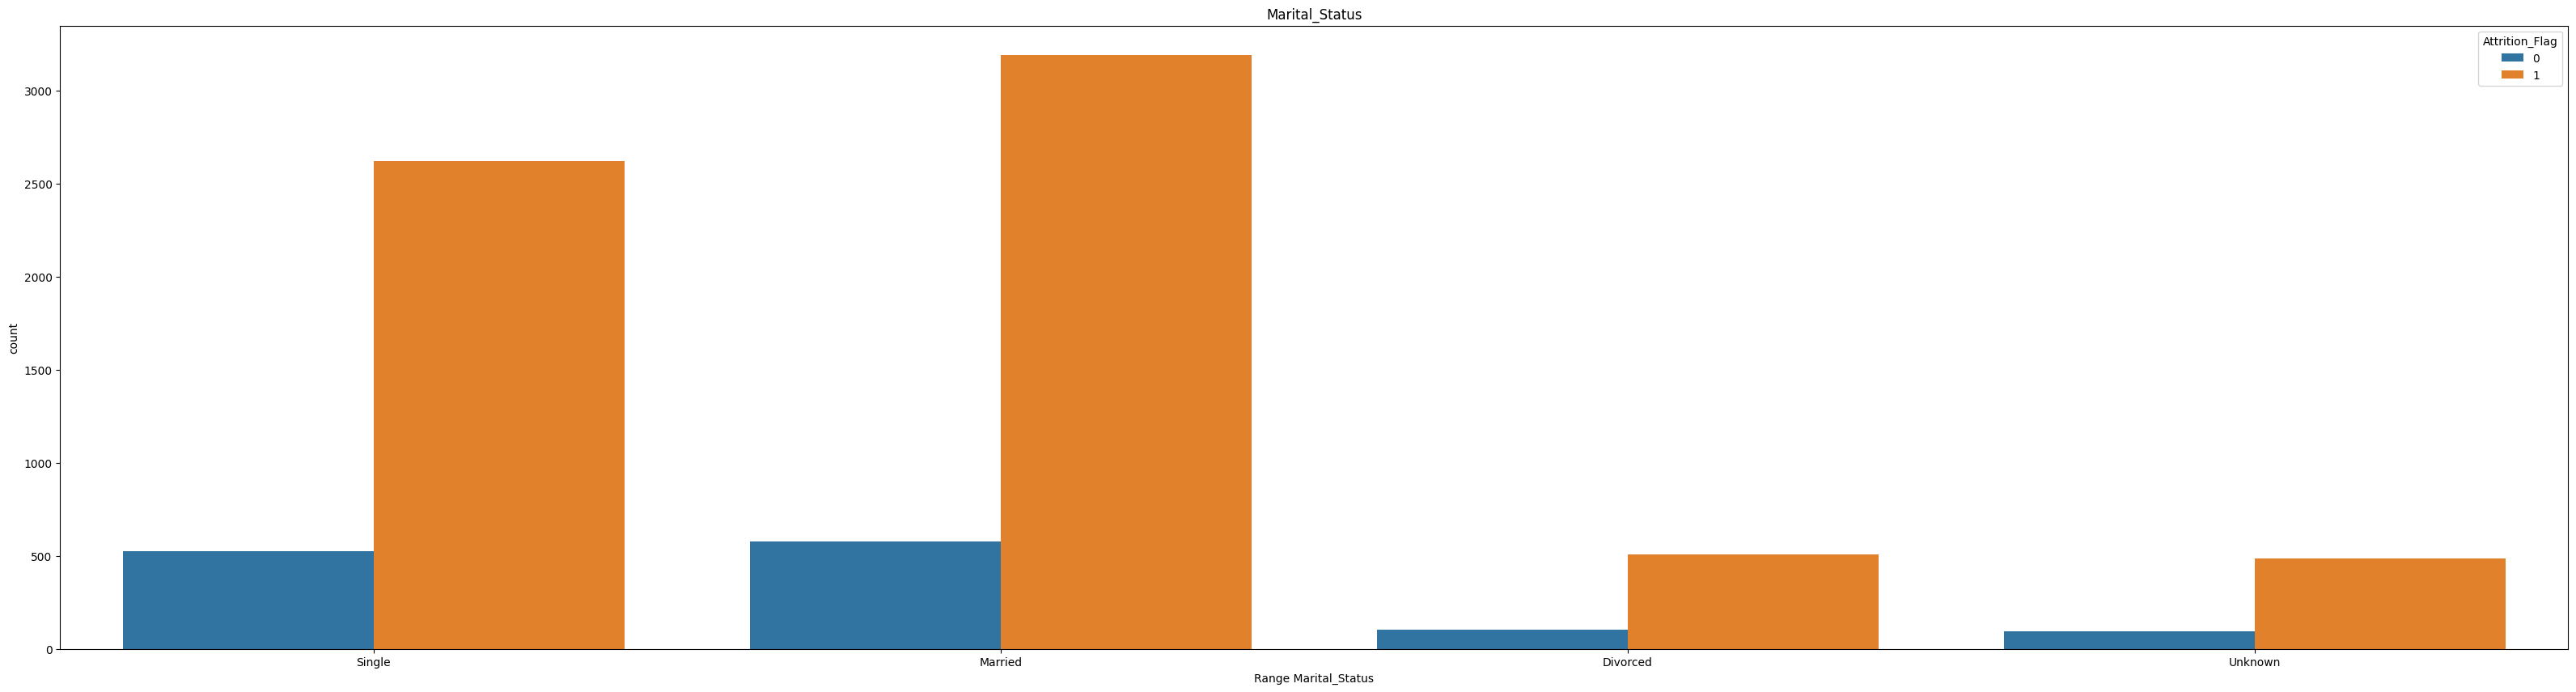

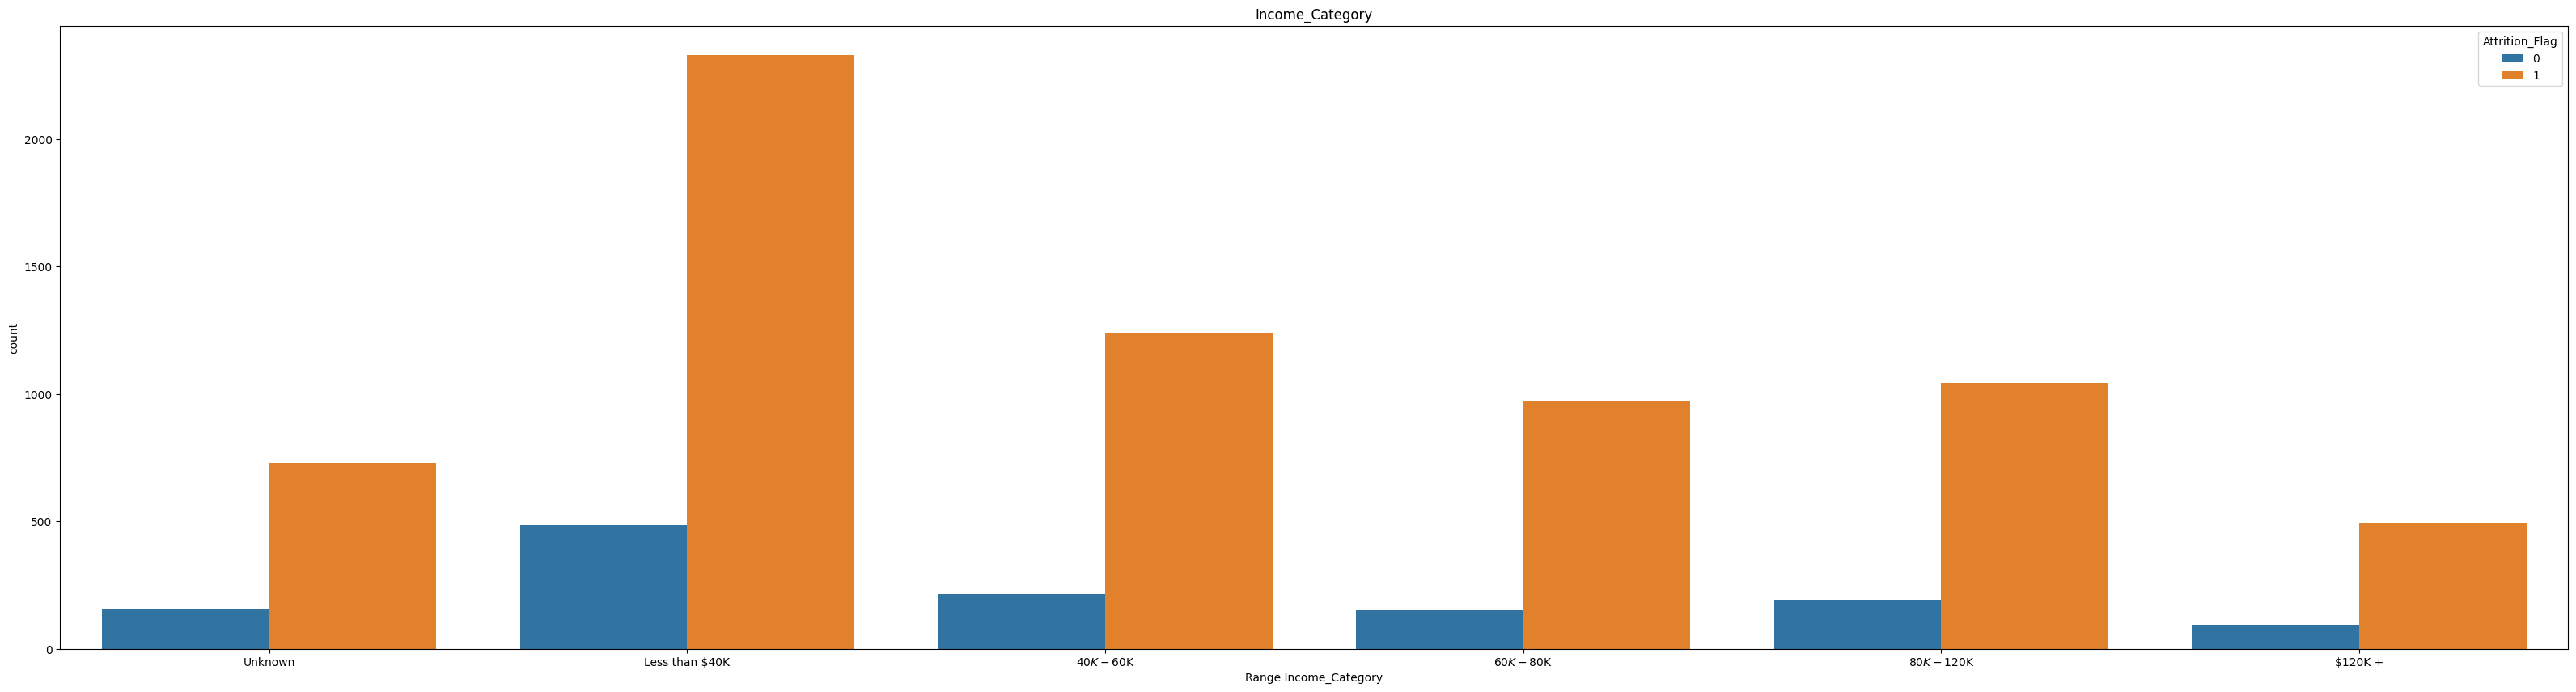

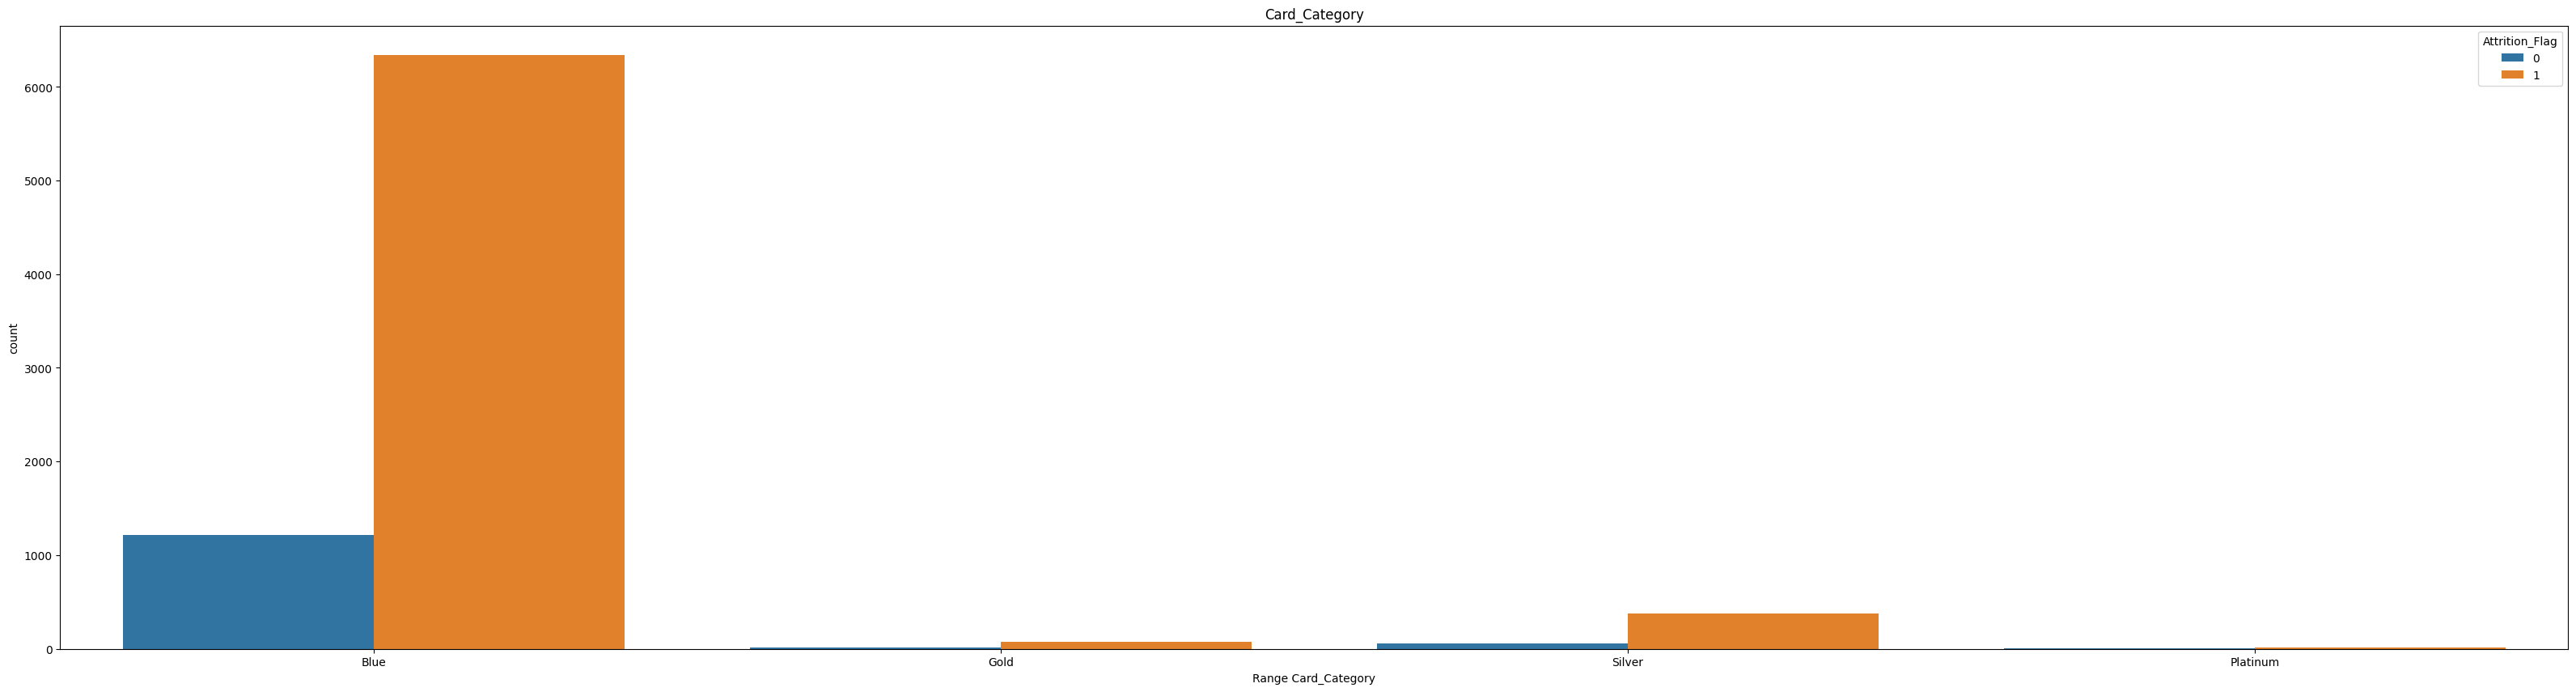

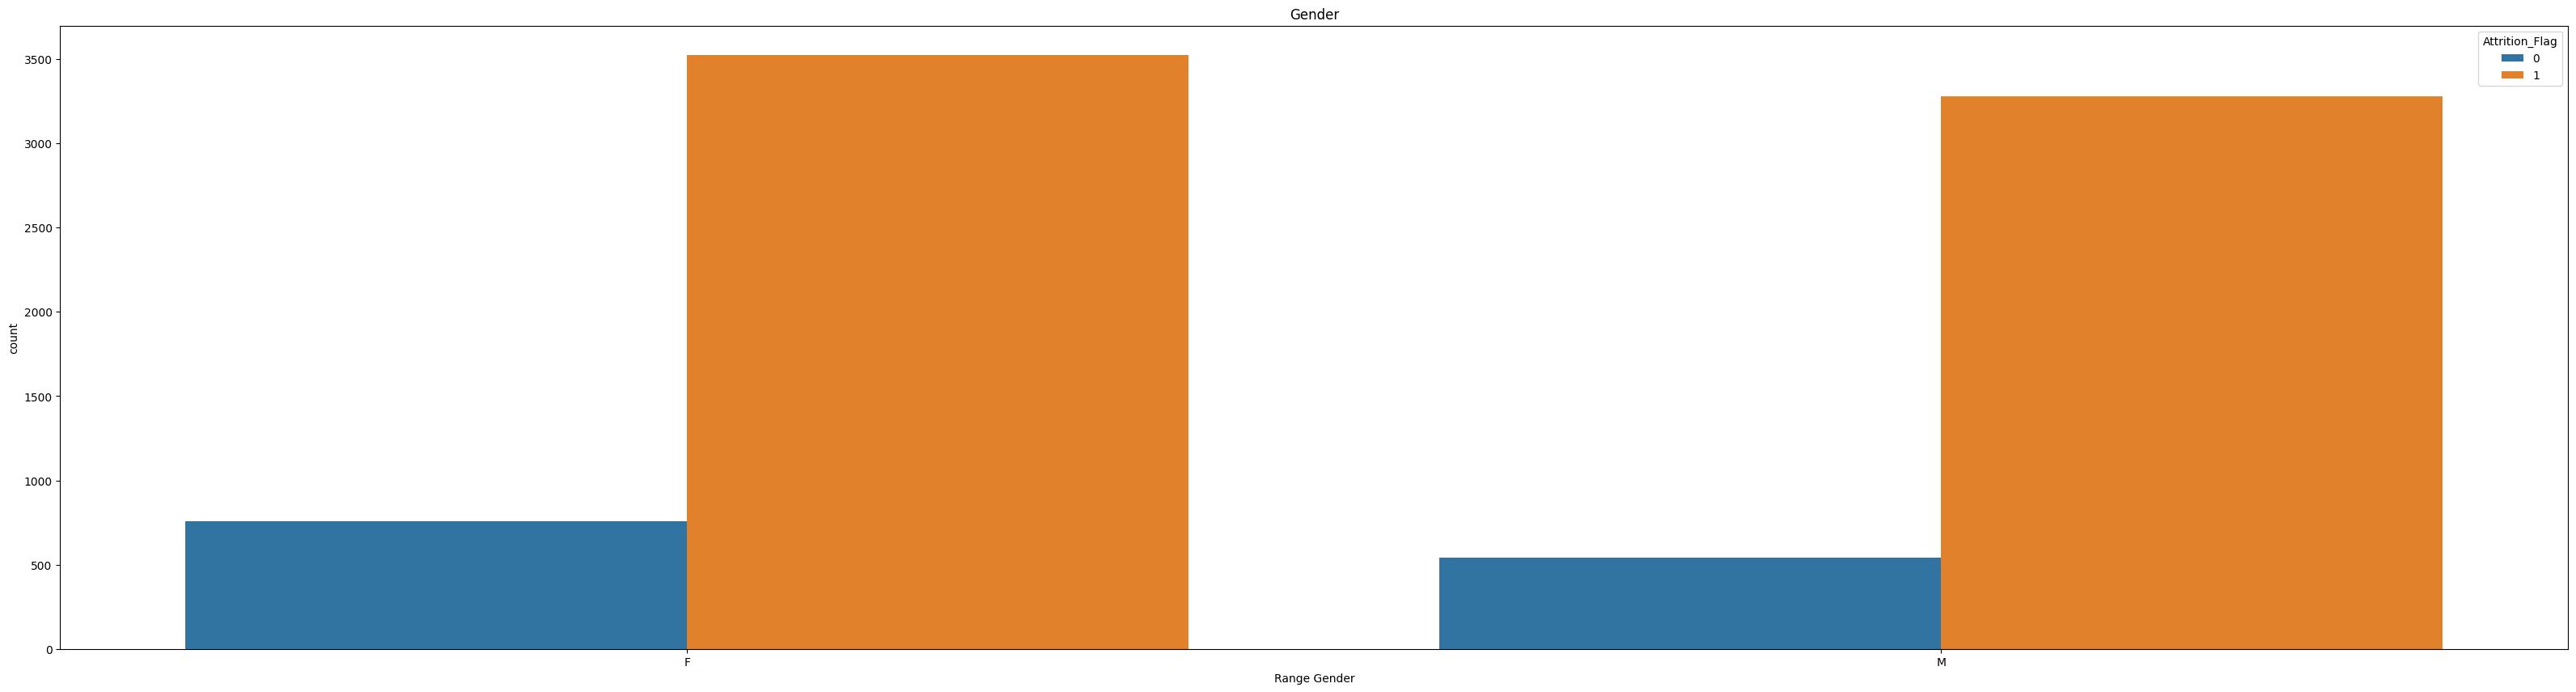

In [ ]:
TargetVariables(df_train, num, cat, binary, target).generate_plots()

- Income_Category: La gente que lo deja suele cobrar menos de 40k 
- Total_Revolving_Bal: La gente que lo deja suele tener un saldo cercano a 0.
- Total_Trans_Amt: La gente que lo deja suele hacer realizado pocas transacciones.
- Avg_Utilization_Ratio: la genteque lo deja no usa mucho el servicio. 

# CLEAN DATA
 

En el proceso de clean data voy a transformar la data manualmente para familiarizarme con el dataset

- Education_Level, Income_Category, Card_Category: Remplazo los valores categoricos nominales, por numeros con sentido estadistico. Los Unknown por -1
- Elimino la columna 'CLIENTNUM', ya que no le va a aportar nada al modelo. 
- La variable train_idx, sera mi nuevo indice.

In [ ]:
# los 0 que no pasen de 1 'Total_Ct_Chng_Q4_Q1'.
# los 0 que no pasen de 60 y los 1 hacia arriba Total_Trans_Ct
# Total_trans_Amt 0 por debajo de 3000
# Total_Revolving_Bal 0 abajo de 500

In [ ]:
df_train.describe()

In [ ]:
df_filtrado = df_train.loc[(df_train['Total_Ct_Chng_Q4_Q1'] > 1) & (df_train['Attrition_Flag'] == 0)]
# 33rows
df_filtrado

In [ ]:
df_filtrado = df_train.loc[(df_train['Total_Ct_Chng_Q4_Q1'] <= 1) & (df_train['Attrition_Flag'] == 1)]
# nada
df_filtrado

In [ ]:
df_filtrado = df_train.loc[(df_train['Total_Trans_Ct'] > 60) & (df_train['Attrition_Flag'] == 0)]
# 176rows
df_filtrado

In [ ]:
df_filtrado = df_train.loc[(df_train['Total_Trans_Ct'] < 60) & (df_train['Attrition_Flag'] == 1)]
# 2035rows
df_filtrado

In [ ]:
df_filtrado = df_train.loc[(df_train['Total_Trans_Amt'] > 3000) & (df_train['Attrition_Flag'] == 0)]
# 257rows
df_filtrado

In [ ]:
df_filtrado = df_train.loc[(df_train['Total_Trans_Amt'] < 3000) & (df_train['Attrition_Flag'] == 1)]
# 2074rows
df_filtrado

In [ ]:
df_filtrado = df_train.loc[(df_train['Total_Revolving_Bal'] > 500) & (df_train['Attrition_Flag'] == 0)]
# 497rows
df_filtrado

In [ ]:
df_filtrado = df_train.loc[(df_train['Total_Revolving_Bal'] < 500) & (df_train['Attrition_Flag'] == 1)]
# 1288rows
df_filtrado

In [ ]:
drop_Total_Revolving_Bal = df_train.loc[(df_train['Total_Revolving_Bal'] < 500) & (df_train['Attrition_Flag'] == 1)].index
df_train = df_train.drop(index=drop_Total_Revolving_Bal)
drop_Total_Revolving_Bal = df_train.loc[(df_train['Total_Ct_Chng_Q4_Q1'] <= 1) & (df_train['Attrition_Flag'] == 1)].index
df_train = df_train.drop(index=drop_Total_Revolving_Bal)
drop_Total_Revolving_Bal = df_train.loc[(df_train['Total_Trans_Ct'] <= 60) & (df_train['Attrition_Flag'] == 1)].index
df_train = df_train.drop(index=drop_Total_Revolving_Bal)
drop_Total_Revolving_Bal = df_train.loc[(df_train['Total_Trans_Amt'] < 3000) & (df_train['Attrition_Flag'] == 1)].index
df_train = df_train.drop(index=drop_Total_Revolving_Bal)
df_train


In [ ]:
drop_Total_Revolving_Bal = df_train.loc[(df_train['Total_Revolving_Bal'] > 500) & (df_train['Attrition_Flag'] == 0)].index
df_train = df_train.drop(index=drop_Total_Revolving_Bal)


In [ ]:
drop_Total_Trans_Amt = df_train.loc[(df_train['Total_Trans_Amt'] > 4000) & (df_train['Attrition_Flag'] == 0)].index
df_train = df_train.drop(index=drop_Total_Trans_Amt)


In [ ]:
drop_Total_Trans_Ct = df_train.loc[(df_train['Total_Trans_Ct'] > 60) & (df_train['Attrition_Flag'] == 0)].index
df_train = df_train.drop(index=drop_Total_Trans_Ct)


In [ ]:
drop_Total_Revolving_Bal = df_train.loc[(df_train['Total_Ct_Chng_Q4_Q1'] > 1.2) & (df_train['Attrition_Flag'] == 0)].index
df_train = df_train.drop(index=drop_Total_Revolving_Bal)
df_train

,train_idx,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,0,713071383,54,F,1,Unknown,Single,Unknown,Blue,36,...,3,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464,1
2,2,718206783,45,F,4,Unknown,Single,Less than $40K,Gold,36,...,3,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103,1
3,3,721096983,34,F,2,Graduate,Single,Less than $40K,Blue,36,...,4,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694,1
4,4,720028683,49,F,2,High School,Married,$40K - $60K,Blue,39,...,4,2720.0,1926,794.0,0.602,3806,61,0.794,0.708,1
5,5,778942233,60,F,0,Doctorate,Married,Less than $40K,Blue,45,...,4,1438.3,648,790.3,0.477,1267,27,1.077,0.451,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,8095,718148358,50,F,3,High School,Married,Less than $40K,Blue,36,...,3,1572.0,0,1572.0,0.740,2447,41,0.577,0.000,0
8097,8097,714406158,53,F,3,High School,Divorced,Unknown,Blue,36,...,6,7939.0,0,7939.0,0.551,2269,42,0.312,0.000,0
8098,8098,714140133,42,F,4,Graduate,Unknown,Less than $40K,Blue,32,...,2,2314.0,1547,767.0,0.804,4678,74,1.000,0.669,1
8099,8099,720244983,40,M,3,Unknown,Single,$40K - $60K,Blue,28,...,1,3563.0,1707,1856.0,0.506,1482,42,0.312,0.479,1


In [ ]:
df_train['Attrition_Flag'].value_counts()

1    6801
0     685
Name: Attrition_Flag, dtype: int64

In [ ]:
df_sub = df_train[df_train['Attrition_Flag'] == 0]
df_sub

df_train = pd.concat([df_train, df_sub], axis=0)
df_train = pd.concat([df_train, df_sub], axis=0)
df_train = pd.concat([df_train, df_sub], axis=0)
df_train = pd.concat([df_train, df_sub], axis=0)
df_train

# df_train = df_train.drop(df_train[df_train['Attrition_Flag'] == 1].index[:500], axis=0)
df_train['Attrition_Flag'].value_counts()

1    6801
0    6500
Name: Attrition_Flag, dtype: int64

In [ ]:
df_train

,train_idx,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,0,713071383,54,F,1,Unknown,Single,Unknown,Blue,36,...,3,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464,1
1,1,714246333,58,F,4,High School,Married,Unknown,Blue,48,...,3,5396.0,1803,3593.0,0.493,2107,39,0.393,0.334,0
2,2,718206783,45,F,4,Unknown,Single,Less than $40K,Gold,36,...,3,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103,1
3,3,721096983,34,F,2,Graduate,Single,Less than $40K,Blue,36,...,4,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694,1
4,4,720028683,49,F,2,High School,Married,$40K - $60K,Blue,39,...,4,2720.0,1926,794.0,0.602,3806,61,0.794,0.708,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,8096,769053033,44,F,1,Graduate,Single,$40K - $60K,Blue,38,...,5,4142.0,2517,1625.0,0.809,2104,44,0.833,0.608,0
8097,8097,714406158,53,F,3,High School,Divorced,Unknown,Blue,36,...,6,7939.0,0,7939.0,0.551,2269,42,0.312,0.000,0
8098,8098,714140133,42,F,4,Graduate,Unknown,Less than $40K,Blue,32,...,2,2314.0,1547,767.0,0.804,4678,74,1.000,0.669,1
8099,8099,720244983,40,M,3,Unknown,Single,$40K - $60K,Blue,28,...,1,3563.0,1707,1856.0,0.506,1482,42,0.312,0.479,1


In [ ]:
# df_train = unknown(df_train, 'Education_Level', 'Education_Level_Unknown')
# df_train = unknown(df_train, 'Income_Category', 'Income_Category_Unknown')
# df_train = df_train['Education_Level'].replace('Unkown', -1, inplace=True)
# df_train = df_train['Income_Category'].replace('Unkown', -1, inplace=True)
df_train

,train_idx,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,0,713071383,54,F,1,Unknown,Single,Unknown,Blue,36,...,3,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464,1
1,1,714246333,58,F,4,High School,Married,Unknown,Blue,48,...,3,5396.0,1803,3593.0,0.493,2107,39,0.393,0.334,0
2,2,718206783,45,F,4,Unknown,Single,Less than $40K,Gold,36,...,3,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103,1
3,3,721096983,34,F,2,Graduate,Single,Less than $40K,Blue,36,...,4,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694,1
4,4,720028683,49,F,2,High School,Married,$40K - $60K,Blue,39,...,4,2720.0,1926,794.0,0.602,3806,61,0.794,0.708,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,8096,769053033,44,F,1,Graduate,Single,$40K - $60K,Blue,38,...,5,4142.0,2517,1625.0,0.809,2104,44,0.833,0.608,0
8097,8097,714406158,53,F,3,High School,Divorced,Unknown,Blue,36,...,6,7939.0,0,7939.0,0.551,2269,42,0.312,0.000,0
8098,8098,714140133,42,F,4,Graduate,Unknown,Less than $40K,Blue,32,...,2,2314.0,1547,767.0,0.804,4678,74,1.000,0.669,1
8099,8099,720244983,40,M,3,Unknown,Single,$40K - $60K,Blue,28,...,1,3563.0,1707,1856.0,0.506,1482,42,0.312,0.479,1


In [ ]:
df_train['Card_Category'].value_counts()

Blue        7557
Silver       436
Gold          93
Platinum      15
Name: Card_Category, dtype: int64

In [ ]:
# df_train['Education_Level'] = df_train['Education_Level'].replace({'Uneducated': 0,
#                                                  'College': 1,
#                                                  'High School': 2,
#                                                  'Graduate': 3,
#                                                  'Post-Graduate': 4,
#                                                  'Doctorate': 5,
#                                                  'Unknown': -1,
#                                                   })

# df_train['Income_Category'] = df_train['Income_Category'].replace({'Less than $40K': 0,
#                                                  '$40K - $60K': 1,
#                                                  '$80K - $120K': 3,
#                                                  '$60K - $80K': 2,
#                                                  '$120K +': 4,
#                                                  'Unknown': -1,
#                                                   })

# df_train['Card_Category'] = df_train['Card_Category'].replace({'Blue': 0,
#                                                  'Silver': 1,
#                                                  'Gold': 2,
#                                                  'Platinum': 3,
#                                                   })
# df_train

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   train_idx                 8101 non-null   int64  
 1   CLIENTNUM                 8101 non-null   int64  
 2   Customer_Age              8101 non-null   int64  
 3   Gender                    8101 non-null   object 
 4   Dependent_count           8101 non-null   int64  
 5   Education_Level           8101 non-null   object 
 6   Marital_Status            8101 non-null   object 
 7   Income_Category           8101 non-null   object 
 8   Card_Category             8101 non-null   object 
 9   Months_on_book            8101 non-null   int64  
 10  Total_Relationship_Count  8101 non-null   int64  
 11  Months_Inactive_12_mon    8101 non-null   int64  
 12  Contacts_Count_12_mon     8101 non-null   int64  
 13  Credit_Limit              8101 non-null   float64
 14  Total_Re

In [ ]:
# df_train.drop(['CLIENTNUM'], axis=1, inplace=True)
# df_train.set_index(['train_idx'], inplace=True)
# df_train

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8101 entries, 0 to 8100
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   train_idx                 8101 non-null   int64  
 1   CLIENTNUM                 8101 non-null   int64  
 2   Customer_Age              8101 non-null   int64  
 3   Gender                    8101 non-null   object 
 4   Dependent_count           8101 non-null   int64  
 5   Education_Level           8101 non-null   object 
 6   Marital_Status            8101 non-null   object 
 7   Income_Category           8101 non-null   object 
 8   Card_Category             8101 non-null   object 
 9   Months_on_book            8101 non-null   int64  
 10  Total_Relationship_Count  8101 non-null   int64  
 11  Months_Inactive_12_mon    8101 non-null   int64  
 12  Contacts_Count_12_mon     8101 non-null   int64  
 13  Credit_Limit              8101 non-null   float64
 14  Total_Re

In [ ]:
# le = LabelEncoder()
# df_train['Gender'] = le.fit_transform(df_train['Gender'])
# df_train['Marital_Status'] = le.fit_transform(df_train['Marital_Status'])

In [ ]:
df_train

In [ ]:
# df_train = unknown(df_train, 'Education_Level', 'Education_Level_Unknown')
# df_train = unknown(df_train, 'Income_Category', 'Income_Category_Unknown')
# # df_train = df_train['Education_Level'].replace('Unkown', -1, inplace=True)
# # df_train = df_train['Income_Category'].replace('Unkown', -1, inplace=True)

# df_test = unknown(df_test, 'Education_Level', 'Education_Level_Unknown')
# df_test = unknown(df_test, 'Income_Category', 'Income_Category_Unknown')
# # df_test = df_test['Education_Level'].replace('Unkown', -1, inplace=True)
# # df_test = df_test['Income_Category'].replace('Unkown', -1, inplace=True)

# df_train['Education_Level'] = df_train['Education_Level'].replace({'Uneducated': 0,
#                                                  'College': 1,
#                                                  'High School': 2,
#                                                  'Graduate': 3,
#                                                  'Post-Graduate': 4,
#                                                  'Doctorate': 5,
#                                                  'Unknown': -1,
#                                                   })

# df_train['Income_Category'] = df_train['Income_Category'].replace({'Less than $40K': 0,
#                                                  '$40K - $60K': 1,
#                                                  '$80K - $120K': 3,
#                                                  '$60K - $80K': 2,
#                                                  '$120K +': 4,
#                                                  'Unknown': -1,
#                                                   })

# df_train['Card_Category'] = df_train['Card_Category'].replace({'Blue': 0,
#                                                  'Silver': 1,
#                                                  'Gold': 2,
#                                                  'Platinum': 3,
#                                                   })

# df_test['Education_Level'] = df_test['Education_Level'].replace({'Uneducated': 0,
#                                                  'College': 1,
#                                                  'High School': 2,
#                                                  'Graduate': 3,
#                                                  'Post-Graduate': 4,
#                                                  'Doctorate': 5,
#                                                  'Unknown': -1,
#                                                   })

# df_test['Income_Category'] = df_test['Income_Category'].replace({'Less than $40K': 0,
#                                                  '$40K - $60K': 1,
#                                                  '$80K - $120K': 3,
#                                                  '$60K - $80K': 2,
#                                                  '$120K +': 4,
#                                                  'Unknown': -1,
#                                                   })

# df_test['Card_Category'] = df_test['Card_Category'].replace({'Blue': 0,
#                                                  'Silver': 1,
#                                                  'Gold': 2,
#                                                  'Platinum': 3,
#                                                   })

# df_train.drop(['CLIENTNUM'], axis=1, inplace=True)
# df_train.set_index(['train_idx'], inplace=True)

# df_test.drop(['CLIENTNUM'], axis=1, inplace=True)
# df_test.set_index(['test_idx'], inplace=True)

# le = LabelEncoder()
# df_train['Gender'] = le.fit_transform(df_train['Gender'])
# df_train['Marital_Status'] = le.fit_transform(df_train['Marital_Status'])

# df_test['Gender'] = le.fit_transform(df_test['Gender'])
# df_test['Marital_Status'] = le.fit_transform(df_test['Marital_Status'])

In [ ]:
# target = 'Attrition_Flag'

# # Mi array X de entrenamiento sera df_train que contiene el target(array y deentrenamiento) y las variables
# X_train = df_train.drop(target, axis=1)
# y_train = df_train[target]

# # Mi array X de test sera df_test que contiene las variables 
# X_test = df_test

# PIPELINE

En el proceso de Pipeline voy a automatizar todas las transformaciones de los datos, para poder tener una sola clase y poder manipular las tranformaciones y estandarizaciones en su totalidad.

In [ ]:
class DataFrameFilterTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns, conditions):
        self.columns = columns
        self.conditions = conditions

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df_train = pd.DataFrame(X, columns=self.columns)
        for column in self.columns:
            for condition, value in self.conditions[column].items():
                if condition == 'drop':
                    index_to_drop = df_train.loc[(df_train[column] > value) & (df_train['Attrition_Flag'] == 0)].index
                    df_train = df_train.drop(index=index_to_drop)
                elif condition == 'filter':
                    df_train = df_train.loc[df_train[column] <= value]
        return df_train.values

In [ ]:
columns = ['Total_Trans_Amt', 'Total_Revolving_Bal', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1']
conditions = {'Total_Trans_Amt': {'drop': 3000}, 
              'Total_Revolving_Bal': {'drop': 500}, 
              'Total_Trans_Ct': {'drop': 60},
              'Total_Ct_Chng_Q4_Q1': {'drop': 1}}

In [ ]:
class UnknownTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = X.copy()
        for col, unknown_col in self.columns.items():
            unknown = df[col] == 'Unknown'
            df[unknown_col] = unknown.astype(int)
        return df

In [ ]:
class CategoricalToNumeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = X.copy()
        df['Education_Level'] = df['Education_Level'].replace({
            'Uneducated': 0,
            'College': 1,
            'High School': 2,
            'Graduate': 3,
            'Post-Graduate': 4,
            'Doctorate': 5,
            'Unknown': -1,
        })

        df['Income_Category'] = df['Income_Category'].replace({
            'Less than $40K': 0,
            '$40K - $60K': 1,
            '$60K - $80K': 2,
            '$80K - $120K': 3,
            '$120K +': 4,
            'Unknown': -1,
        })

        df['Card_Category'] = df['Card_Category'].replace({
            'Blue': 0,
            'Silver': 1,
            'Gold': 2,
            'Platinum': 3,
        })

        return df

In [ ]:
class DataFrameProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, index_column):
        self.index_column = index_column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_train = X.drop(['CLIENTNUM'], axis=1)
        X_train.set_index([self.index_column], inplace=True)
        return X_train

In [ ]:
class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns # lista de columnas a codificar

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        output = X.copy()
        le = LabelEncoder()
        for col in self.columns:
            output[col] = le.fit_transform(output[col])
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [ ]:
# hago una pipe_train porque la variable 'train_idx' solo esta en este dataset
pipe_train = Pipeline(steps=[
    ('UnknownTransformer', UnknownTransformer({'Education_Level': 'Education_Level_Unknown',
                        'Income_Category': 'Income_Category_Unknown'})),  
    ('CategoricalToNumeric', CategoricalToNumeric()),
    ('DataFrameProcessor', DataFrameProcessor('train_idx')),
    ('Encoder', MultiColumnLabelEncoder(columns=['Gender', 'Marital_Status'])),

     
    
])

In [ ]:
# hago una pipe_test porque la variable 'test_idx' solo esta en este dataset
pipe_test = Pipeline(steps=[
    ('UnknownTransformer', UnknownTransformer({'Education_Level': 'Education_Level_Unknown',
                        'Income_Category': 'Income_Category_Unknown'})),  
    ('CategoricalToNumeric', CategoricalToNumeric()),
    ('DataFrameProcessor', DataFrameProcessor('test_idx')),
    ('Encoder', MultiColumnLabelEncoder(columns=['Gender', 'Marital_Status'])),

    
])

In [ ]:
pipe_train = pipe_train.fit_transform(df_train)

In [ ]:
pipe_test = pipe_test.transform(df_test)

# SPLIT

En el apartado de Split, voy a manipular las separaciones de datos. Los datos ya nos han sido separados pero es apra teenr un mejor control.

In [ ]:
pipe_train.columns

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Attrition_Flag', 'Education_Level_Unknown', 'Income_Category_Unknown'],
      dtype='object')

In [ ]:
pipe_test.columns

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Education_Level_Unknown', 'Income_Category_Unknown'],
      dtype='object')

In [ ]:
# pipe_train.drop([
#        'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
#        'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book',
#        'Months_Inactive_12_mon',
#        'Contacts_Count_12_mon', 'Credit_Limit', 
#        'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',  'Avg_Utilization_Ratio',
#         'Education_Level_Unknown', 'Income_Category_Unknown'], axis=1, inplace=True)

In [ ]:
# pipe_test.drop([
#        'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
#        'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book',
#        'Months_Inactive_12_mon',
#        'Contacts_Count_12_mon', 'Credit_Limit', 
#        'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1',  'Avg_Utilization_Ratio',
#        'Education_Level_Unknown', 'Income_Category_Unknown'], axis=1, inplace=True)

In [ ]:
target = 'Attrition_Flag'

# Mi array X de entrenamiento sera df_train que contiene el target(array y deentrenamiento) y las variables
X_train = pipe_train.drop(target, axis=1)
y_train = pipe_train[target]

# Mi array X de test sera df_test que contiene las variables 
X_test = pipe_test

In [ ]:
# Comprobacion variables
X_train

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_Unknown,Income_Category_Unknown
train_idx,,,,,,,,,,,,,,,,,,,,,
0,54,0,1,-1,2,-1,0,36,1,3,...,3723.0,1728,1995.0,0.595,8554,99,0.678,0.464,1,1
1,58,0,4,2,1,-1,0,48,1,4,...,5396.0,1803,3593.0,0.493,2107,39,0.393,0.334,0,1
2,45,0,4,-1,2,0,2,36,6,1,...,15987.0,1648,14339.0,0.732,1436,36,1.250,0.103,1,0
3,34,0,2,3,2,0,0,36,4,3,...,3625.0,2517,1108.0,1.158,2616,46,1.300,0.694,0,0
4,49,0,2,2,1,1,0,39,5,3,...,2720.0,1926,794.0,0.602,3806,61,0.794,0.708,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8096,44,0,1,3,2,1,0,38,3,2,...,4142.0,2517,1625.0,0.809,2104,44,0.833,0.608,0,0
8097,53,0,3,2,0,-1,0,36,4,3,...,7939.0,0,7939.0,0.551,2269,42,0.312,0.000,0,1
8098,42,0,4,3,3,0,0,32,3,1,...,2314.0,1547,767.0,0.804,4678,74,1.000,0.669,0,0


In [ ]:
# Comprobacion target
y_train.to_frame()

,Attrition_Flag
train_idx,
0,1
1,0
2,1
3,1
4,1
...,...
8096,0
8097,0
8098,1


In [ ]:
X_test

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_Unknown,Income_Category_Unknown
test_idx,,,,,,,,,,,,,,,,,,,,,
0,48,0,3,0,2,0,0,39,4,3,...,2991.0,1508,1483.0,0.703,3734,64,0.882,0.504,0,0
1,59,1,1,0,2,0,0,53,5,5,...,2192.0,1569,623.0,0.706,4010,79,0.717,0.716,0,0
2,37,0,2,3,0,0,0,36,4,3,...,1734.0,987,747.0,0.879,4727,67,0.914,0.569,0,0
3,47,1,3,5,0,1,0,36,4,2,...,4786.0,1516,3270.0,0.940,4973,74,0.850,0.317,0,0
4,42,1,3,-1,2,3,0,33,3,3,...,3714.0,2170,1544.0,0.524,1454,35,0.522,0.584,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,34,1,2,3,2,3,0,29,3,1,...,13395.0,1678,11717.0,1.006,2650,69,0.865,0.125,0,0
2022,35,0,1,1,2,0,0,25,2,2,...,2231.0,1791,440.0,0.820,2576,42,0.750,0.803,0,0
2023,44,0,1,0,0,0,0,37,1,2,...,5594.0,1235,4359.0,0.549,5220,75,0.829,0.221,0,0


# MODELS

En el apartado de Models, voy ha hacer diversos modelos de clasificación. El criterio sera un balance entre performance, explicabilidad y rebalanceo de datos.  

In [ ]:
evaluate_classification(label='LogisticRegression', 
                        model=LogisticRegression(), 
                        X=X_train, y=y_train)

evaluate_classification(label='SVC', 
                        model=SVC(), 
                        X=X_train, y=y_train)

evaluate_classification(label='SVC_Rebalanced', 
                        model=SVC(class_weight='balanced'), 
                        X=X_train, y=y_train)

evaluate_classification(label='GradientBoosting', 
                        model=GradientBoostingClassifier(), 
                        X=X_train, y=y_train)

evaluate_classification(label='XGBoost', 
                        model=XGBClassifier(), 
                        X=X_train, y=y_train)

evaluate_classification(label='RandomForestClassifier', 
                        model=RandomForestClassifier(), 
                        X=X_train, y=y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

,Model,F1 Score Train,F1 Score Cross-Valida
4,XGBoost,1.000000,0.989747
5,RandomForestClassifier,1.000000,0.986966
3,GradientBoosting,0.969742,0.965809
0,LogisticRegression,0.800557,0.801759
1,SVC,0.746617,0.743573
2,SVC_Rebalanced,0.743248,0.739385


REBALANCEO DE LA DATA UNDERSAMPLING

In [ ]:
def evaluate_classification(label, model, X, y):
    f1_train = f1_score(y, model.fit(X, y).predict(X))
    f1_valida = f1_cross_validation(model, X, y)                  
    label_.append(label)
    f1_train_.append(f1_train)
    f1_valida_.append(f1_valida)
    return pd.DataFrame({'Model': label_,
                      'F1 Score Train': f1_train_,
                      'F1 Score Cross-Valida': f1_valida_
                      }).sort_values('F1 Score Cross-Valida', ascending=False)



# Rebalanceo usando SMOTE
rebalance = SMOTE(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = rebalance.fit_resample(X_train, y_train)
evaluate_classification('LogisticRegression_SMOTE', LogisticRegression(), X_train_resampled, y_train_resampled)

# Rebalanceo usando RandomUnderSampler
rebalance = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_resampled, y_train_resampled = rebalance.fit_resample(X_train, y_train)
evaluate_classification('SVC_RandomUnderSampler', SVC(), X_train_resampled, y_train_resampled)

# Rebalanceo usando ADASYN
rebalance = ADASYN(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = rebalance.fit_resample(X_train, y_train)
evaluate_classification('XGBoost_ADASYN', XGBClassifier(), X_train_resampled, y_train_resampled)




/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

,Model,F1 Score Train,F1 Score Cross-Valida
4,XGBoost,1.000000,0.984213
3,GradientBoosting,0.986197,0.980841
5,RandomForestClassifier,1.000000,0.976581
8,XGBoost_ADASYN,1.000000,0.975753
0,LogisticRegression,0.928303,0.931872
1,SVC,0.912763,0.912763
6,LogisticRegression_SMOTE,0.800588,0.820509
2,SVC_Rebalanced,0.818265,0.815814
7,SVC_RandomUnderSampler,0.719969,0.706471


REBALANCEO DE DATA CON OVERSAMPLING

In [ ]:
os =  RandomOverSampler(sampling_strategy=0.4, random_state=42)
X_train_res, y_train_res = os.fit_resample(X_train, y_train)
evaluate_classification('XGBoost_Over', XGBClassifier(), X_train_res, y_train_res)

,Model,F1 Score Train,F1 Score Cross-Valida
0,XGBoost_Over,1.0,0.990286
1,XGBoost_Over,1.0,0.988793
3,XGBoost_Over,1.0,0.987436
2,XGBoost_Over,1.0,0.982878


REBALANCEO DE DATOS CON OVER Y PENALIZANDO

In [ ]:
os =  RandomOverSampler(sampling_strategy=0.4, random_state=42)
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

rebalance = ADASYN(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = rebalance.fit_resample(X_train_res, y_train_res)
evaluate_classification('XGBoost_ADASYN', XGBClassifier(), X_train_resampled, y_train_resampled)

RuntimeError: ignored

REBALANCEO CON ENSEMBLE

In [ ]:
bbc = BalancedBaggingClassifier(base_estimator=XGBClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier
# from imblearn.ensemble import BalancedBaggingClassifier
# from sklearn.metrics import make_scorer, recall_score

# # Definir la búsqueda de hiperparámetros
# param_grid = {
#     'base_estimator__max_depth': [3, 5, 7],
#     'base_estimator__learning_rate': [0.1, 0.5, 1.0],
#     'base_estimator__n_estimators': [50, 100, 200],
#     'sampling_strategy': ['auto', 'majority', 0.1, 0.5],
#     'replacement': [False, True]
# }

# # Definir el clasificador y el scoring
# clf = BalancedBaggingClassifier(base_estimator=XGBClassifier())
# scorer = make_scorer(recall_score)

# # Realizar la búsqueda de hiperparámetros
# grid_search = GridSearchCV(clf, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Imprimir los mejores parámetros y el score
# print("Mejores parámetros: ", grid_search.best_params_)
# print("Mejor score: ", grid_search.best_score_)


KeyboardInterrupt: ignored

In [ ]:
bbc = BalancedBaggingClassifier(base_estimator=SVC(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

REBALANCEO NEARMISS

In [ ]:
us = NearMiss(sampling_strategy=0.5, n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

Distribution before resampling Counter({1: 6801, 0: 1300})
Distribution after resampling Counter({1: 2600, 0: 1300})


- 

# TEST MODEL

In [ ]:
GB = GradientBoostingClassifier()
Model_GradientBoostingClassifier = GB.fit(X_train, y_train)

In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))

8101
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

[0.9854696  0.02363847 0.99399531 ... 0.99653776 0.99047229 0.99581721]
[0.99036956 0.99384861 0.99140461 ... 0.99414643 0.74553172 0.98531681]


In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

AUC Train: 0.9951


In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)

{'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1, '10': 1, '11': 1, '12': 1, '13': 0, '14': 1, '15': 1, '16': 1, '17': 1, '18': 1, '19': 1, '20': 1, '21': 1, '22': 1, '23': 1, '24': 1, '25': 1, '26': 1, '27': 1, '28': 1, '29': 1, '30': 1, '31': 0, '32': 1, '33': 1, '34': 0, '35': 1, '36': 1, '37': 1, '38': 1, '39': 1, '40': 1, '41': 1, '42': 1, '43': 1, '44': 1, '45': 1, '46': 1, '47': 1, '48': 1, '49': 1, '50': 0, '51': 1, '52': 1, '53': 1, '54': 1, '55': 1, '56': 1, '57': 1, '58': 1, '59': 1, '60': 1, '61': 1, '62': 1, '63': 1, '64': 1, '65': 1, '66': 0, '67': 1, '68': 1, '69': 1, '70': 0, '71': 0, '72': 1, '73': 1, '74': 1, '75': 1, '76': 1, '77': 1, '78': 1, '79': 1, '80': 1, '81': 0, '82': 1, '83': 1, '84': 1, '85': 1, '86': 1, '87': 1, '88': 1, '89': 1, '90': 1, '91': 1, '92': 1, '93': 1, '94': 1, '95': 1, '96': 0, '97': 1, '98': 1, '99': 1, '100': 1, '101': 1, '102': 1, '103': 1, '104': 0, '105': 1, '106': 1, '107': 1, '108': 1, '109': 1, '110': 1,

In [ ]:
d = pd.Series(diccionario)
d.to_frame().value_counts()

1    1733
0     293
dtype: int64

In [ ]:
# resultado = {k: int(v) if isinstance(v, (int, np.integer)) else v for k, v in resultado.items()}
# resultado = {k: int(v) if isinstance(v, np.int64) else v for k, v in resultado.items()}
# resultado = {k: int(v) if isinstance(v, np.float64) else v for k, v in resultado.items()} 

resultado = json.dumps(resultado, default=int)
with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 1, "1": 1, "2": 1, "3": 1, "4": 1, "5": 1, "6": 1, "7": 1, "8": 1, "9": 1, "10": 1, "11": 1, "12": 1, "13": 0, "14": 1, "15": 1, "16": 1, "17": 1, "18": 1, "19": 1, "20": 1, "21": 1, "22": 1, "23": 1, "24": 1, "25": 1, "26": 1, "27": 1, "28": 1, "29": 1, "30": 1, "31": 0, "32": 1, "33": 1, "34": 0, "35": 1, "36": 1, "37": 1, "38": 1, "39": 1, "40": 1, "41": 1, "42": 1, "43": 1, "44": 1, "45": 1, "46": 1, "47": 1, "48": 1, "49": 1, "50": 0, "51": 1, "52": 1, "53": 1, "54": 1, "55": 1, "56": 1, "57": 1, "58": 1, "59": 1, "60": 1, "61": 1, "62": 1, "63": 1, "64": 1, "65": 1, "66": 0, "67": 1, "68": 1, "69": 1, "70": 0, "71": 0, "72": 1, "73": 1, "74": 1, "75": 1, "76": 1, "77": 1, "78": 1, "79": 1, "80": 1, "81": 0, "82": 1, "83": 1, "84": 1, "85": 1, "86": 1, "87": 1, "88": 1, "89": 1, "90": 1, "91": 1, "92": 1, "93": 1, "94": 1, "95": 1, "96": 0, "97": 1, "98": 1, "99": 1, "100": 1, "101": 1, "102": 1, "103": 1, "104": 0, "105": 1, "106": 1, "107": 1, "108": 1, "109": 1

# INTERPRETABILITY

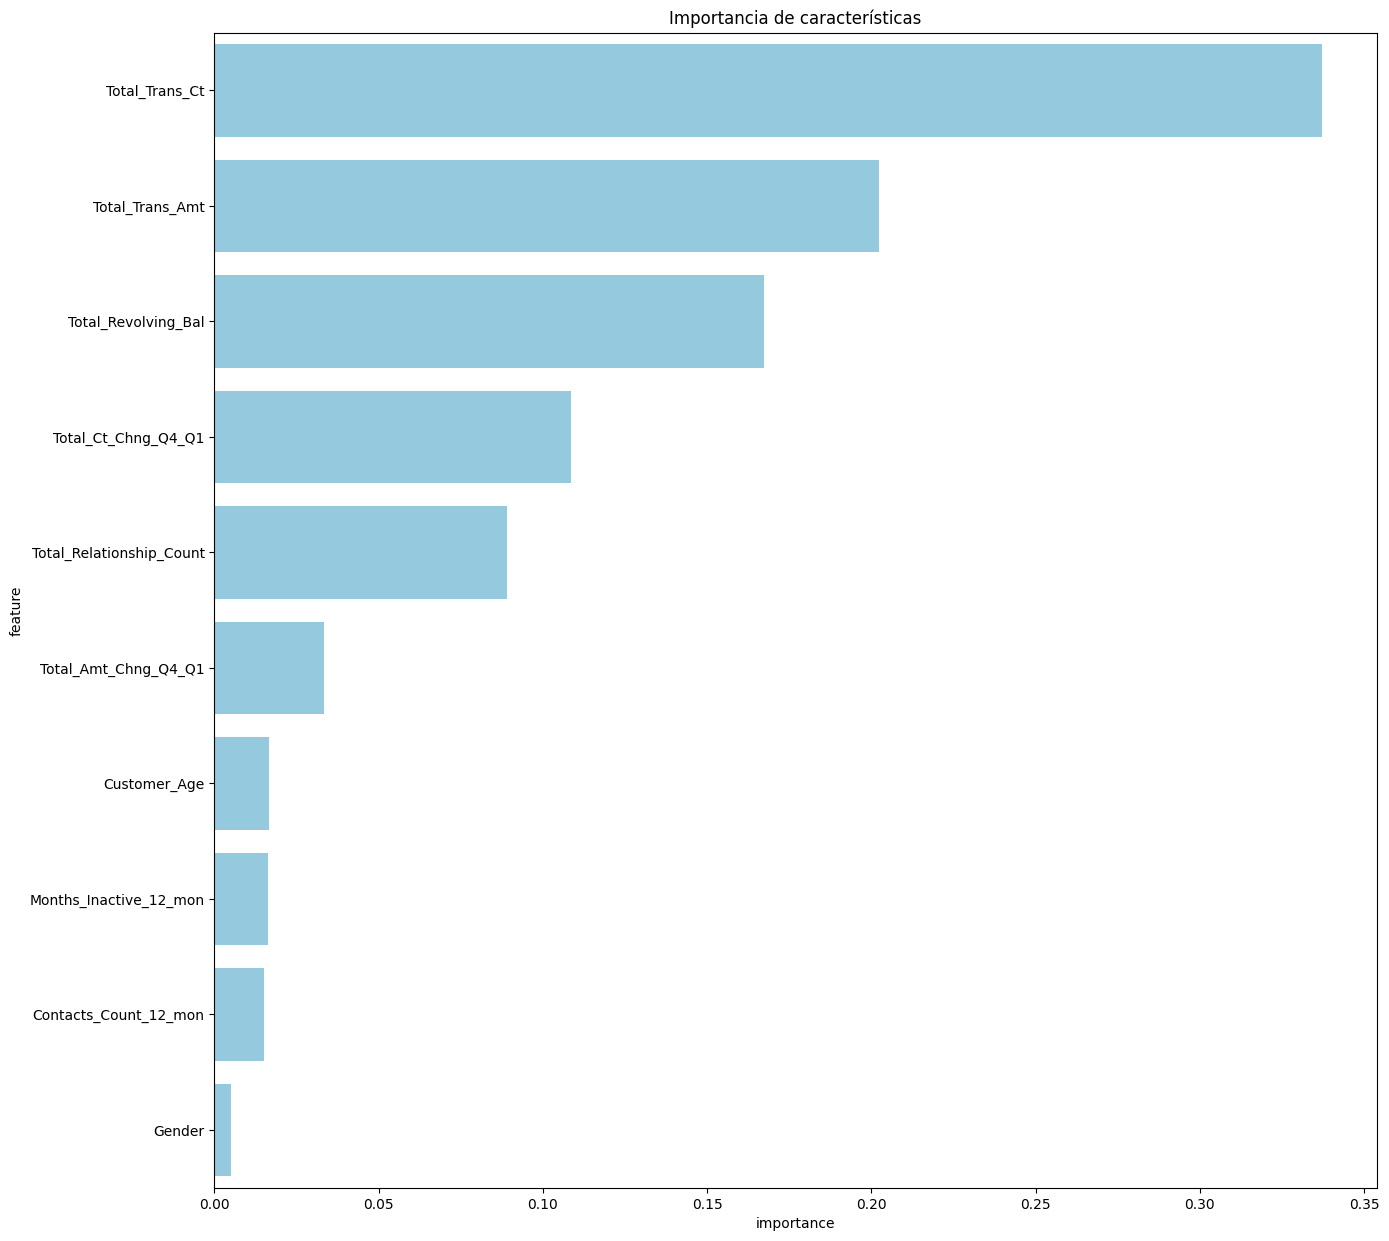

,feature,importance
0,Total_Trans_Ct,0.337034
1,Total_Trans_Amt,0.202304
2,Total_Revolving_Bal,0.167279
3,Total_Ct_Chng_Q4_Q1,0.108446
4,Total_Relationship_Count,0.088922
5,Total_Amt_Chng_Q4_Q1,0.033510
6,Customer_Age,0.016503
7,Months_Inactive_12_mon,0.016366
8,Contacts_Count_12_mon,0.015187
9,Gender,0.005031


In [ ]:
feature_importance(Model_GradientBoostingClassifier, X_train)

# CLUSTER

In [ ]:
# Hacer una copia de y_train antes de añadir las etiquetas de los clusters
y_train_orig = y_train.copy()

# Inicializar KMeans con 2 clusters
kmeans_X = KMeans(n_clusters=2)
kmeans_y = KMeans(n_clusters=2)

# Realizar clustering en X_train y y_train_orig
kmeans_X.fit(X_train)
kmeans_y.fit(y_train_orig.values.reshape(-1, 1))

# Añadir etiquetas de cluster a X_train y y_train
X_train["cluster"] = kmeans_X.labels_
y_train["cluster"] = kmeans_y.labels_

# Obtener el tamaño de cada cluster en X_train
print(X_train.groupby("cluster").size())

# Quedarse con las filas de X_train y y_train que pertenecen al primer cluster
X_train = X_train[X_train["cluster"] == 0].drop("cluster", axis=1)
y_train = y_train_orig[X_train.index]

# TEST MODEL. svc 0.28

In [ ]:
rebalance = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train_resampled, y_train_resampled = rebalance.fit_resample(X_train, y_train)

In [ ]:
GB = SVC()
Model_GradientBoostingClassifier = GB.fit(X_train_resampled, y_train_resampled)

In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))

8101
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

AttributeError: ignored

In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

AUC Train: 0.9991


In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)

{'0': 1, '1': 1, '2': 1, '3': 1, '4': 0, '5': 0, '6': 1, '7': 0, '8': 1, '9': 0, '10': 1, '11': 1, '12': 1, '13': 0, '14': 1, '15': 1, '16': 0, '17': 1, '18': 0, '19': 1, '20': 1, '21': 1, '22': 1, '23': 1, '24': 1, '25': 1, '26': 0, '27': 1, '28': 0, '29': 1, '30': 1, '31': 1, '32': 1, '33': 0, '34': 0, '35': 0, '36': 0, '37': 1, '38': 1, '39': 1, '40': 0, '41': 0, '42': 0, '43': 0, '44': 1, '45': 1, '46': 1, '47': 1, '48': 1, '49': 1, '50': 0, '51': 1, '52': 1, '53': 0, '54': 1, '55': 0, '56': 0, '57': 1, '58': 1, '59': 0, '60': 1, '61': 1, '62': 0, '63': 1, '64': 1, '65': 0, '66': 0, '67': 1, '68': 0, '69': 1, '70': 0, '71': 0, '72': 0, '73': 1, '74': 1, '75': 1, '76': 1, '77': 1, '78': 1, '79': 1, '80': 1, '81': 0, '82': 1, '83': 1, '84': 1, '85': 1, '86': 1, '87': 1, '88': 1, '89': 0, '90': 0, '91': 1, '92': 1, '93': 1, '94': 1, '95': 1, '96': 0, '97': 0, '98': 0, '99': 1, '100': 1, '101': 0, '102': 0, '103': 1, '104': 0, '105': 0, '106': 1, '107': 1, '108': 0, '109': 1, '110': 0,

In [ ]:

resultado = json.dumps(resultado, default=int)
with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 1, "1": 1, "2": 1, "3": 1, "4": 0, "5": 0, "6": 1, "7": 0, "8": 1, "9": 0, "10": 1, "11": 1, "12": 1, "13": 0, "14": 1, "15": 1, "16": 0, "17": 1, "18": 0, "19": 1, "20": 1, "21": 1, "22": 1, "23": 1, "24": 1, "25": 1, "26": 0, "27": 1, "28": 0, "29": 1, "30": 1, "31": 1, "32": 1, "33": 0, "34": 0, "35": 0, "36": 0, "37": 1, "38": 1, "39": 1, "40": 0, "41": 0, "42": 0, "43": 0, "44": 1, "45": 1, "46": 1, "47": 1, "48": 1, "49": 1, "50": 0, "51": 1, "52": 1, "53": 0, "54": 1, "55": 0, "56": 0, "57": 1, "58": 1, "59": 0, "60": 1, "61": 1, "62": 0, "63": 1, "64": 1, "65": 0, "66": 0, "67": 1, "68": 0, "69": 1, "70": 0, "71": 0, "72": 0, "73": 1, "74": 1, "75": 1, "76": 1, "77": 1, "78": 1, "79": 1, "80": 1, "81": 0, "82": 1, "83": 1, "84": 1, "85": 1, "86": 1, "87": 1, "88": 1, "89": 0, "90": 0, "91": 1, "92": 1, "93": 1, "94": 1, "95": 1, "96": 0, "97": 0, "98": 0, "99": 1, "100": 1, "101": 0, "102": 0, "103": 1, "104": 0, "105": 0, "106": 1, "107": 1, "108": 0, "109": 1

- 

# TEST MODEL. xgb 0.37

In [ ]:
rebalance = ADASYN(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = rebalance.fit_resample(X_train, y_train)

In [ ]:
GB = XGBClassifier()
Model_GradientBoostingClassifier = GB.fit(X_train_resampled, y_train_resampled)

In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))
y_test_pred.vale_counts()

8101
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

AttributeError: ignored

In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

AUC Train: 0.9951


In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)

{'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 0, '10': 1, '11': 1, '12': 1, '13': 0, '14': 1, '15': 1, '16': 1, '17': 1, '18': 1, '19': 1, '20': 1, '21': 1, '22': 1, '23': 1, '24': 1, '25': 1, '26': 1, '27': 1, '28': 0, '29': 1, '30': 1, '31': 0, '32': 1, '33': 1, '34': 0, '35': 1, '36': 1, '37': 1, '38': 1, '39': 1, '40': 0, '41': 1, '42': 1, '43': 1, '44': 1, '45': 1, '46': 1, '47': 1, '48': 1, '49': 1, '50': 0, '51': 1, '52': 1, '53': 1, '54': 1, '55': 1, '56': 1, '57': 1, '58': 1, '59': 1, '60': 1, '61': 1, '62': 1, '63': 1, '64': 1, '65': 0, '66': 0, '67': 1, '68': 1, '69': 1, '70': 0, '71': 0, '72': 1, '73': 1, '74': 1, '75': 1, '76': 1, '77': 1, '78': 1, '79': 1, '80': 1, '81': 0, '82': 1, '83': 1, '84': 1, '85': 1, '86': 1, '87': 1, '88': 1, '89': 1, '90': 1, '91': 1, '92': 1, '93': 1, '94': 1, '95': 1, '96': 0, '97': 0, '98': 1, '99': 1, '100': 1, '101': 1, '102': 1, '103': 1, '104': 0, '105': 1, '106': 1, '107': 0, '108': 1, '109': 1, '110': 1,

In [ ]:
resultado = {k: int(v) if isinstance(v, (int, np.integer)) else v for k, v in resultado.items()}
resultado = {k: int(v) if isinstance(v, np.int64) else v for k, v in resultado.items()}
resultado = {k: int(v) if isinstance(v, np.float64) else v for k, v in resultado.items()} 
resultado = json.dumps(resultado, default=str)
with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 1, "10": 0, "11": 0, "12": 0, "13": 1, "14": 0, "15": 0, "16": 0, "17": 0, "18": 0, "19": 0, "20": 0, "21": 0, "22": 0, "23": 0, "24": 0, "25": 0, "26": 0, "27": 0, "28": 1, "29": 0, "30": 0, "31": 1, "32": 0, "33": 0, "34": 1, "35": 0, "36": 0, "37": 0, "38": 0, "39": 0, "40": 1, "41": 0, "42": 0, "43": 0, "44": 0, "45": 0, "46": 0, "47": 0, "48": 0, "49": 0, "50": 1, "51": 0, "52": 0, "53": 0, "54": 0, "55": 0, "56": 0, "57": 0, "58": 0, "59": 0, "60": 0, "61": 0, "62": 0, "63": 0, "64": 0, "65": 1, "66": 1, "67": 0, "68": 0, "69": 0, "70": 1, "71": 1, "72": 0, "73": 0, "74": 0, "75": 0, "76": 0, "77": 0, "78": 0, "79": 0, "80": 0, "81": 1, "82": 0, "83": 0, "84": 0, "85": 0, "86": 0, "87": 0, "88": 0, "89": 0, "90": 0, "91": 0, "92": 0, "93": 0, "94": 0, "95": 0, "96": 1, "97": 1, "98": 0, "99": 0, "100": 0, "101": 0, "102": 0, "103": 0, "104": 1, "105": 0, "106": 0, "107": 1, "108": 0, "109": 0

- 

# TEST MODEL. xgb 0.34 (0.7) o.37 (0.4)

In [ ]:
GB = XGBClassifier()
Model_GradientBoostingClassifier = GB.fit(X_train_res, y_train_res)

In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))


8101
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

[9.9972278e-01 6.7922490e-05 9.9998391e-01 ... 9.9999833e-01 9.9944764e-01
 9.9995029e-01]
[0.99987376 0.9999584  0.9998122  ... 0.9996811  0.9947807  0.9955057 ]


In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

AUC Train: 1.0


In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)
s = pd.Series(resultado)
s

{'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1, '10': 1, '11': 1, '12': 1, '13': 0, '14': 1, '15': 1, '16': 1, '17': 1, '18': 1, '19': 1, '20': 1, '21': 1, '22': 1, '23': 1, '24': 1, '25': 1, '26': 1, '27': 1, '28': 1, '29': 1, '30': 1, '31': 0, '32': 1, '33': 1, '34': 0, '35': 1, '36': 1, '37': 1, '38': 1, '39': 1, '40': 1, '41': 1, '42': 1, '43': 1, '44': 1, '45': 1, '46': 1, '47': 1, '48': 1, '49': 1, '50': 0, '51': 1, '52': 1, '53': 1, '54': 1, '55': 1, '56': 1, '57': 1, '58': 1, '59': 1, '60': 1, '61': 1, '62': 1, '63': 1, '64': 1, '65': 0, '66': 0, '67': 1, '68': 1, '69': 1, '70': 0, '71': 0, '72': 1, '73': 1, '74': 1, '75': 1, '76': 1, '77': 1, '78': 1, '79': 1, '80': 1, '81': 0, '82': 1, '83': 1, '84': 1, '85': 1, '86': 1, '87': 1, '88': 1, '89': 1, '90': 1, '91': 1, '92': 1, '93': 1, '94': 1, '95': 1, '96': 0, '97': 1, '98': 1, '99': 1, '100': 1, '101': 1, '102': 1, '103': 1, '104': 0, '105': 1, '106': 1, '107': 1, '108': 1, '109': 1, '110': 1,

target    {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...
dtype: object

In [ ]:

resultado = json.dumps(resultado, default=int)
with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "11": 0, "12": 0, "13": 1, "14": 0, "15": 0, "16": 0, "17": 0, "18": 0, "19": 0, "20": 0, "21": 0, "22": 0, "23": 0, "24": 0, "25": 0, "26": 0, "27": 0, "28": 0, "29": 0, "30": 0, "31": 1, "32": 0, "33": 0, "34": 1, "35": 0, "36": 0, "37": 0, "38": 0, "39": 0, "40": 0, "41": 0, "42": 0, "43": 0, "44": 0, "45": 0, "46": 0, "47": 0, "48": 0, "49": 0, "50": 1, "51": 0, "52": 0, "53": 0, "54": 0, "55": 0, "56": 0, "57": 0, "58": 0, "59": 0, "60": 0, "61": 0, "62": 0, "63": 0, "64": 0, "65": 1, "66": 1, "67": 0, "68": 0, "69": 0, "70": 1, "71": 1, "72": 0, "73": 0, "74": 0, "75": 0, "76": 0, "77": 0, "78": 0, "79": 0, "80": 0, "81": 1, "82": 0, "83": 0, "84": 0, "85": 0, "86": 0, "87": 0, "88": 0, "89": 0, "90": 0, "91": 0, "92": 0, "93": 0, "94": 0, "95": 0, "96": 1, "97": 0, "98": 0, "99": 0, "100": 0, "101": 0, "102": 0, "103": 0, "104": 1, "105": 0, "106": 0, "107": 0, "108": 0, "109": 0

- 

# TEST MODEL. xgb 0.41 under y over

In [ ]:
GB = XGBClassifier()
Model_GradientBoostingClassifier = GB.fit(X_train_resampled, y_train_resampled)

NameError: ignored

In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))


1301
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

[4.46942451e-07 3.22276426e-07 5.92977186e-07 ... 5.22790689e-07
 1.24770424e-06 9.99984223e-01]
[5.22790689e-07 9.49229998e-05 5.97235020e-07 ... 1.40582242e-06
 3.63543076e-07 5.23785866e-07]


In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

AUC Train: 1.0


In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)
s = pd.Series(resultado)
s

{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0, '27': 0, '28': 0, '29': 1, '30': 0, '31': 0, '32': 1, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0, '43': 0, '44': 0, '45': 0, '46': 1, '47': 1, '48': 1, '49': 1, '50': 0, '51': 1, '52': 0, '53': 0, '54': 0, '55': 0, '56': 0, '57': 0, '58': 0, '59': 0, '60': 0, '61': 1, '62': 0, '63': 0, '64': 0, '65': 0, '66': 0, '67': 0, '68': 0, '69': 0, '70': 0, '71': 0, '72': 0, '73': 0, '74': 0, '75': 1, '76': 0, '77': 0, '78': 0, '79': 1, '80': 0, '81': 0, '82': 0, '83': 0, '84': 0, '85': 0, '86': 0, '87': 0, '88': 0, '89': 0, '90': 0, '91': 0, '92': 0, '93': 0, '94': 0, '95': 0, '96': 0, '97': 0, '98': 0, '99': 1, '100': 0, '101': 0, '102': 0, '103': 1, '104': 0, '105': 0, '106': 0, '107': 0, '108': 0, '109': 0, '110': 0,

target    {'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': ...
dtype: object

In [ ]:

resultado = json.dumps(resultado, default=int)
with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 1, "1": 1, "2": 1, "3": 1, "4": 1, "5": 1, "6": 1, "7": 1, "8": 1, "9": 1, "10": 1, "11": 1, "12": 1, "13": 1, "14": 1, "15": 1, "16": 1, "17": 1, "18": 1, "19": 1, "20": 1, "21": 1, "22": 1, "23": 1, "24": 1, "25": 1, "26": 1, "27": 1, "28": 1, "29": 0, "30": 1, "31": 1, "32": 0, "33": 1, "34": 1, "35": 1, "36": 1, "37": 1, "38": 1, "39": 1, "40": 1, "41": 1, "42": 1, "43": 1, "44": 1, "45": 1, "46": 0, "47": 0, "48": 0, "49": 0, "50": 1, "51": 0, "52": 1, "53": 1, "54": 1, "55": 1, "56": 1, "57": 1, "58": 1, "59": 1, "60": 1, "61": 0, "62": 1, "63": 1, "64": 1, "65": 1, "66": 1, "67": 1, "68": 1, "69": 1, "70": 1, "71": 1, "72": 1, "73": 1, "74": 1, "75": 0, "76": 1, "77": 1, "78": 1, "79": 0, "80": 1, "81": 1, "82": 1, "83": 1, "84": 1, "85": 1, "86": 1, "87": 1, "88": 1, "89": 1, "90": 1, "91": 1, "92": 1, "93": 1, "94": 1, "95": 1, "96": 1, "97": 1, "98": 1, "99": 0, "100": 1, "101": 1, "102": 1, "103": 0, "104": 1, "105": 1, "106": 1, "107": 1, "108": 1, "109": 1

- 

# TEST MODEL. svc 0.35 under y over

In [ ]:
GB = SVC(class_weight='balanced')
Model_GradientBoostingClassifier = GB.fit(X_train, y_train)

In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))


8101
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

AttributeError: ignored

In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

AUC Train: 0.9991


In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)
s = pd.Series(resultado)
s

{'0': 1, '1': 1, '2': 1, '3': 1, '4': 0, '5': 0, '6': 1, '7': 1, '8': 1, '9': 0, '10': 1, '11': 1, '12': 1, '13': 0, '14': 1, '15': 1, '16': 0, '17': 1, '18': 0, '19': 1, '20': 1, '21': 1, '22': 1, '23': 1, '24': 1, '25': 1, '26': 0, '27': 0, '28': 1, '29': 1, '30': 1, '31': 0, '32': 1, '33': 0, '34': 0, '35': 0, '36': 0, '37': 1, '38': 1, '39': 1, '40': 0, '41': 0, '42': 0, '43': 0, '44': 1, '45': 1, '46': 1, '47': 1, '48': 1, '49': 1, '50': 0, '51': 1, '52': 1, '53': 0, '54': 1, '55': 0, '56': 0, '57': 1, '58': 1, '59': 0, '60': 1, '61': 1, '62': 0, '63': 1, '64': 1, '65': 0, '66': 0, '67': 1, '68': 0, '69': 1, '70': 0, '71': 0, '72': 1, '73': 1, '74': 1, '75': 1, '76': 1, '77': 1, '78': 1, '79': 1, '80': 1, '81': 0, '82': 1, '83': 1, '84': 1, '85': 1, '86': 1, '87': 1, '88': 1, '89': 0, '90': 0, '91': 1, '92': 1, '93': 1, '94': 1, '95': 1, '96': 0, '97': 0, '98': 0, '99': 1, '100': 1, '101': 1, '102': 1, '103': 1, '104': 0, '105': 0, '106': 1, '107': 1, '108': 0, '109': 1, '110': 0,

target    {'0': 1, '1': 1, '2': 1, '3': 1, '4': 0, '5': ...
dtype: object

In [ ]:

resultado = json.dumps(resultado, default=int)
with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 1, "1": 1, "2": 1, "3": 1, "4": 0, "5": 0, "6": 1, "7": 1, "8": 1, "9": 0, "10": 1, "11": 1, "12": 1, "13": 0, "14": 1, "15": 1, "16": 0, "17": 1, "18": 0, "19": 1, "20": 1, "21": 1, "22": 1, "23": 1, "24": 1, "25": 1, "26": 0, "27": 0, "28": 1, "29": 1, "30": 1, "31": 0, "32": 1, "33": 0, "34": 0, "35": 0, "36": 0, "37": 1, "38": 1, "39": 1, "40": 0, "41": 0, "42": 0, "43": 0, "44": 1, "45": 1, "46": 1, "47": 1, "48": 1, "49": 1, "50": 0, "51": 1, "52": 1, "53": 0, "54": 1, "55": 0, "56": 0, "57": 1, "58": 1, "59": 0, "60": 1, "61": 1, "62": 0, "63": 1, "64": 1, "65": 0, "66": 0, "67": 1, "68": 0, "69": 1, "70": 0, "71": 0, "72": 1, "73": 1, "74": 1, "75": 1, "76": 1, "77": 1, "78": 1, "79": 1, "80": 1, "81": 0, "82": 1, "83": 1, "84": 1, "85": 1, "86": 1, "87": 1, "88": 1, "89": 0, "90": 0, "91": 1, "92": 1, "93": 1, "94": 1, "95": 1, "96": 0, "97": 0, "98": 0, "99": 1, "100": 1, "101": 1, "102": 1, "103": 1, "104": 0, "105": 0, "106": 1, "107": 1, "108": 0, "109": 1

- 

# TEST MODEL. bbc xgb 0.044 

In [ ]:

Model_GradientBoostingClassifier = bbc.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))


8101
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

[9.98906291e-01 1.08740091e-04 9.99782455e-01 ... 9.99982047e-01
 9.75888366e-01 9.99846190e-01]
[0.9997492  0.99988219 0.99887517 ... 0.99911151 0.66523401 0.9542218 ]


In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

AUC Train: 0.9991


In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)
s = pd.Series(resultado)
s

{'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 0, '10': 1, '11': 1, '12': 1, '13': 0, '14': 1, '15': 1, '16': 1, '17': 1, '18': 1, '19': 1, '20': 1, '21': 1, '22': 1, '23': 1, '24': 1, '25': 1, '26': 1, '27': 1, '28': 0, '29': 1, '30': 1, '31': 0, '32': 1, '33': 1, '34': 0, '35': 1, '36': 1, '37': 1, '38': 1, '39': 1, '40': 0, '41': 1, '42': 1, '43': 1, '44': 1, '45': 1, '46': 1, '47': 1, '48': 1, '49': 1, '50': 0, '51': 1, '52': 1, '53': 1, '54': 1, '55': 1, '56': 1, '57': 1, '58': 1, '59': 1, '60': 1, '61': 1, '62': 1, '63': 1, '64': 1, '65': 0, '66': 0, '67': 1, '68': 1, '69': 1, '70': 0, '71': 0, '72': 1, '73': 1, '74': 1, '75': 1, '76': 1, '77': 1, '78': 1, '79': 1, '80': 1, '81': 0, '82': 1, '83': 1, '84': 1, '85': 1, '86': 1, '87': 1, '88': 1, '89': 1, '90': 1, '91': 1, '92': 1, '93': 1, '94': 1, '95': 1, '96': 0, '97': 0, '98': 1, '99': 1, '100': 1, '101': 1, '102': 1, '103': 1, '104': 0, '105': 1, '106': 1, '107': 1, '108': 1, '109': 1, '110': 1,

target    {'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': ...
dtype: object

In [ ]:

with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 1, "1": 1, "2": 1, "3": 1, "4": 1, "5": 1, "6": 1, "7": 1, "8": 1, "9": 0, "10": 1, "11": 1, "12": 1, "13": 0, "14": 1, "15": 1, "16": 1, "17": 1, "18": 1, "19": 1, "20": 1, "21": 1, "22": 1, "23": 1, "24": 1, "25": 1, "26": 1, "27": 1, "28": 0, "29": 1, "30": 1, "31": 0, "32": 1, "33": 1, "34": 0, "35": 1, "36": 1, "37": 1, "38": 1, "39": 1, "40": 0, "41": 1, "42": 1, "43": 1, "44": 1, "45": 1, "46": 1, "47": 1, "48": 1, "49": 1, "50": 0, "51": 1, "52": 1, "53": 1, "54": 1, "55": 1, "56": 1, "57": 1, "58": 1, "59": 1, "60": 1, "61": 1, "62": 1, "63": 1, "64": 1, "65": 0, "66": 0, "67": 1, "68": 1, "69": 1, "70": 0, "71": 0, "72": 1, "73": 1, "74": 1, "75": 1, "76": 1, "77": 1, "78": 1, "79": 1, "80": 1, "81": 0, "82": 1, "83": 1, "84": 1, "85": 1, "86": 1, "87": 1, "88": 1, "89": 1, "90": 1, "91": 1, "92": 1, "93": 1, "94": 1, "95": 1, "96": 0, "97": 0, "98": 1, "99": 1, "100": 1, "101": 1, "102": 1, "103": 1, "104": 0, "105": 1, "106": 1, "107": 1, "108": 1, "109": 1

- 

# TEST MODEL. bbc svc 0.29

In [ ]:

Model_GradientBoostingClassifier = bbc.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))


8101
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

[1.  0.8 1.  ... 1.  0.  0.5]
[1.  1.  1.  ... 1.  0.7 1. ]


In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

AUC Train: 0.754


In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)
s = pd.Series(resultado)
s

{'0': 1, '1': 1, '2': 1, '3': 1, '4': 0, '5': 0, '6': 1, '7': 0, '8': 1, '9': 0, '10': 1, '11': 1, '12': 1, '13': 0, '14': 1, '15': 1, '16': 0, '17': 1, '18': 0, '19': 1, '20': 1, '21': 1, '22': 1, '23': 1, '24': 1, '25': 1, '26': 0, '27': 0, '28': 0, '29': 1, '30': 1, '31': 0, '32': 1, '33': 0, '34': 0, '35': 0, '36': 0, '37': 1, '38': 1, '39': 1, '40': 0, '41': 0, '42': 0, '43': 0, '44': 1, '45': 1, '46': 1, '47': 1, '48': 1, '49': 1, '50': 0, '51': 1, '52': 0, '53': 0, '54': 1, '55': 0, '56': 0, '57': 1, '58': 1, '59': 0, '60': 1, '61': 1, '62': 0, '63': 1, '64': 1, '65': 0, '66': 0, '67': 1, '68': 0, '69': 1, '70': 0, '71': 0, '72': 0, '73': 1, '74': 1, '75': 1, '76': 1, '77': 1, '78': 1, '79': 1, '80': 1, '81': 0, '82': 1, '83': 1, '84': 1, '85': 1, '86': 1, '87': 1, '88': 1, '89': 0, '90': 0, '91': 1, '92': 1, '93': 1, '94': 1, '95': 1, '96': 0, '97': 0, '98': 0, '99': 1, '100': 1, '101': 1, '102': 0, '103': 1, '104': 0, '105': 0, '106': 1, '107': 1, '108': 0, '109': 1, '110': 0,

target    {'0': 0, '1': 0, '2': 0, '3': 0, '4': 1, '5': ...
dtype: object

In [ ]:

resultado = json.dumps(resultado, default=str)
with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 0, "1": 0, "2": 0, "3": 0, "4": 1, "5": 1, "6": 0, "7": 1, "8": 0, "9": 1, "10": 0, "11": 0, "12": 0, "13": 1, "14": 0, "15": 0, "16": 1, "17": 0, "18": 1, "19": 0, "20": 0, "21": 0, "22": 0, "23": 0, "24": 0, "25": 0, "26": 1, "27": 1, "28": 1, "29": 0, "30": 0, "31": 1, "32": 0, "33": 1, "34": 1, "35": 1, "36": 1, "37": 0, "38": 0, "39": 0, "40": 1, "41": 1, "42": 1, "43": 1, "44": 0, "45": 0, "46": 0, "47": 0, "48": 0, "49": 0, "50": 1, "51": 0, "52": 1, "53": 1, "54": 0, "55": 1, "56": 1, "57": 0, "58": 0, "59": 1, "60": 0, "61": 0, "62": 1, "63": 0, "64": 0, "65": 1, "66": 1, "67": 0, "68": 1, "69": 0, "70": 1, "71": 1, "72": 1, "73": 0, "74": 0, "75": 0, "76": 0, "77": 0, "78": 0, "79": 0, "80": 0, "81": 1, "82": 0, "83": 0, "84": 0, "85": 0, "86": 0, "87": 0, "88": 0, "89": 1, "90": 1, "91": 0, "92": 0, "93": 0, "94": 0, "95": 0, "96": 1, "97": 1, "98": 1, "99": 0, "100": 0, "101": 0, "102": 1, "103": 0, "104": 1, "105": 1, "106": 0, "107": 0, "108": 1, "109": 0

- 

# TEST MODEL. miss 0.33 

In [ ]:
GB = XGBClassifier()
Model_GradientBoostingClassifier = GB.fit(X_train_res, y_train_res)

In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))


8101
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

[5.7738081e-02 1.1450440e-05 9.9999535e-01 ... 2.6538217e-01 2.5993711e-03
 2.4099511e-01]
[0.02813701 0.12349424 0.031383   ... 0.9988417  0.9686932  0.99273914]


In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

AUC Train: 0.9543


In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)
s = pd.Series(resultado)
s

{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 1, '6': 1, '7': 1, '8': 1, '9': 1, '10': 1, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 1, '19': 0, '20': 1, '21': 0, '22': 0, '23': 1, '24': 0, '25': 1, '26': 0, '27': 1, '28': 0, '29': 0, '30': 1, '31': 0, '32': 1, '33': 0, '34': 0, '35': 1, '36': 0, '37': 0, '38': 1, '39': 0, '40': 0, '41': 1, '42': 1, '43': 0, '44': 1, '45': 0, '46': 0, '47': 1, '48': 1, '49': 0, '50': 0, '51': 0, '52': 0, '53': 0, '54': 0, '55': 1, '56': 0, '57': 1, '58': 0, '59': 1, '60': 1, '61': 1, '62': 1, '63': 1, '64': 1, '65': 0, '66': 0, '67': 0, '68': 1, '69': 1, '70': 0, '71': 0, '72': 1, '73': 1, '74': 0, '75': 0, '76': 1, '77': 1, '78': 0, '79': 0, '80': 0, '81': 0, '82': 0, '83': 1, '84': 1, '85': 1, '86': 0, '87': 1, '88': 1, '89': 0, '90': 0, '91': 0, '92': 1, '93': 0, '94': 1, '95': 0, '96': 0, '97': 0, '98': 1, '99': 0, '100': 1, '101': 1, '102': 1, '103': 1, '104': 0, '105': 0, '106': 1, '107': 0, '108': 1, '109': 0, '110': 0,

target    {'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': ...
dtype: object

In [ ]:

resultado = json.dumps(resultado, default=str)
with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 1, "1": 1, "2": 1, "3": 1, "4": 1, "5": 0, "6": 0, "7": 0, "8": 0, "9": 0, "10": 0, "11": 1, "12": 1, "13": 1, "14": 1, "15": 1, "16": 1, "17": 1, "18": 0, "19": 1, "20": 0, "21": 1, "22": 1, "23": 0, "24": 1, "25": 0, "26": 1, "27": 0, "28": 1, "29": 1, "30": 0, "31": 1, "32": 0, "33": 1, "34": 1, "35": 0, "36": 1, "37": 1, "38": 0, "39": 1, "40": 1, "41": 0, "42": 0, "43": 1, "44": 0, "45": 1, "46": 1, "47": 0, "48": 0, "49": 1, "50": 1, "51": 1, "52": 1, "53": 1, "54": 1, "55": 0, "56": 1, "57": 0, "58": 1, "59": 0, "60": 0, "61": 0, "62": 0, "63": 0, "64": 0, "65": 1, "66": 1, "67": 1, "68": 0, "69": 0, "70": 1, "71": 1, "72": 0, "73": 0, "74": 1, "75": 1, "76": 0, "77": 0, "78": 1, "79": 1, "80": 1, "81": 1, "82": 1, "83": 0, "84": 0, "85": 0, "86": 1, "87": 0, "88": 0, "89": 1, "90": 1, "91": 1, "92": 0, "93": 1, "94": 0, "95": 1, "96": 1, "97": 1, "98": 0, "99": 1, "100": 0, "101": 0, "102": 0, "103": 0, "104": 1, "105": 1, "106": 0, "107": 1, "108": 0, "109": 1

- 

# TEST MODEL. bbc xgb under y over 0.04

In [ ]:

Model_GradientBoostingClassifier = bbc.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.9/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))


8101
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

[9.99849153e-01 1.26656864e-04 9.99970317e-01 ... 9.99987340e-01
 9.98632789e-01 9.99949926e-01]
[0.99995575 0.99993293 0.999892   ... 0.99956734 0.98686755 0.99147319]


In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

AUC Train: 1.0


In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)
s = pd.Series(resultado)
s

{'0': 1, '1': 1, '2': 1, '3': 1, '4': 1, '5': 1, '6': 1, '7': 1, '8': 1, '9': 0, '10': 1, '11': 1, '12': 1, '13': 0, '14': 1, '15': 1, '16': 1, '17': 1, '18': 1, '19': 1, '20': 1, '21': 1, '22': 1, '23': 1, '24': 1, '25': 1, '26': 1, '27': 1, '28': 0, '29': 1, '30': 1, '31': 0, '32': 1, '33': 1, '34': 0, '35': 1, '36': 1, '37': 1, '38': 1, '39': 1, '40': 0, '41': 1, '42': 1, '43': 1, '44': 1, '45': 1, '46': 1, '47': 1, '48': 1, '49': 1, '50': 0, '51': 1, '52': 1, '53': 1, '54': 1, '55': 1, '56': 1, '57': 1, '58': 1, '59': 1, '60': 1, '61': 1, '62': 1, '63': 1, '64': 1, '65': 0, '66': 0, '67': 1, '68': 1, '69': 1, '70': 0, '71': 0, '72': 1, '73': 1, '74': 1, '75': 1, '76': 1, '77': 1, '78': 1, '79': 1, '80': 1, '81': 0, '82': 1, '83': 1, '84': 1, '85': 1, '86': 1, '87': 1, '88': 1, '89': 1, '90': 1, '91': 1, '92': 1, '93': 1, '94': 1, '95': 1, '96': 0, '97': 0, '98': 1, '99': 1, '100': 1, '101': 1, '102': 1, '103': 1, '104': 0, '105': 1, '106': 1, '107': 1, '108': 1, '109': 1, '110': 1,

target    {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': ...
dtype: object

In [ ]:

with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 0, "1": 0, "2": 0, "3": 0, "4": 0, "5": 0, "6": 0, "7": 0, "8": 0, "9": 1, "10": 0, "11": 0, "12": 0, "13": 1, "14": 0, "15": 0, "16": 0, "17": 0, "18": 0, "19": 0, "20": 0, "21": 0, "22": 0, "23": 0, "24": 0, "25": 0, "26": 0, "27": 0, "28": 1, "29": 0, "30": 0, "31": 1, "32": 0, "33": 0, "34": 1, "35": 0, "36": 0, "37": 0, "38": 0, "39": 0, "40": 1, "41": 0, "42": 0, "43": 0, "44": 0, "45": 0, "46": 0, "47": 0, "48": 0, "49": 0, "50": 1, "51": 0, "52": 0, "53": 0, "54": 0, "55": 0, "56": 0, "57": 0, "58": 0, "59": 0, "60": 0, "61": 0, "62": 0, "63": 0, "64": 0, "65": 1, "66": 1, "67": 0, "68": 0, "69": 0, "70": 1, "71": 1, "72": 0, "73": 0, "74": 0, "75": 0, "76": 0, "77": 0, "78": 0, "79": 0, "80": 0, "81": 1, "82": 0, "83": 0, "84": 0, "85": 0, "86": 0, "87": 0, "88": 0, "89": 0, "90": 0, "91": 0, "92": 0, "93": 0, "94": 0, "95": 0, "96": 1, "97": 1, "98": 0, "99": 0, "100": 0, "101": 0, "102": 0, "103": 0, "104": 1, "105": 0, "106": 0, "107": 0, "108": 0, "109": 0

- 

# TEST MODEL XGB sin 1

In [ ]:
GB = XGBClassifier()
Model_GradientBoostingClassifier = GB.fit(X_train, y_train)

In [ ]:
y_train_pred = Model_GradientBoostingClassifier.predict(X_train)                        
y_test_pred = Model_GradientBoostingClassifier.predict(X_test)  
print(len(y_train_pred))
print(len(y_test_pred))

1301
2026


In [ ]:
y_train_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_train)[:, 1]  
y_test_pred_proba = Model_GradientBoostingClassifier.predict_proba(X_test)[:, 1] 
print(y_train_pred_proba)
print(y_test_pred_proba)

AttributeError: ignored

In [ ]:
auc_train = roc_auc_score(y_train, y_train_pred_proba)
print('AUC Train:', round(auc_train,4))

In [ ]:
y_test_pred
diccionario = {str(i): val for i, val in enumerate(y_test_pred)}

print(diccionario)

resultado = {'target': diccionario}
print(resultado)

{'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0, '27': 0, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0, '43': 0, '44': 0, '45': 0, '46': 0, '47': 0, '48': 0, '49': 0, '50': 0, '51': 0, '52': 0, '53': 0, '54': 0, '55': 0, '56': 0, '57': 0, '58': 0, '59': 0, '60': 0, '61': 0, '62': 0, '63': 0, '64': 0, '65': 0, '66': 0, '67': 0, '68': 0, '69': 0, '70': 0, '71': 0, '72': 0, '73': 0, '74': 0, '75': 0, '76': 0, '77': 0, '78': 0, '79': 0, '80': 0, '81': 0, '82': 0, '83': 0, '84': 0, '85': 0, '86': 0, '87': 0, '88': 0, '89': 0, '90': 0, '91': 0, '92': 0, '93': 0, '94': 0, '95': 0, '96': 0, '97': 0, '98': 0, '99': 0, '100': 0, '101': 0, '102': 0, '103': 0, '104': 0, '105': 0, '106': 0, '107': 0, '108': 0, '109': 0, '110': 0,

In [ ]:
d = pd.Series(diccionario)
d.to_frame().value_counts()

1    2026
dtype: int64

In [ ]:
resultado = {k: int(v) if isinstance(v, (int, np.integer)) else v for k, v in resultado.items()}
resultado = {k: int(v) if isinstance(v, np.int64) else v for k, v in resultado.items()}
resultado = {k: int(v) if isinstance(v, np.float64) else v for k, v in resultado.items()} 
resultado = json.dumps(resultado, default=str)
with open('resultado.json', 'w') as f:
    f.write(resultado)
print(resultado)

{"target": {"0": 1, "1": 1, "2": 1, "3": 1, "4": 1, "5": 1, "6": 1, "7": 1, "8": 1, "9": 1, "10": 1, "11": 1, "12": 1, "13": 1, "14": 1, "15": 1, "16": 1, "17": 1, "18": 1, "19": 1, "20": 1, "21": 1, "22": 1, "23": 1, "24": 1, "25": 1, "26": 1, "27": 1, "28": 1, "29": 1, "30": 1, "31": 1, "32": 1, "33": 1, "34": 1, "35": 1, "36": 1, "37": 1, "38": 1, "39": 1, "40": 1, "41": 1, "42": 1, "43": 1, "44": 1, "45": 1, "46": 1, "47": 1, "48": 1, "49": 1, "50": 1, "51": 1, "52": 1, "53": 1, "54": 1, "55": 1, "56": 1, "57": 1, "58": 1, "59": 1, "60": 1, "61": 1, "62": 1, "63": 1, "64": 1, "65": 1, "66": 1, "67": 1, "68": 1, "69": 1, "70": 1, "71": 1, "72": 1, "73": 1, "74": 1, "75": 1, "76": 1, "77": 1, "78": 1, "79": 1, "80": 1, "81": 1, "82": 1, "83": 1, "84": 1, "85": 1, "86": 1, "87": 1, "88": 1, "89": 1, "90": 1, "91": 1, "92": 1, "93": 1, "94": 1, "95": 1, "96": 1, "97": 1, "98": 1, "99": 1, "100": 1, "101": 1, "102": 1, "103": 1, "104": 1, "105": 1, "106": 1, "107": 1, "108": 1, "109": 1